In [1]:
import pandas as pd
import numpy as np

import cognitive_GLVQ as cglvq
import OGLVQ as oglvq
import optimizer as opt

import matplotlib.pyplot as plt

import random
import copy


In [2]:
random.seed(5)

In [3]:
num_prototypes = 3
colors = ["#5171fF", "#fF7151", "#519951"]
img_folder = "images/figs/"
data_name = "breast_cancer"

In [4]:
def save_figs(model, experiment, model_name, lr):
    fig1 = model.lr_graph(f"{model_name} Learning Rate")
    fig2 = model.acc_graph(f"{model_name} Accuracy")
    fig3 = model.f1_graph(f"{model_name} F1 Score")
    figs = [fig1, fig2, fig3]
    fig_type = ["lr", "acc", "f1"]
    for i, fig in enumerate(figs):
        fig.savefig(
            f"{img_folder}/{experiment}/{data_name}/{model_name}_{lr}_{fig_type[i]}.png",
            dpi=150,
        )


# Data prep

In [5]:
# Load the data
df = pd.read_csv("dataset/breast_cancer_wisconsin_dataset/data.csv")

# Clear indexing
df = df.reset_index(drop=True)

In [6]:
feature = df[df.columns[2:32]]
label = df[df.columns[1]]

feature = feature.to_numpy()
label = label.to_numpy()
label = label.reshape(-1, 1)

# Normalizing the data
feature = (feature - np.min(feature, axis=0)) / (
    np.max(feature, axis=0) - np.min(feature, axis=0)
)

In [7]:
unique, count = np.unique(label, return_counts=True)
sample_number = dict(zip(unique, count))
sample_number

{'B': 357, 'M': 212}

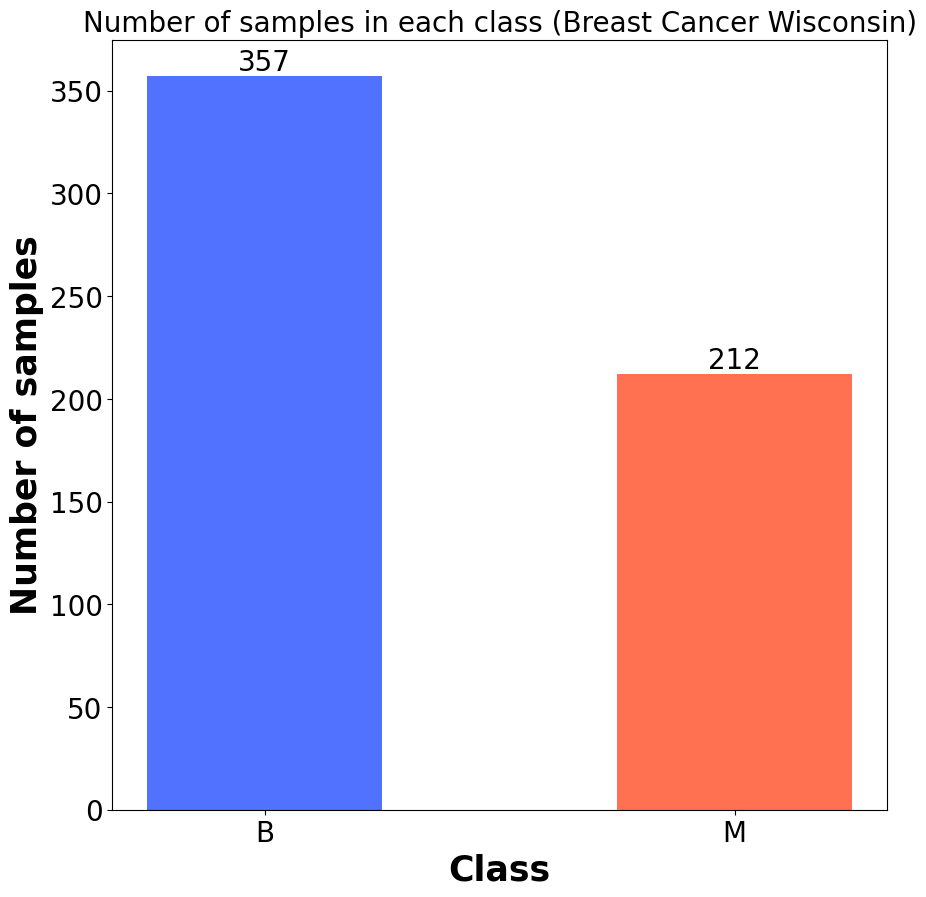

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
for i, (k, v) in enumerate(sample_number.items()):
    ax.bar(k, v, width=0.5, color=colors[i])
    plt.text(k, v + 0.1, str(v), ha="center", va="bottom", fontsize=20)
plt.title("Number of samples in each class (Breast Cancer Wisconsin)", fontsize=20)
plt.xlabel("Class", fontsize=25, weight="bold")
plt.ylabel("Number of samples", fontsize=25, weight="bold")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()
fig.savefig(img_folder + "sample/" + data_name, dpi=200)


## Select prototypes

In [9]:
prototypes_index = []
for class_name in sample_number:
    index_i = np.where(label == class_name)
    index_i = list(index_i[0])
    prototype_index_i = random.sample(index_i, num_prototypes)
    prototypes_index += prototype_index_i
prototypes_index.sort(reverse=True)
prototypes = [(feature[i], label[i]) for i in prototypes_index]
# Remove prototypes from dataset
feature = np.delete(feature, prototypes_index, axis=0)
label = np.delete(label, prototypes_index, axis=0)


### Accuracy

In [10]:
experiment = "experiment_1"

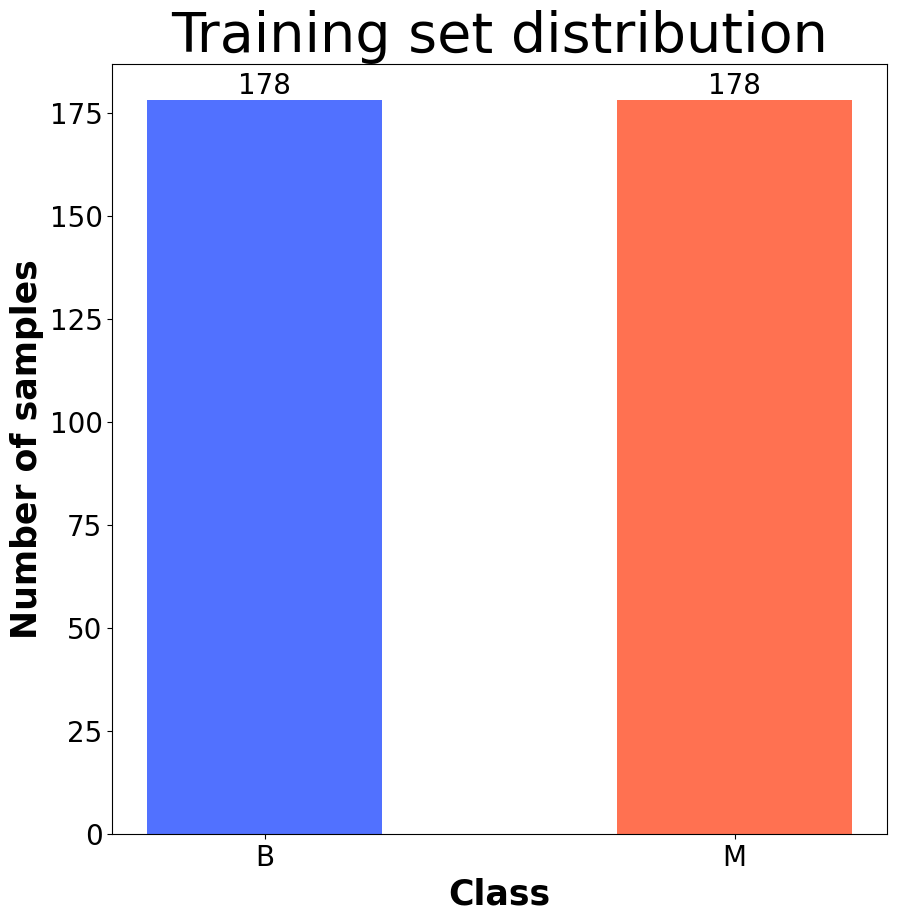

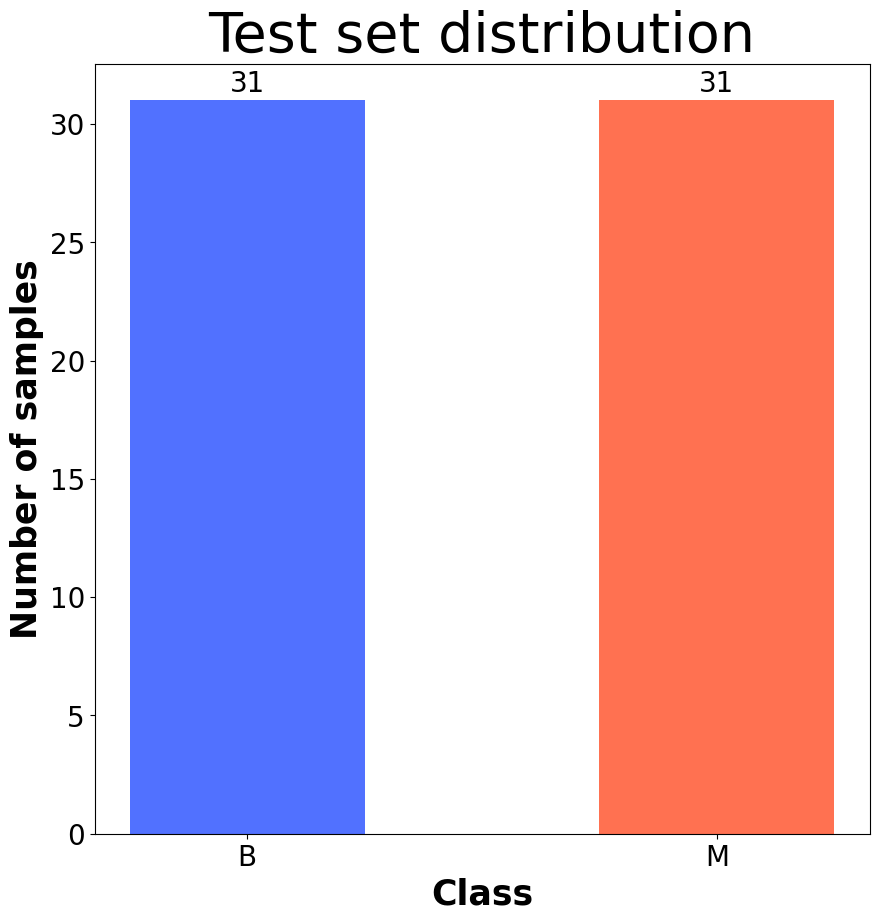

In [11]:
# Select equal amount of normal and abnormal data
data_per_class = min(count) - num_prototypes
test_percentage = 0.15
test_size = int(test_percentage * data_per_class)
train_size = data_per_class - test_size
feature_acc = copy.deepcopy(feature)
label_acc = copy.deepcopy(label)

# Select test set
test_index = []
for class_name in sample_number:
    index_i = np.where(label_acc == class_name)
    index_i = list(index_i[0])
    index_i_sample = random.sample(index_i, test_size)
    test_index += index_i_sample
test_index.sort(reverse=True)
test_set_acc = [(feature_acc[i], label_acc[i]) for i in test_index]
random.shuffle(test_set_acc)
unique, counts = np.unique(label_acc[test_index], return_counts=True)
test_dist = dict(zip(unique, counts))
feature_acc = np.delete(feature_acc, test_index, axis=0)
label_acc = np.delete(label_acc, test_index, axis=0)

# Select train set
train_index = []
for class_name in sample_number:
    index_i = np.where(label_acc == class_name)
    index_i = list(index_i[0])
    index_i_sample = random.sample(index_i, train_size)
    train_index += index_i_sample
train_index.sort(reverse=True)
unique, counts = np.unique(label_acc[train_index], return_counts=True)
train_dist = dict(zip(unique, counts))
train_set_acc = [(feature_acc[i], label_acc[i]) for i in train_index]
random.shuffle(train_set_acc)

fig, ax = plt.subplots(figsize=(10, 10))
for i, (k, v) in enumerate(train_dist.items()):
    ax.bar(k, v, width=0.5, color=colors[i])
    plt.text(k, v + 0.1, str(v), ha="center", va="bottom", fontsize=20)
plt.title("Training set distribution", fontsize=40)
plt.xlabel("Class", fontsize=25, weight="bold")
plt.ylabel("Number of samples", fontsize=25, weight="bold")
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.show()
fig.savefig(img_folder + experiment + "/" +
            data_name + "/train_dist.png", dpi=200)


fig, ax = plt.subplots(figsize=(10, 10))
for i, (k, v) in enumerate(test_dist.items()):
    ax.bar(k, v, width=0.5, color=colors[i])
    plt.text(k, v + 0.1, str(v), ha="center", va="bottom", fontsize=20)
plt.title("Test set distribution", fontsize=40)
plt.xlabel("Class", fontsize=25, weight="bold")
plt.ylabel("Number of samples", fontsize=25, weight="bold")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()
fig.savefig(img_folder + experiment + "/" +
            data_name + "/test_dist.png", dpi=200)


#### Train the Models

In [12]:
num_epochs = 100

##### GLVQ

##### 1-step lr =0.1

In [13]:
learning_rate = 0.1
oglvq_acc = oglvq.OGLVQ(prototypes, learning_rate)
hist = oglvq_acc.train(
    num_epochs, train_set_acc, test_set_acc, sample_number=train_dist
)

Epoch: 1, Loss: 129.1284, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 11, Loss: 124.0919, Accuracy: 96.77 %, F_1_score: 96.77 %
Epoch: 21, Loss: 123.9766, Accuracy: 96.77 %, F_1_score: 96.77 %
Epoch: 31, Loss: 123.9311, Accuracy: 96.77 %, F_1_score: 96.77 %
Epoch: 41, Loss: 123.9090, Accuracy: 96.77 %, F_1_score: 96.77 %
Epoch: 51, Loss: 123.8920, Accuracy: 96.77 %, F_1_score: 96.77 %
Epoch: 61, Loss: 123.8757, Accuracy: 96.77 %, F_1_score: 96.77 %
Epoch: 71, Loss: 123.8661, Accuracy: 96.77 %, F_1_score: 96.77 %
Epoch: 81, Loss: 123.8591, Accuracy: 96.77 %, F_1_score: 96.77 %
Epoch: 91, Loss: 123.8537, Accuracy: 96.77 %, F_1_score: 96.77 %


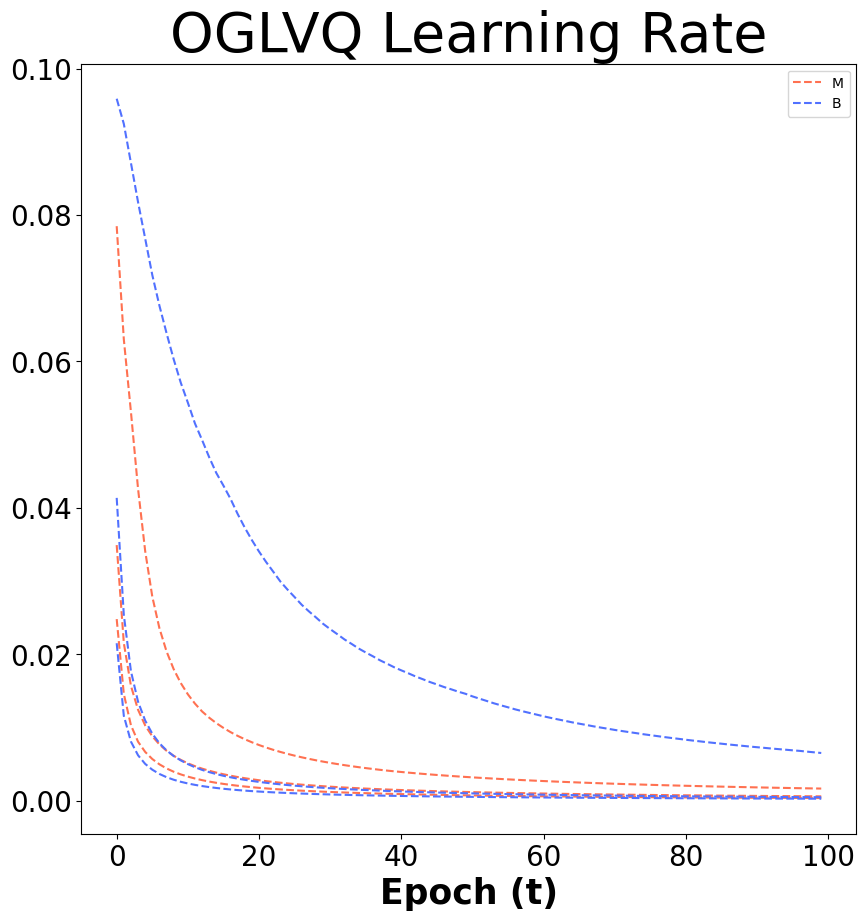

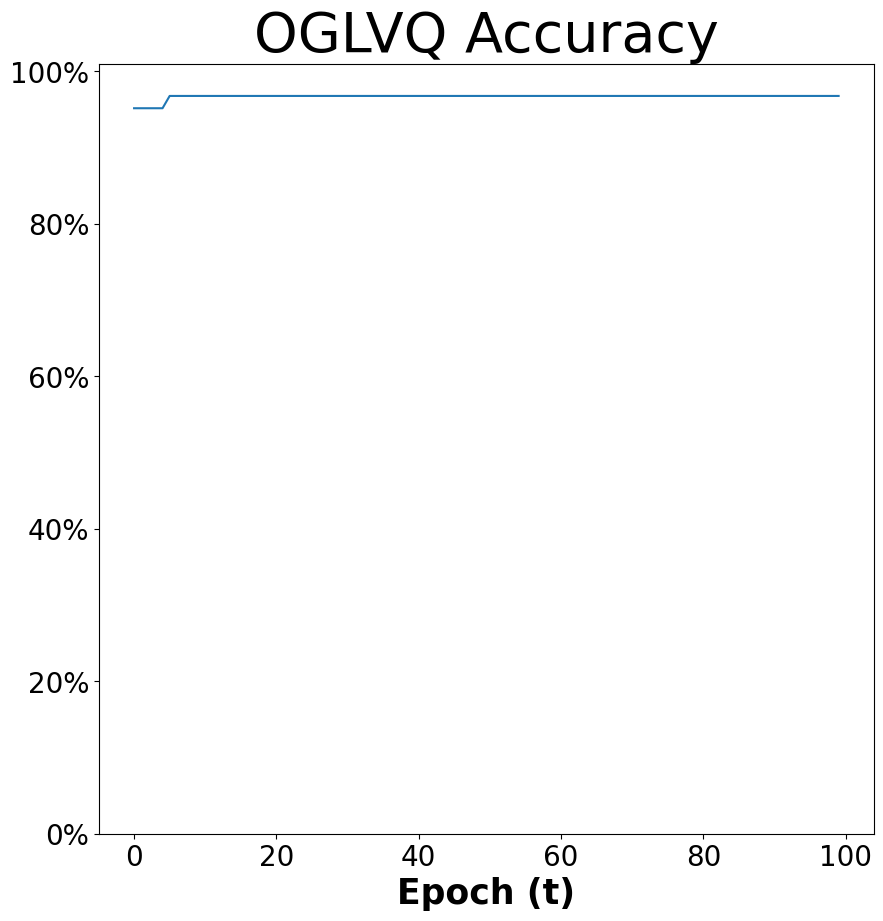

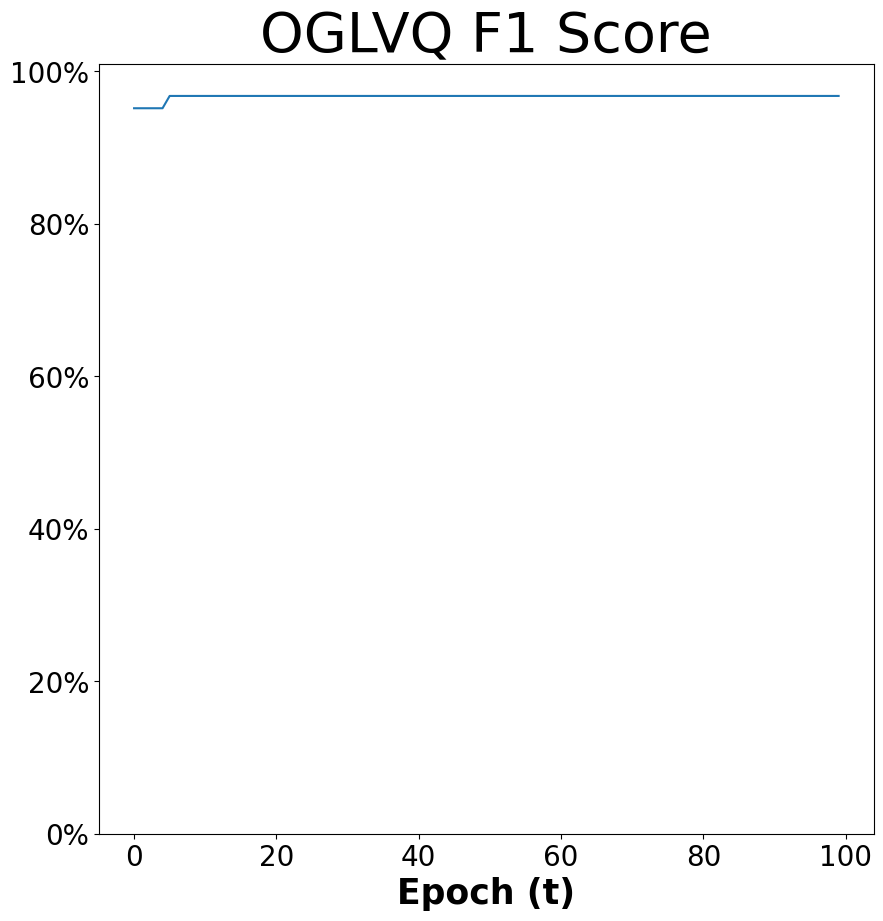

In [14]:
save_figs(oglvq_acc, experiment, "OGLVQ", learning_rate)

##### 2-step lr = 0.03

In [15]:
learning_rate = 0.03
oglvq_acc = oglvq.OGLVQ(
    prototypes,
    learning_rate,
)
hist = oglvq_acc.train(
    num_epochs, train_set_acc, test_set_acc, sample_number=train_dist
)

Epoch: 1, Loss: 133.6106, Accuracy: 96.77 %, F_1_score: 96.77 %
Epoch: 11, Loss: 124.5838, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 21, Loss: 124.1948, Accuracy: 96.77 %, F_1_score: 96.77 %
Epoch: 31, Loss: 124.0715, Accuracy: 96.77 %, F_1_score: 96.77 %
Epoch: 41, Loss: 124.0212, Accuracy: 96.77 %, F_1_score: 96.77 %
Epoch: 51, Loss: 123.9923, Accuracy: 96.77 %, F_1_score: 96.77 %
Epoch: 61, Loss: 123.9636, Accuracy: 96.77 %, F_1_score: 96.77 %
Epoch: 71, Loss: 123.9438, Accuracy: 96.77 %, F_1_score: 96.77 %
Epoch: 81, Loss: 123.9303, Accuracy: 96.77 %, F_1_score: 96.77 %
Epoch: 91, Loss: 123.9191, Accuracy: 96.77 %, F_1_score: 96.77 %


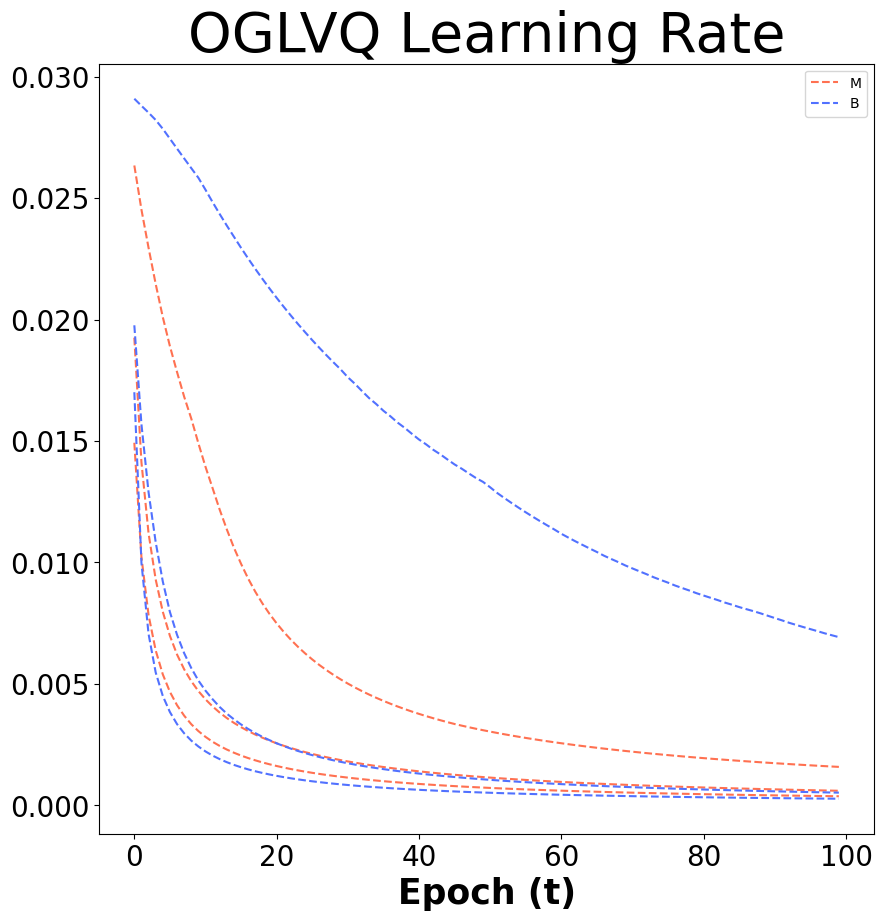

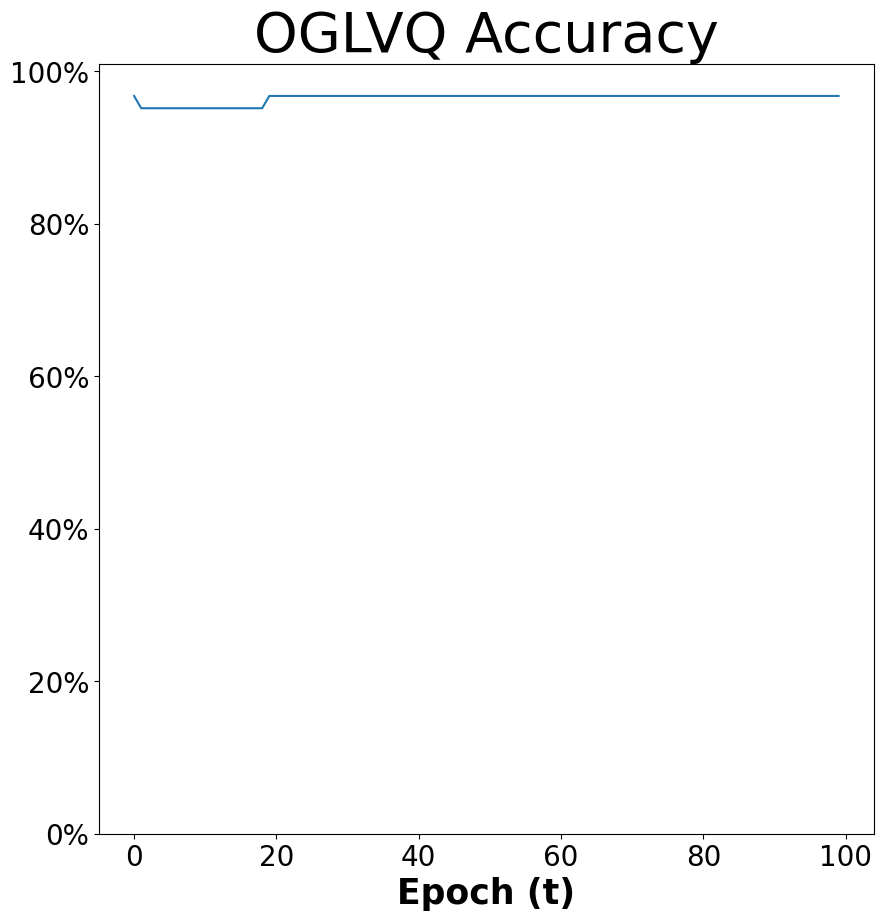

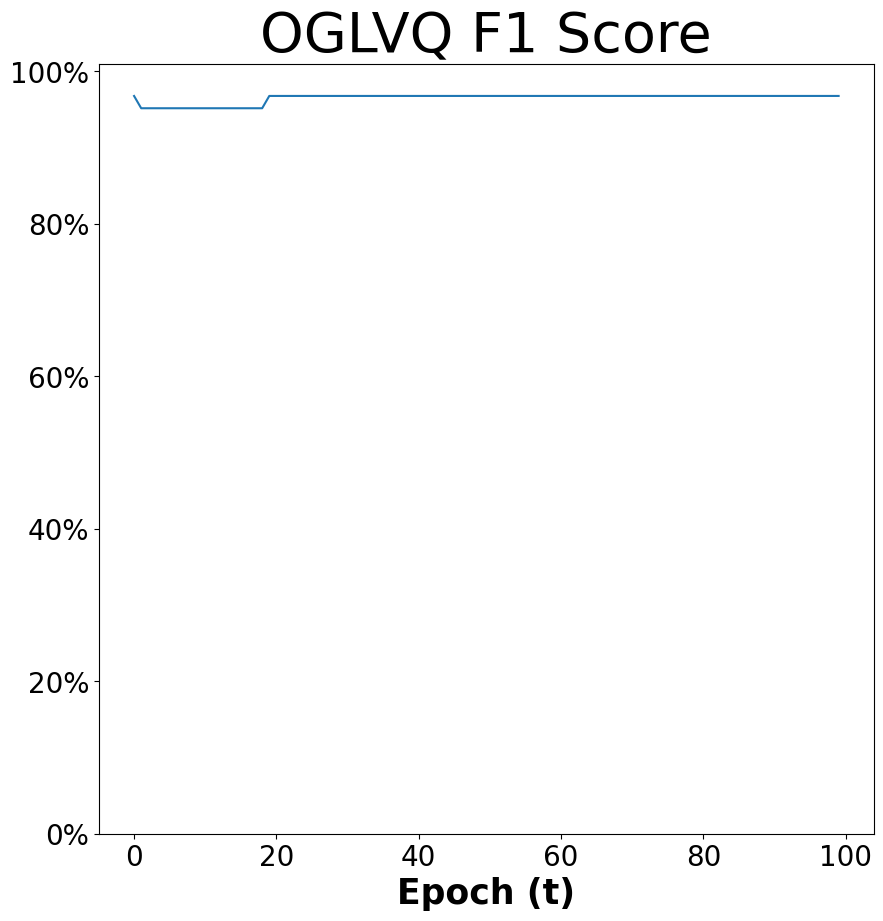

In [16]:
save_figs(oglvq_acc, experiment, "OGLVQ", learning_rate)

##### 3-step lr = 0.01

In [17]:
learning_rate = 0.01
oglvq_acc = oglvq.OGLVQ(prototypes, learning_rate)
hist = oglvq_acc.train(
    num_epochs, train_set_acc, test_set_acc, sample_number=train_dist
)

Epoch: 1, Loss: 139.5073, Accuracy: 93.55 %, F_1_score: 93.52 %
Epoch: 11, Loss: 125.4346, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 21, Loss: 124.8387, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 31, Loss: 124.5766, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 41, Loss: 124.4017, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 51, Loss: 124.2704, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 61, Loss: 124.1843, Accuracy: 96.77 %, F_1_score: 96.77 %
Epoch: 71, Loss: 124.1289, Accuracy: 96.77 %, F_1_score: 96.77 %
Epoch: 81, Loss: 124.0909, Accuracy: 96.77 %, F_1_score: 96.77 %
Epoch: 91, Loss: 124.0637, Accuracy: 96.77 %, F_1_score: 96.77 %


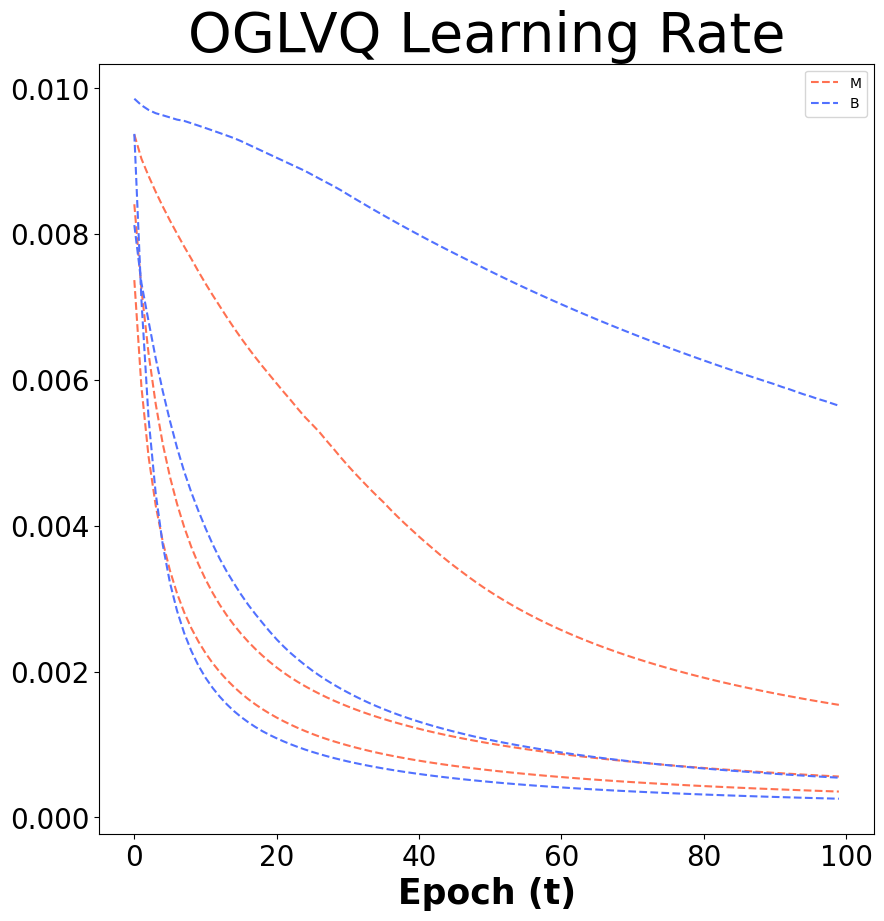

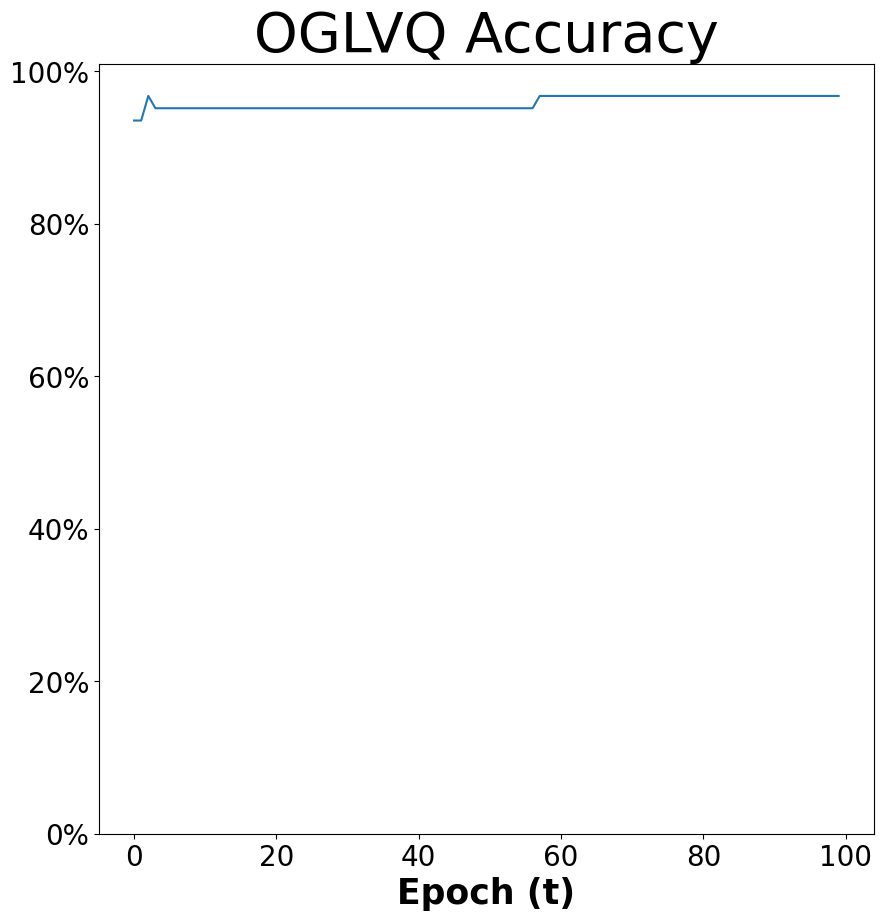

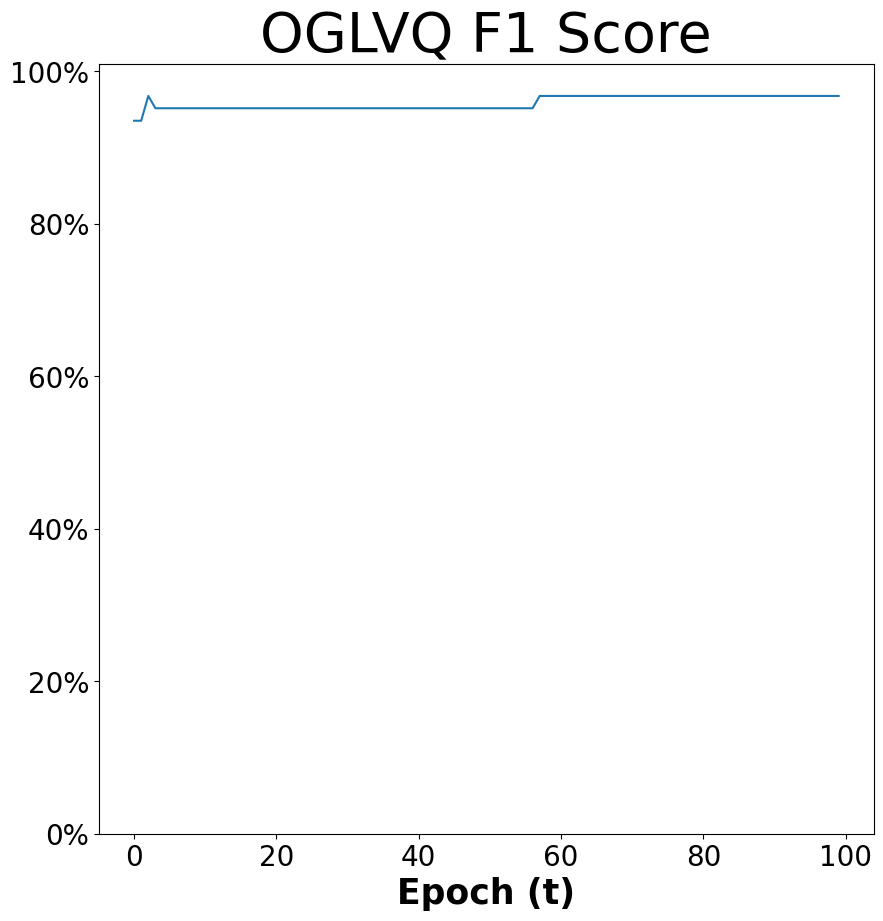

In [18]:
save_figs(oglvq_acc, experiment, "OGLVQ", learning_rate)

##### CP

##### 1-step lr = 0.1

In [19]:
learning_rate = 0.1
cp_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = cp_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.conditional_probability,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3963, Accuracy: 80.65 %, F_1_score: 80.13 %
Epoch: 11, Loss: 0.3822, Accuracy: 80.65 %, F_1_score: 79.89 %
Epoch: 21, Loss: 0.4008, Accuracy: 69.35 %, F_1_score: 66.18 %
Epoch: 31, Loss: 0.4118, Accuracy: 67.74 %, F_1_score: 64.00 %
Epoch: 41, Loss: 0.4236, Accuracy: 66.13 %, F_1_score: 61.74 %
Epoch: 51, Loss: 0.4316, Accuracy: 66.13 %, F_1_score: 61.74 %
Epoch: 61, Loss: 0.4336, Accuracy: 66.13 %, F_1_score: 61.74 %
Epoch: 71, Loss: 0.4318, Accuracy: 66.13 %, F_1_score: 61.74 %
Epoch: 81, Loss: 0.4338, Accuracy: 64.52 %, F_1_score: 59.40 %
Epoch: 91, Loss: 0.4342, Accuracy: 64.52 %, F_1_score: 59.40 %


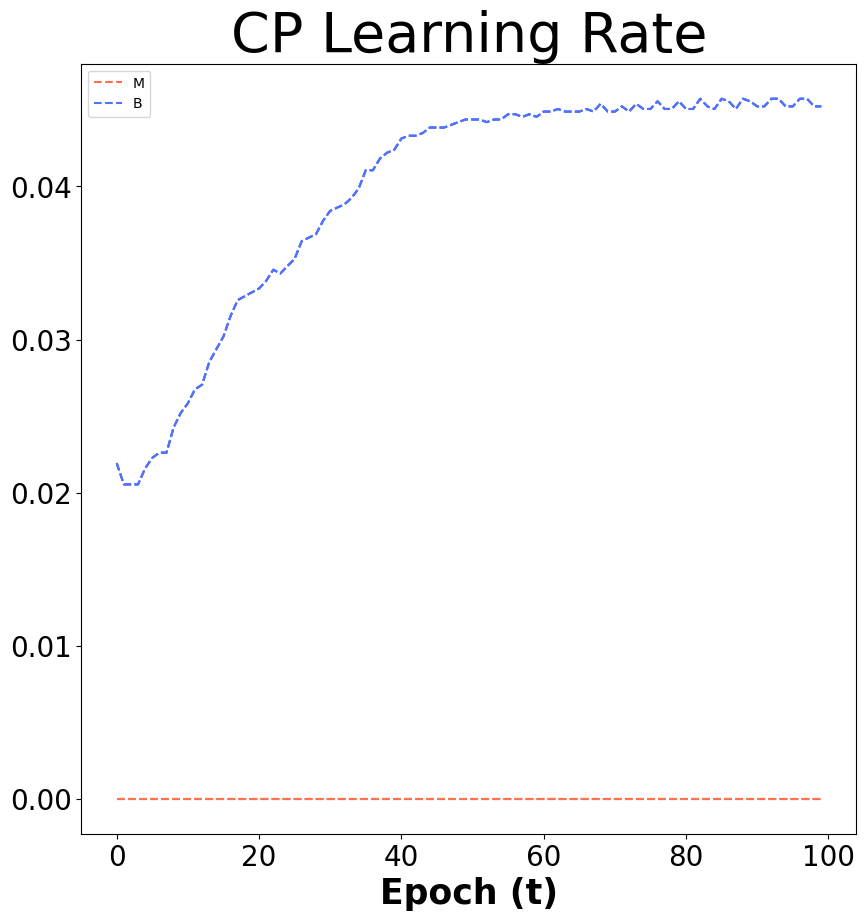

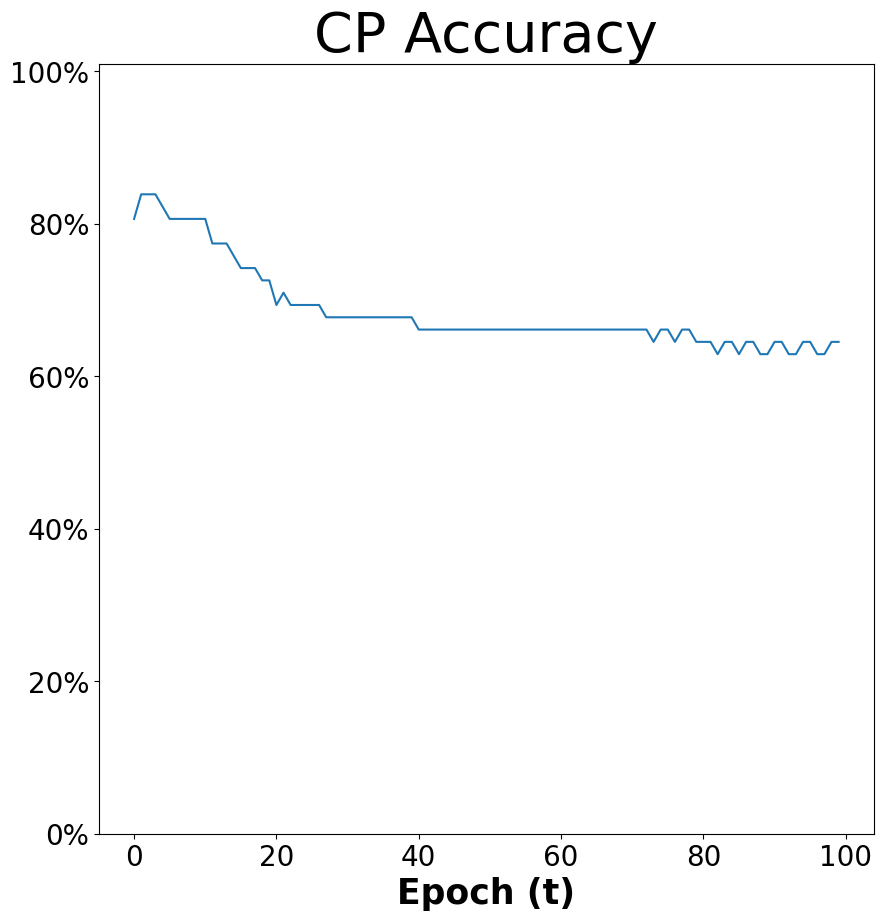

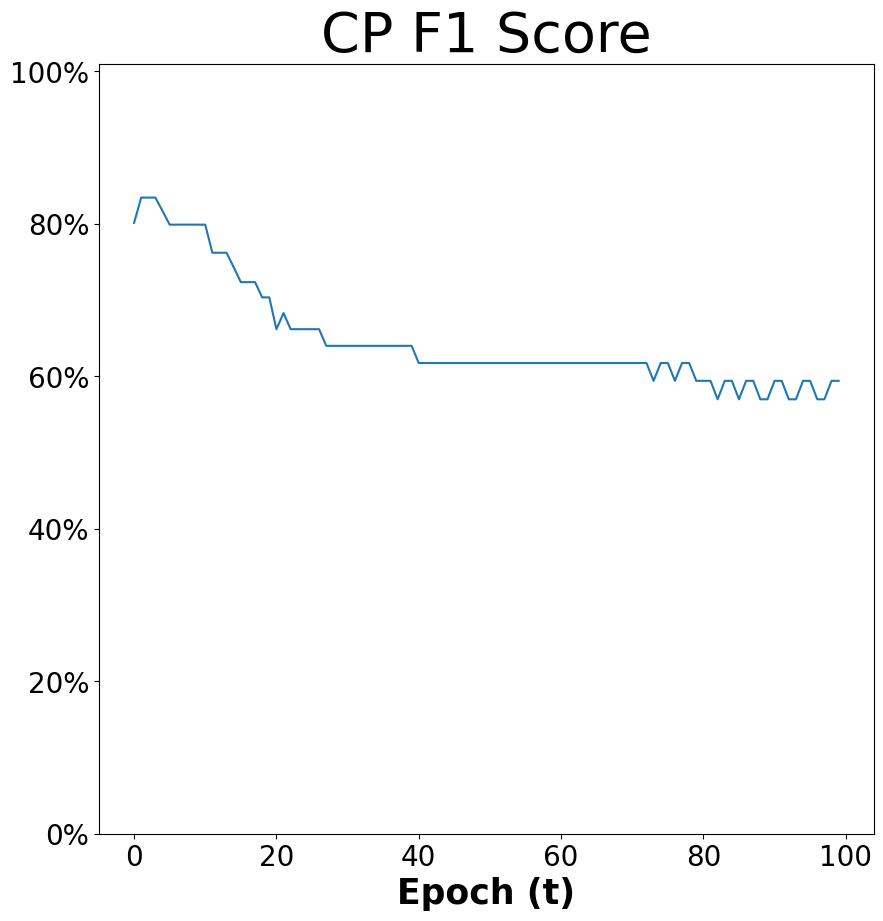

In [20]:
save_figs(cp_glvq_acc, experiment, "CP", learning_rate)

##### 2-step lr = 0.03

In [21]:
learning_rate = 0.03
cp_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = cp_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.conditional_probability,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4071, Accuracy: 80.65 %, F_1_score: 80.13 %
Epoch: 11, Loss: 0.3757, Accuracy: 83.87 %, F_1_score: 83.44 %
Epoch: 21, Loss: 0.3769, Accuracy: 80.65 %, F_1_score: 79.89 %
Epoch: 31, Loss: 0.3847, Accuracy: 79.03 %, F_1_score: 78.07 %
Epoch: 41, Loss: 0.3930, Accuracy: 75.81 %, F_1_score: 74.30 %
Epoch: 51, Loss: 0.3993, Accuracy: 74.19 %, F_1_score: 72.35 %
Epoch: 61, Loss: 0.4031, Accuracy: 74.19 %, F_1_score: 72.35 %
Epoch: 71, Loss: 0.4055, Accuracy: 72.58 %, F_1_score: 70.35 %
Epoch: 81, Loss: 0.4085, Accuracy: 67.74 %, F_1_score: 64.00 %
Epoch: 91, Loss: 0.4119, Accuracy: 67.74 %, F_1_score: 64.00 %


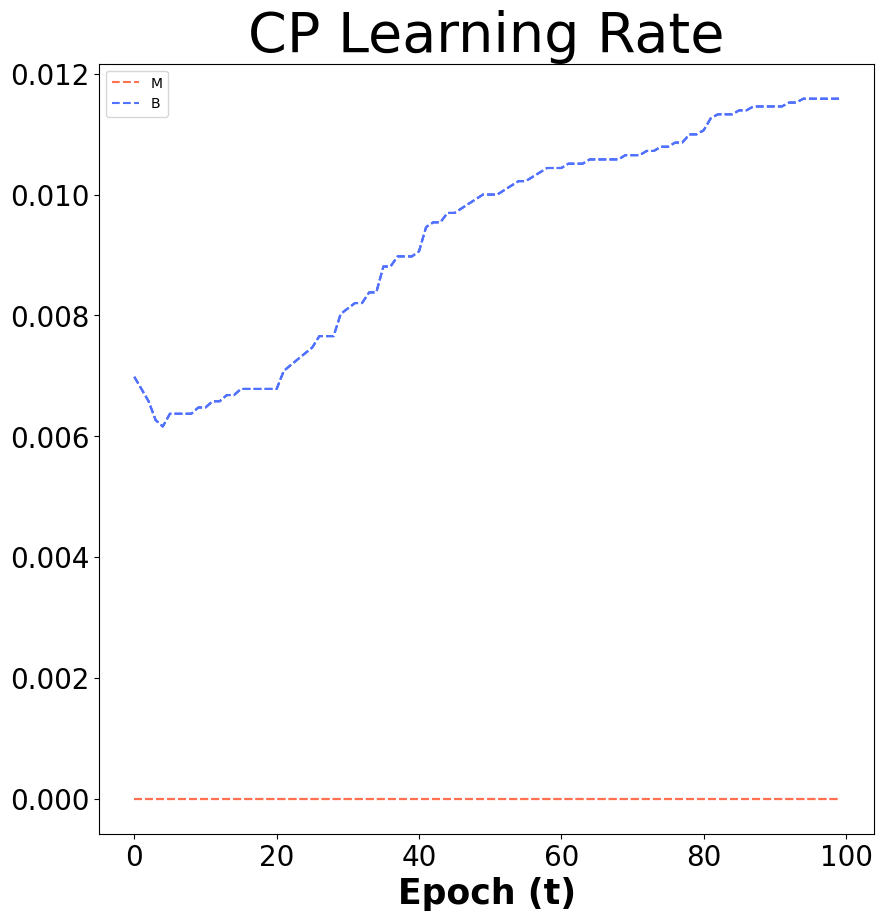

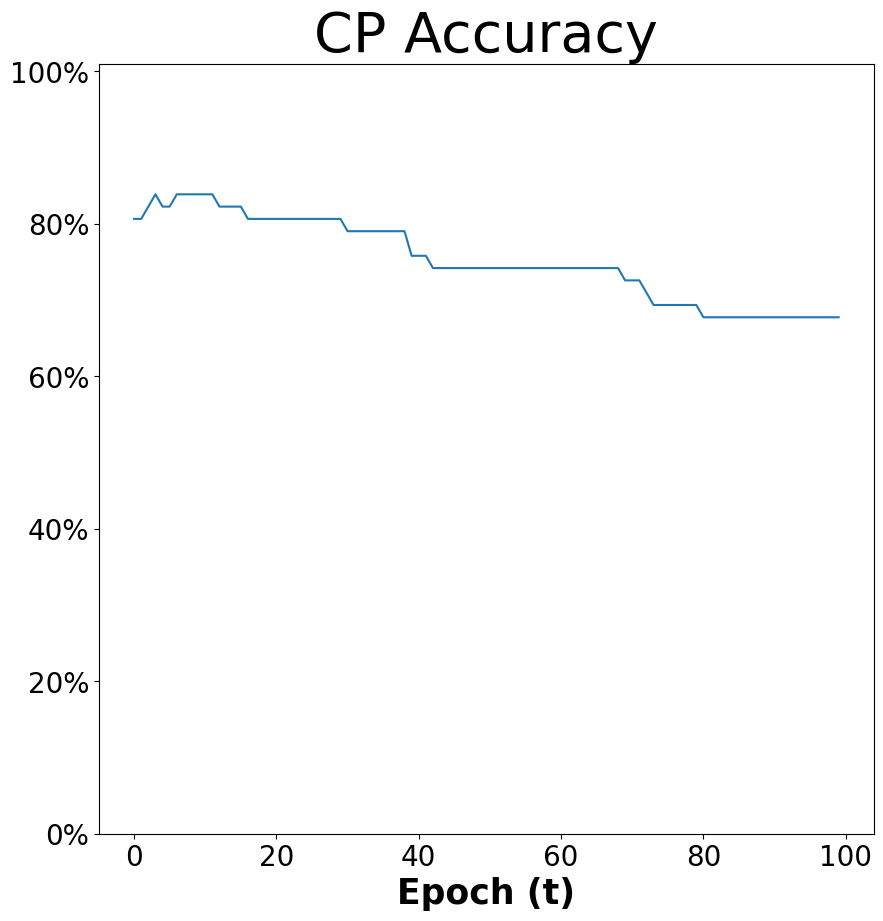

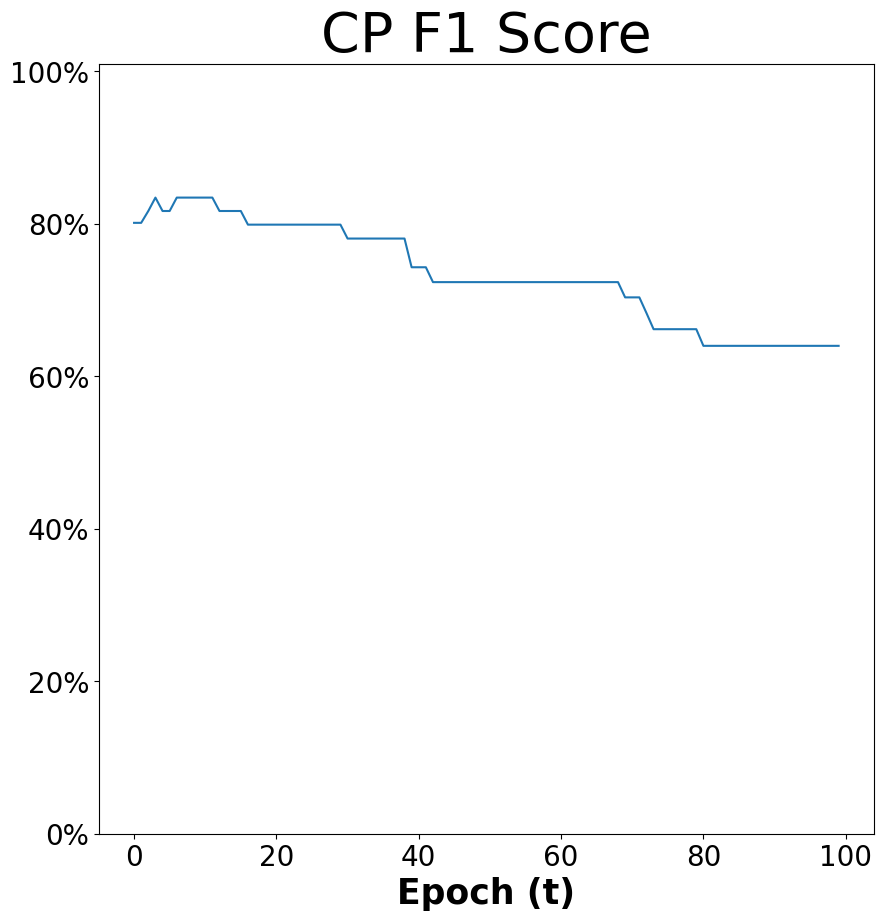

In [22]:
save_figs(cp_glvq_acc, experiment, "CP", learning_rate)

##### 3-step lr = 0.01

In [23]:
learning_rate = 0.01
cp_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = cp_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.conditional_probability,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4118, Accuracy: 82.26 %, F_1_score: 81.88 %
Epoch: 11, Loss: 0.3859, Accuracy: 83.87 %, F_1_score: 83.44 %
Epoch: 21, Loss: 0.3793, Accuracy: 83.87 %, F_1_score: 83.44 %
Epoch: 31, Loss: 0.3763, Accuracy: 83.87 %, F_1_score: 83.44 %
Epoch: 41, Loss: 0.3756, Accuracy: 82.26 %, F_1_score: 81.68 %
Epoch: 51, Loss: 0.3761, Accuracy: 80.65 %, F_1_score: 79.89 %
Epoch: 61, Loss: 0.3771, Accuracy: 80.65 %, F_1_score: 79.89 %
Epoch: 71, Loss: 0.3794, Accuracy: 80.65 %, F_1_score: 79.89 %
Epoch: 81, Loss: 0.3821, Accuracy: 80.65 %, F_1_score: 79.89 %
Epoch: 91, Loss: 0.3850, Accuracy: 79.03 %, F_1_score: 78.07 %


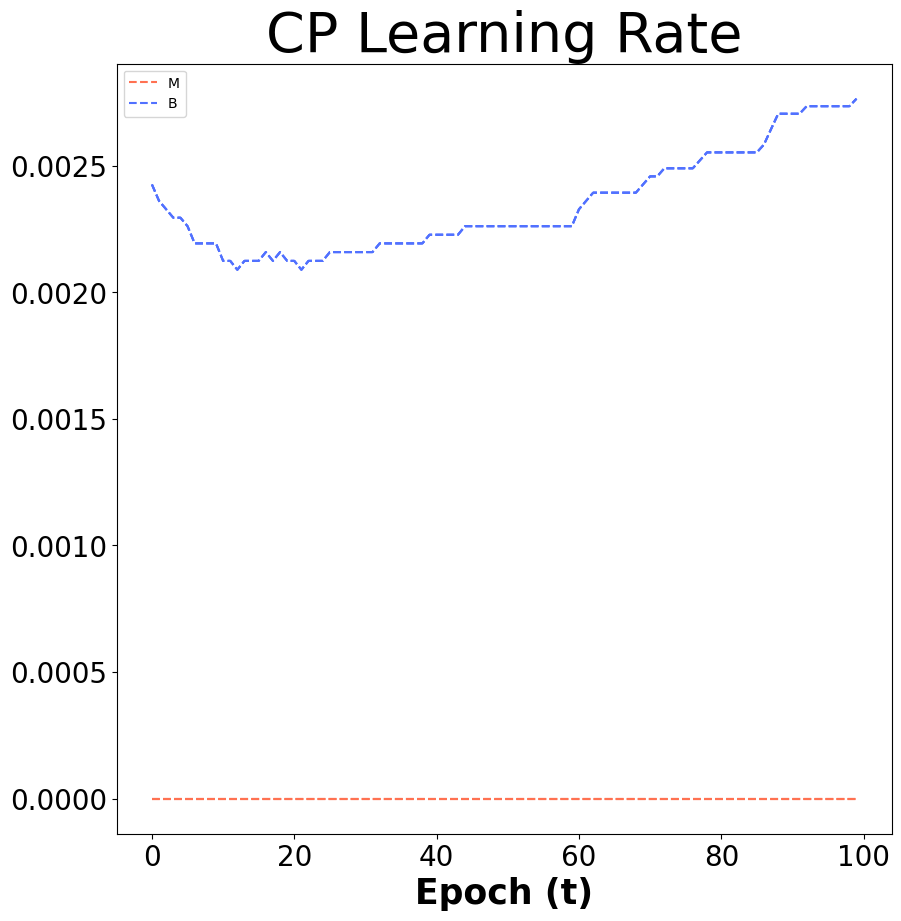

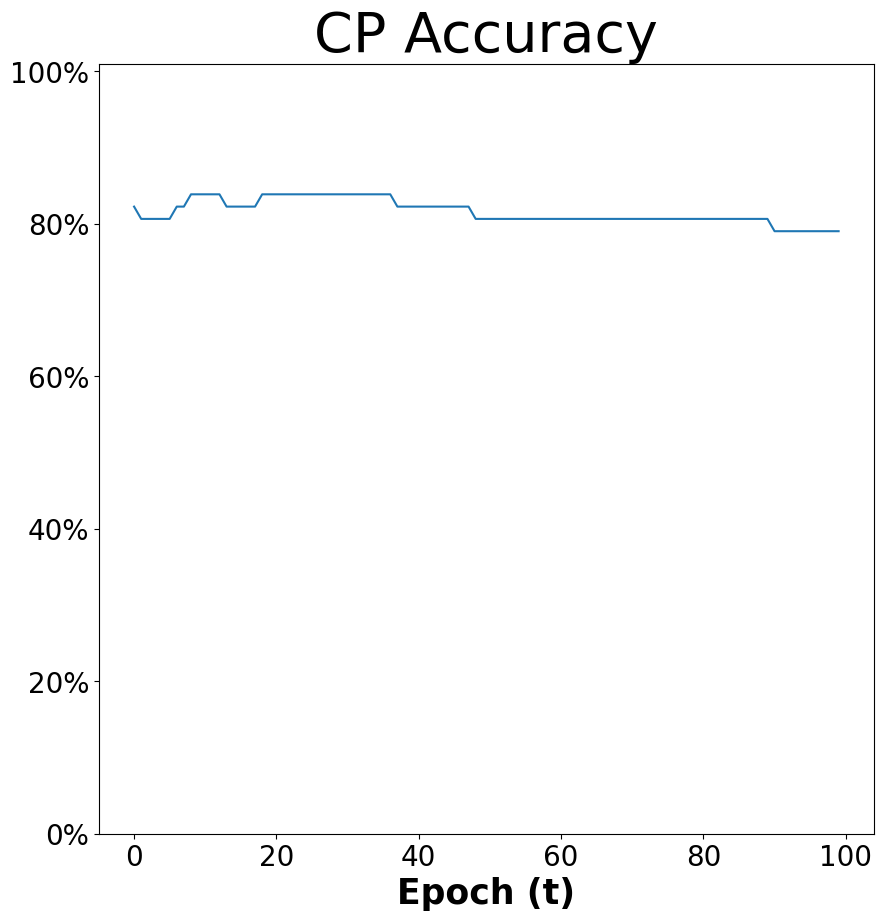

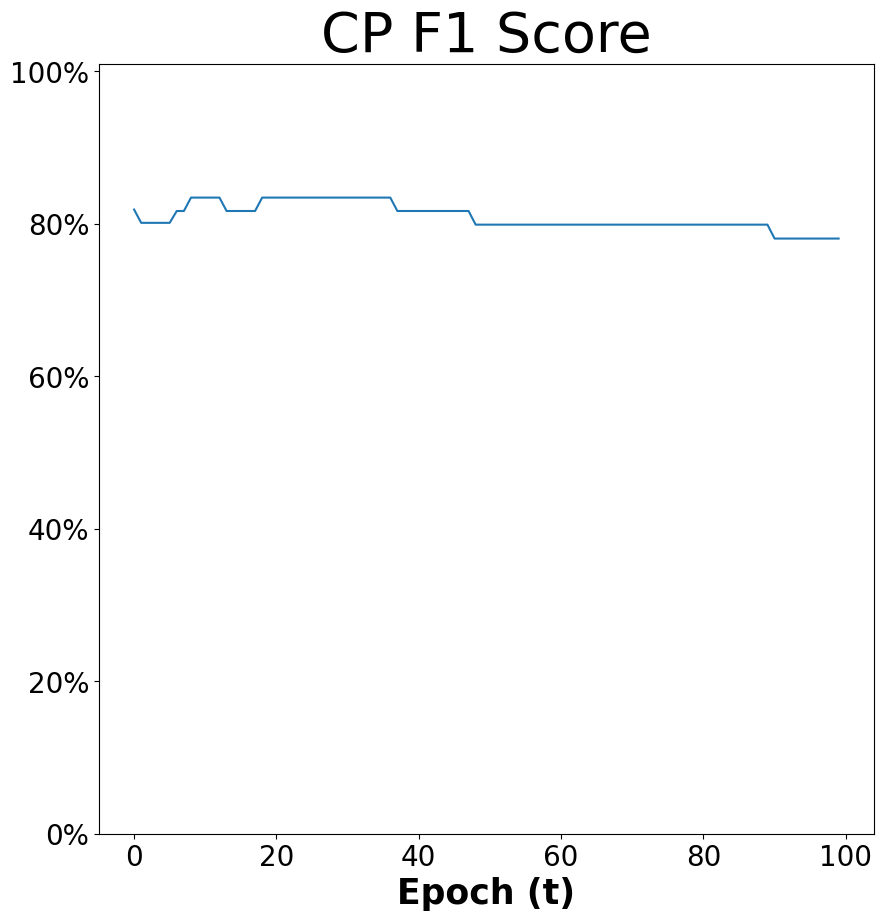

In [24]:
save_figs(cp_glvq_acc, experiment, "CP", learning_rate)

##### DFH

##### 1-step lr = 0.1

In [25]:
learning_rate = 0.1
dfh_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = dfh_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.dual_factor_heuristic,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3726, Accuracy: 93.55 %, F_1_score: 93.55 %
Epoch: 11, Loss: 0.3492, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 21, Loss: 0.3488, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 31, Loss: 0.3487, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 41, Loss: 0.3487, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 51, Loss: 0.3487, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 61, Loss: 0.3485, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 71, Loss: 0.3485, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 81, Loss: 0.3485, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 91, Loss: 0.3484, Accuracy: 95.16 %, F_1_score: 95.16 %


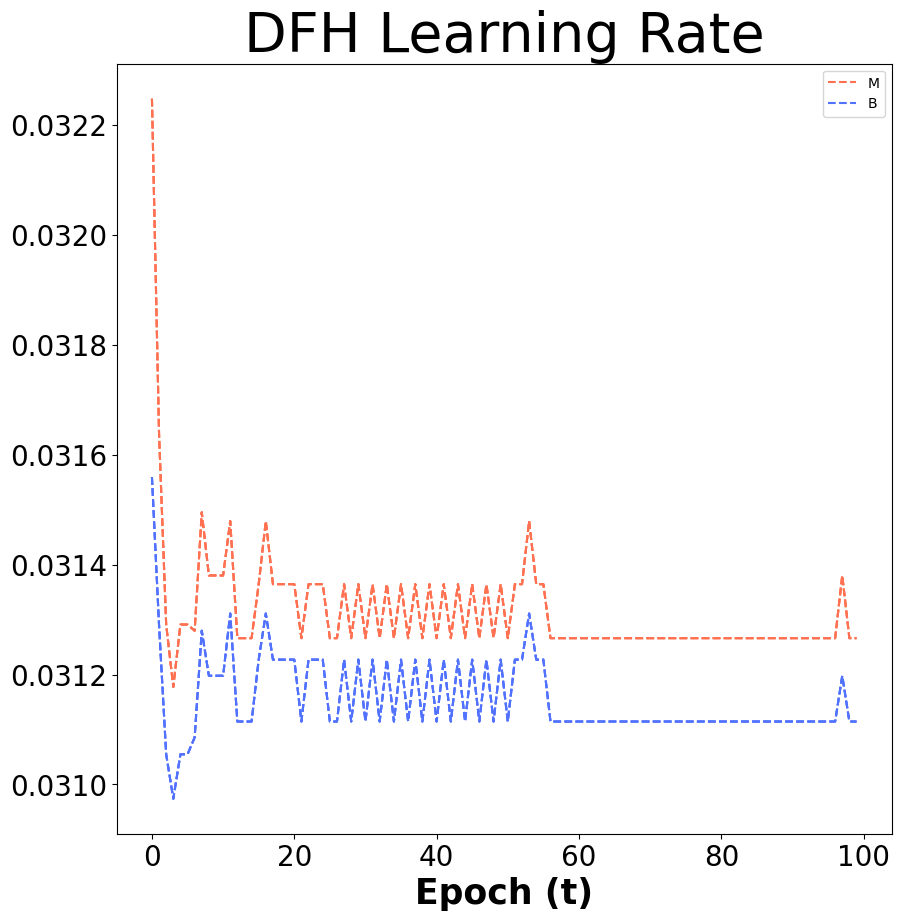

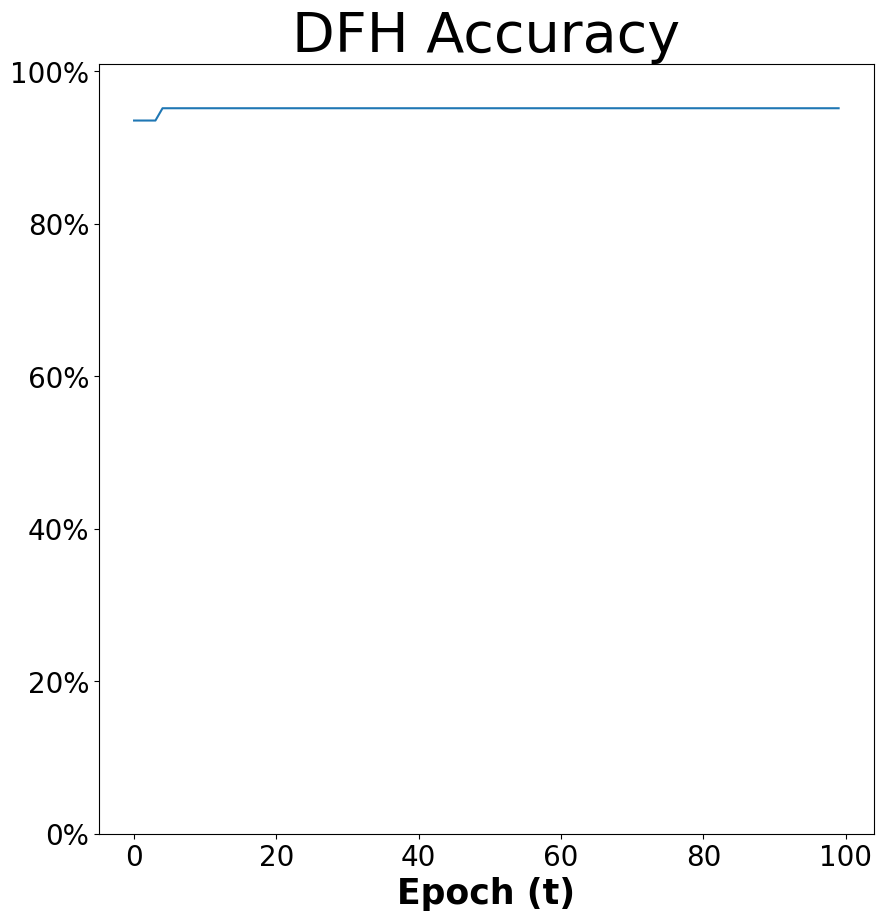

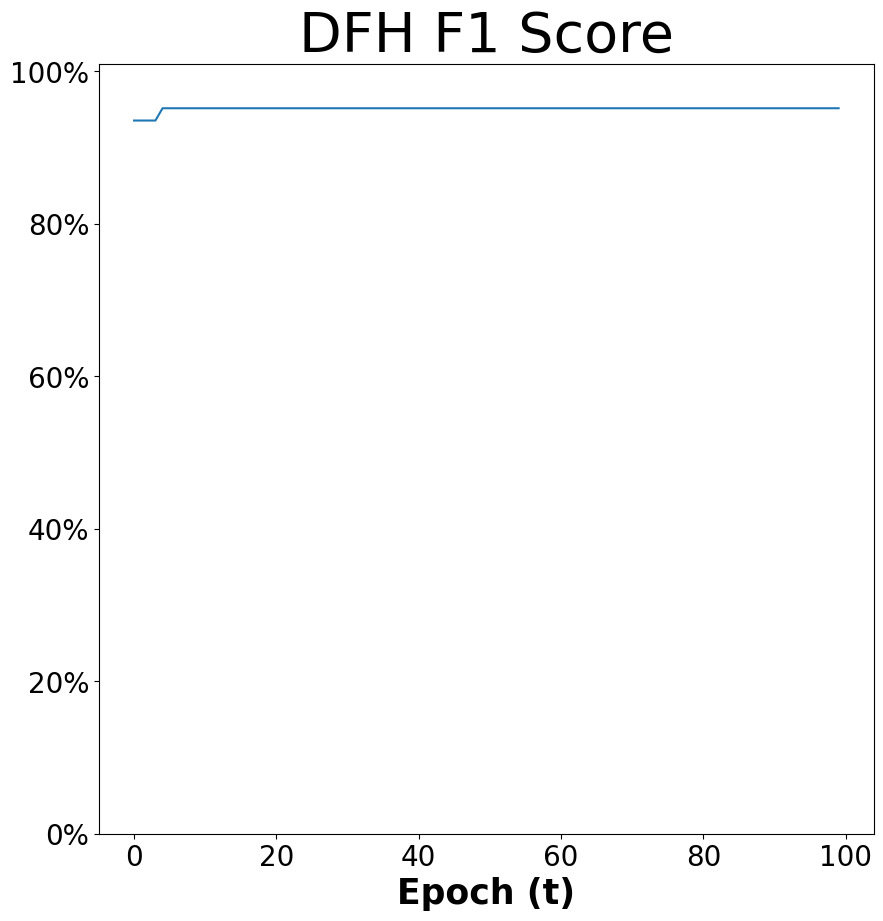

In [26]:
save_figs(dfh_glvq_acc, experiment, "DFH", learning_rate)

##### 2-step lr = 0.03

In [27]:
learning_rate = 0.03
dfh_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = dfh_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.dual_factor_heuristic,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3908, Accuracy: 91.94 %, F_1_score: 91.92 %
Epoch: 11, Loss: 0.3508, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 21, Loss: 0.3498, Accuracy: 96.77 %, F_1_score: 96.77 %
Epoch: 31, Loss: 0.3488, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 41, Loss: 0.3485, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 51, Loss: 0.3483, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 61, Loss: 0.3483, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 71, Loss: 0.3482, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 81, Loss: 0.3482, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 91, Loss: 0.3482, Accuracy: 95.16 %, F_1_score: 95.16 %


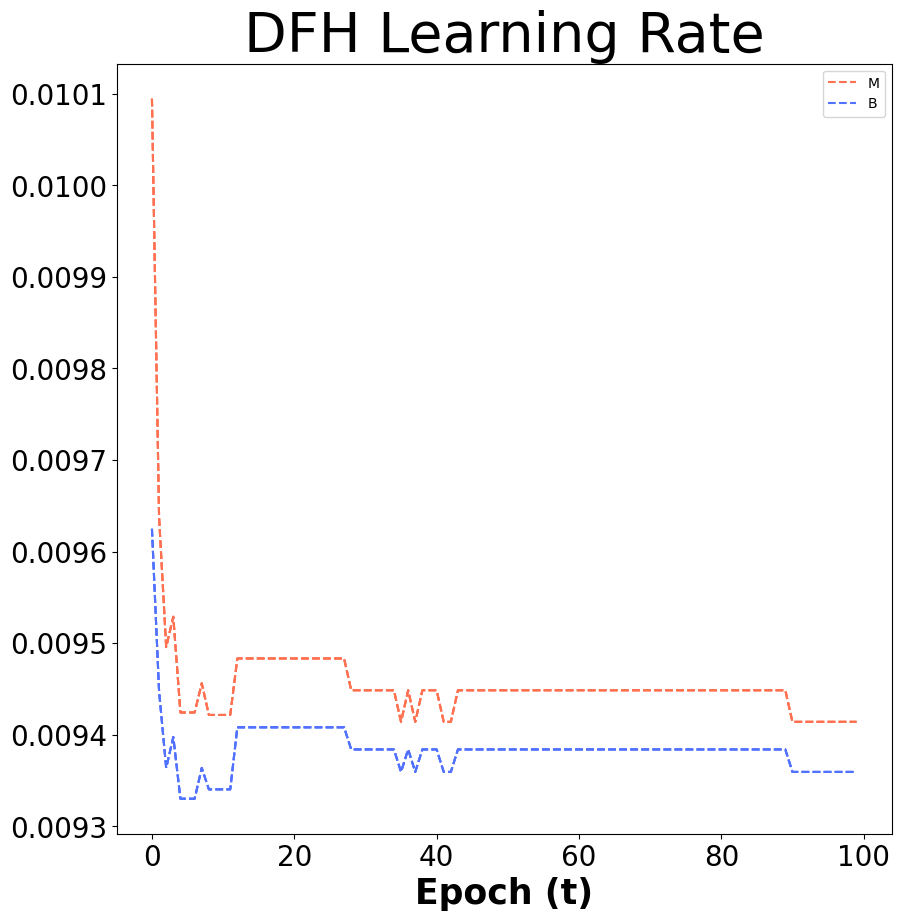

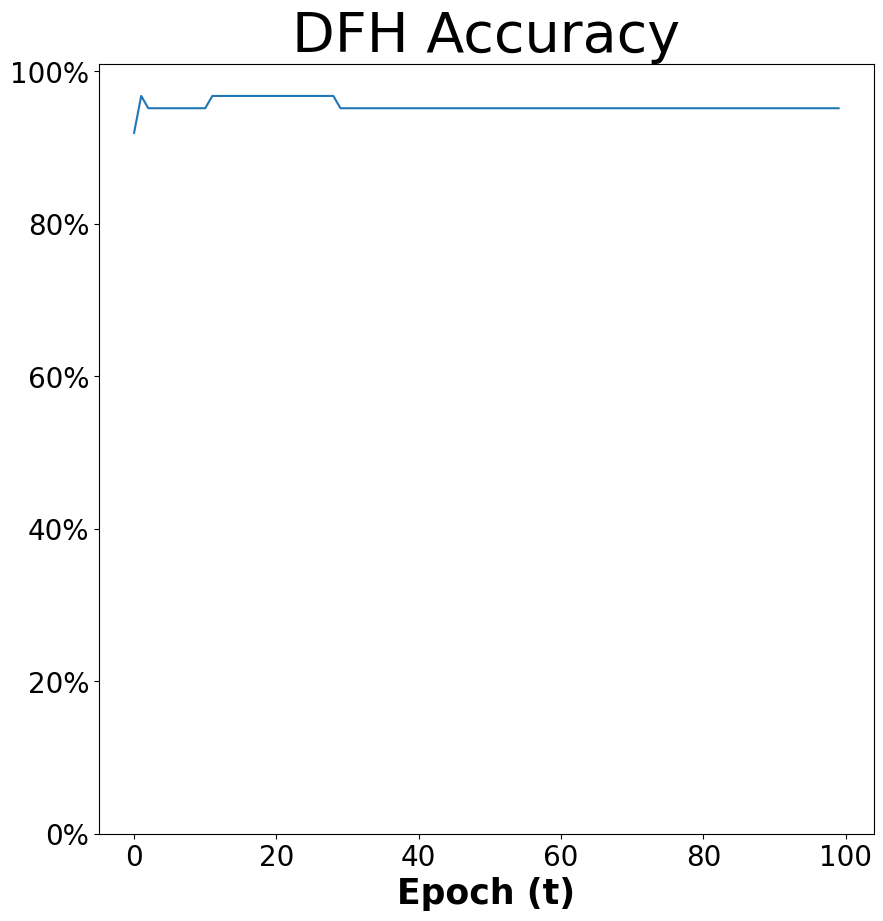

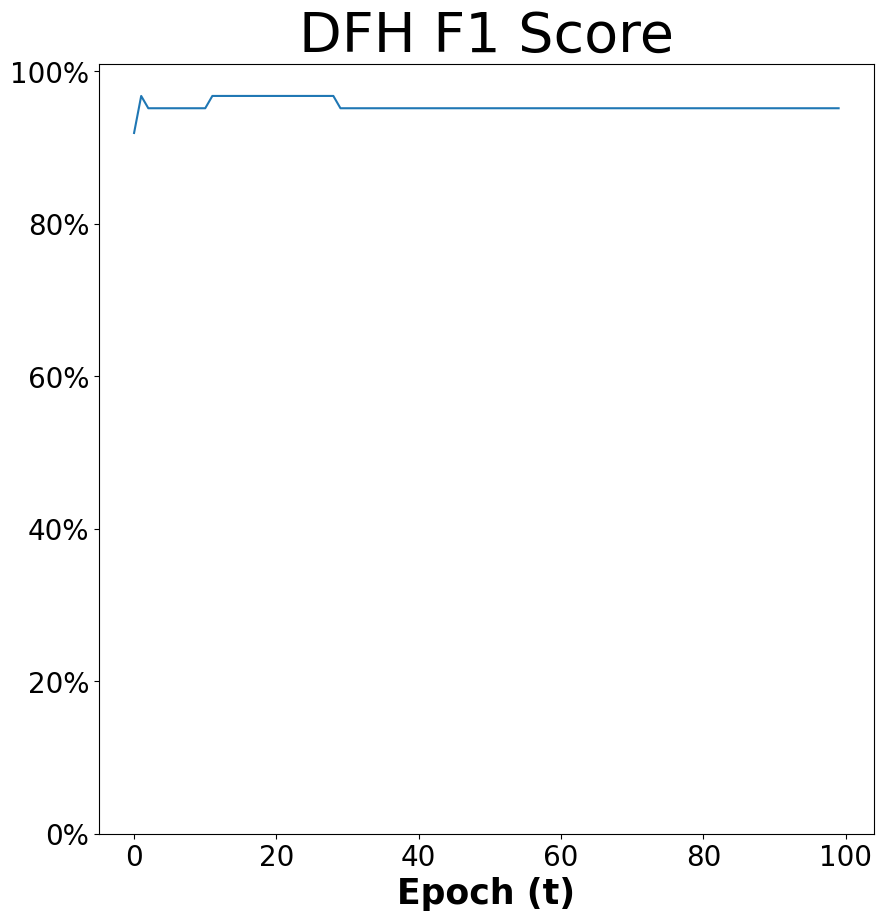

In [28]:
save_figs(dfh_glvq_acc, experiment, "DFH", learning_rate)

##### 3-step lr = 0.01

In [29]:
learning_rate = 0.01
dfh_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = dfh_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.dual_factor_heuristic,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4051, Accuracy: 87.10 %, F_1_score: 86.97 %
Epoch: 11, Loss: 0.3556, Accuracy: 93.55 %, F_1_score: 93.55 %
Epoch: 21, Loss: 0.3517, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 31, Loss: 0.3506, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 41, Loss: 0.3502, Accuracy: 96.77 %, F_1_score: 96.77 %
Epoch: 51, Loss: 0.3499, Accuracy: 96.77 %, F_1_score: 96.77 %
Epoch: 61, Loss: 0.3496, Accuracy: 96.77 %, F_1_score: 96.77 %
Epoch: 71, Loss: 0.3493, Accuracy: 96.77 %, F_1_score: 96.77 %
Epoch: 81, Loss: 0.3489, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 91, Loss: 0.3486, Accuracy: 95.16 %, F_1_score: 95.16 %


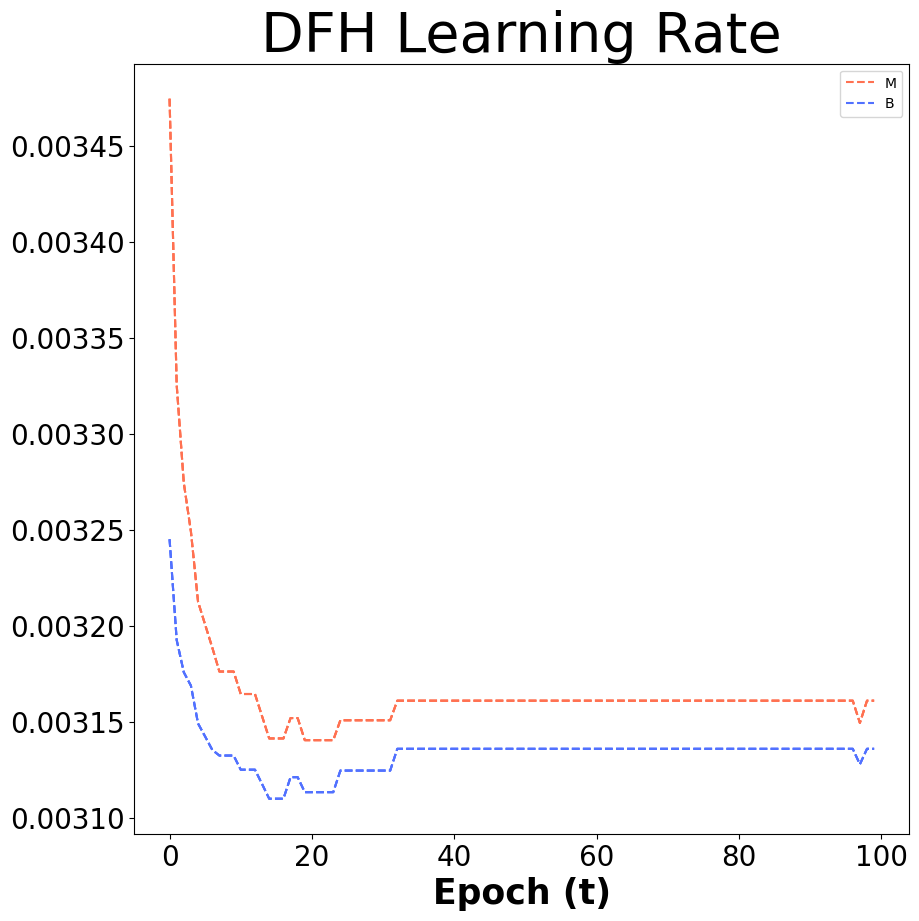

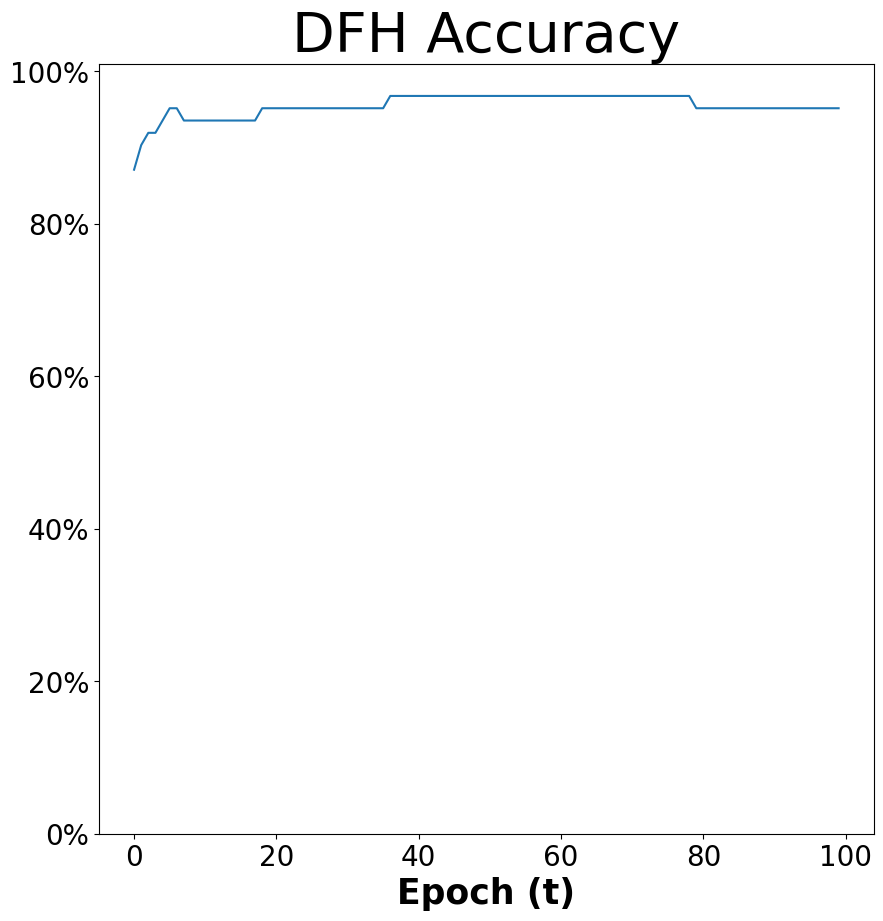

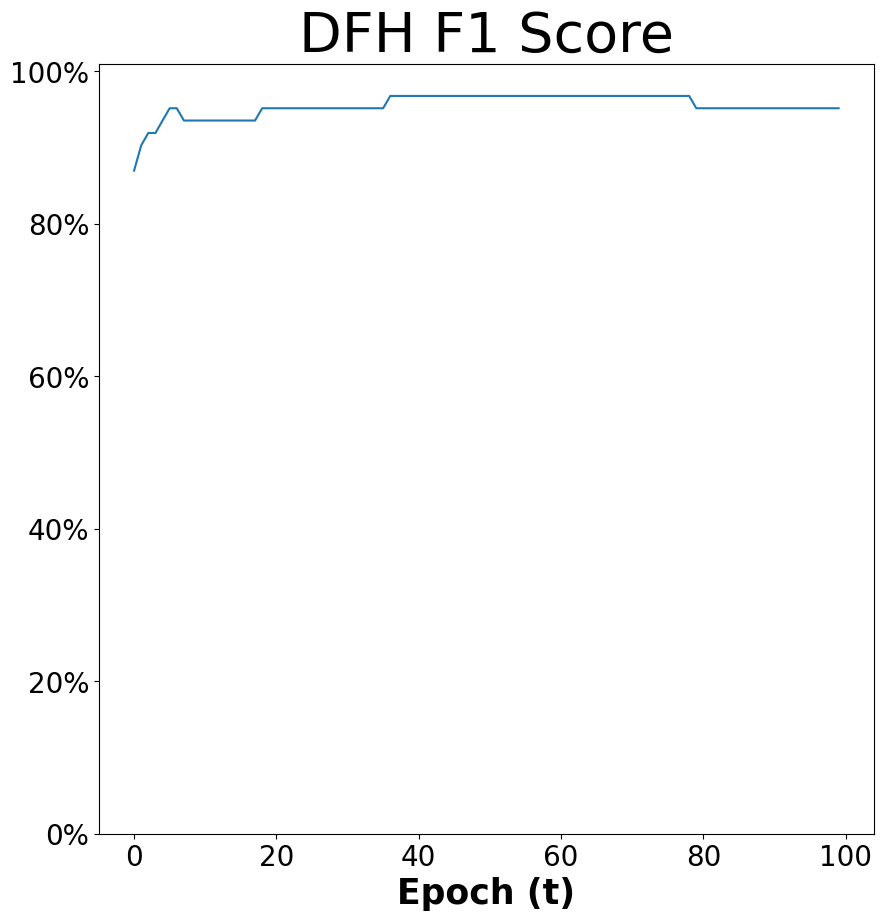

In [30]:
save_figs(dfh_glvq_acc, experiment, "DFH", learning_rate)

##### MS

##### 1-step lr = 0.1

In [31]:
learning_rate = 0.1
ms_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = ms_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.middle_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3667, Accuracy: 93.55 %, F_1_score: 93.55 %
Epoch: 11, Loss: 0.3493, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 21, Loss: 0.3491, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 31, Loss: 0.3489, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 41, Loss: 0.3488, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 51, Loss: 0.3488, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 61, Loss: 0.3488, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 71, Loss: 0.3488, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 81, Loss: 0.3487, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 91, Loss: 0.3487, Accuracy: 96.77 %, F_1_score: 96.77 %


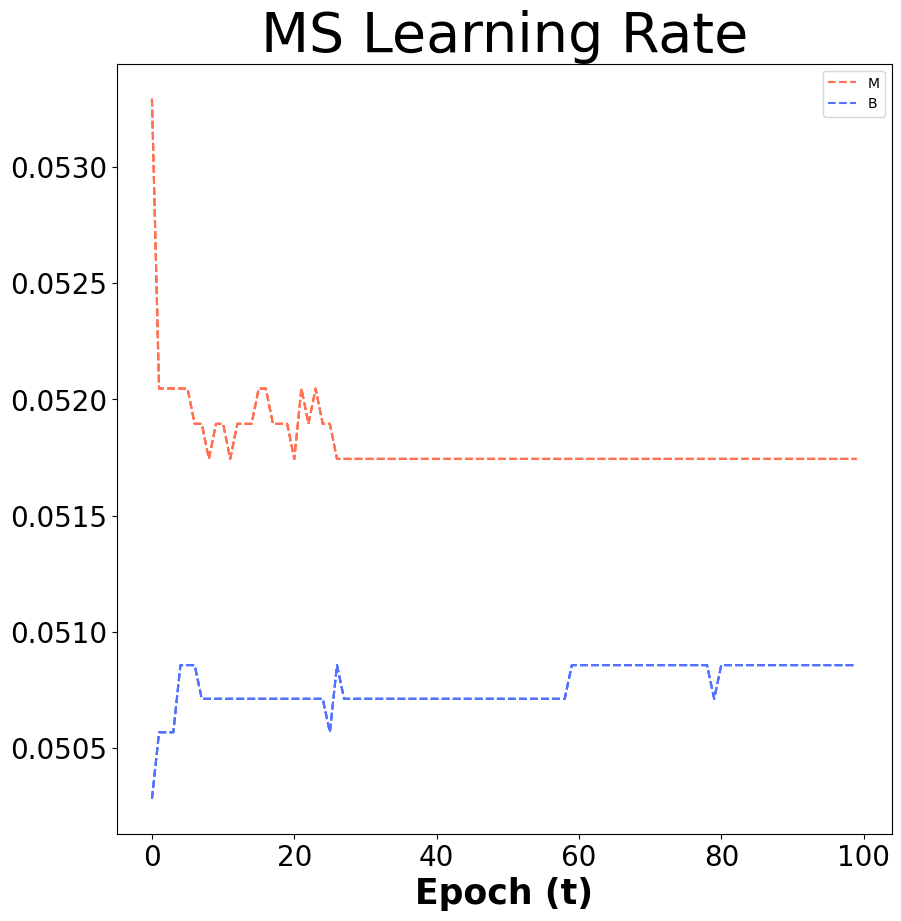

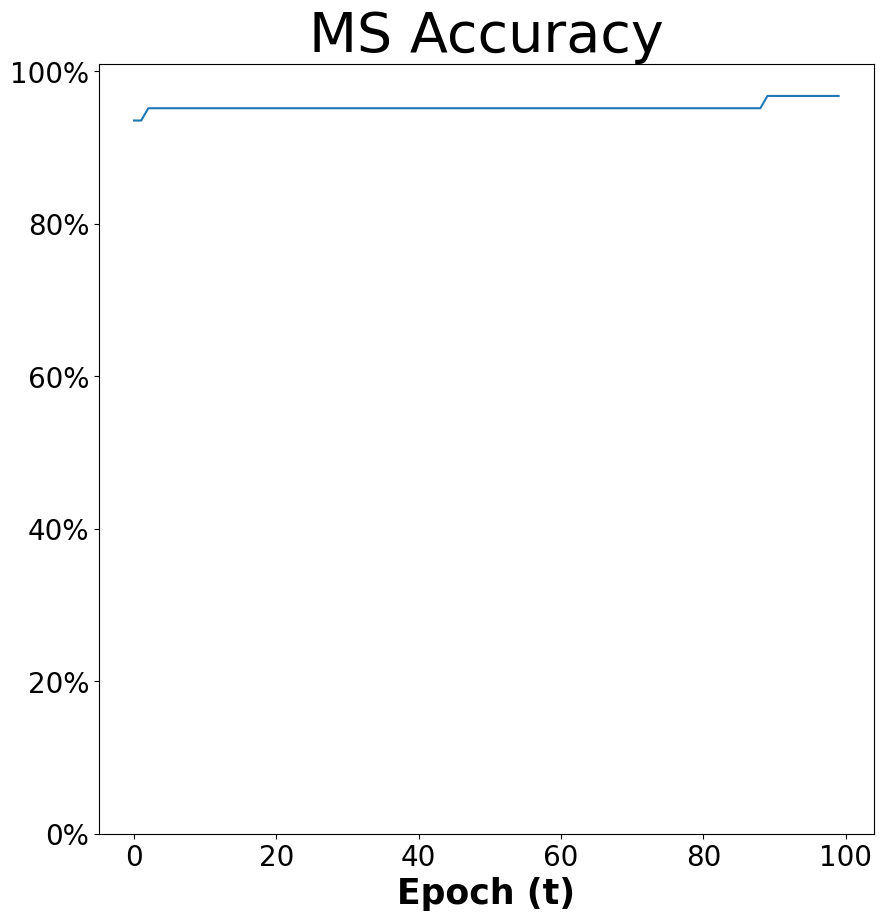

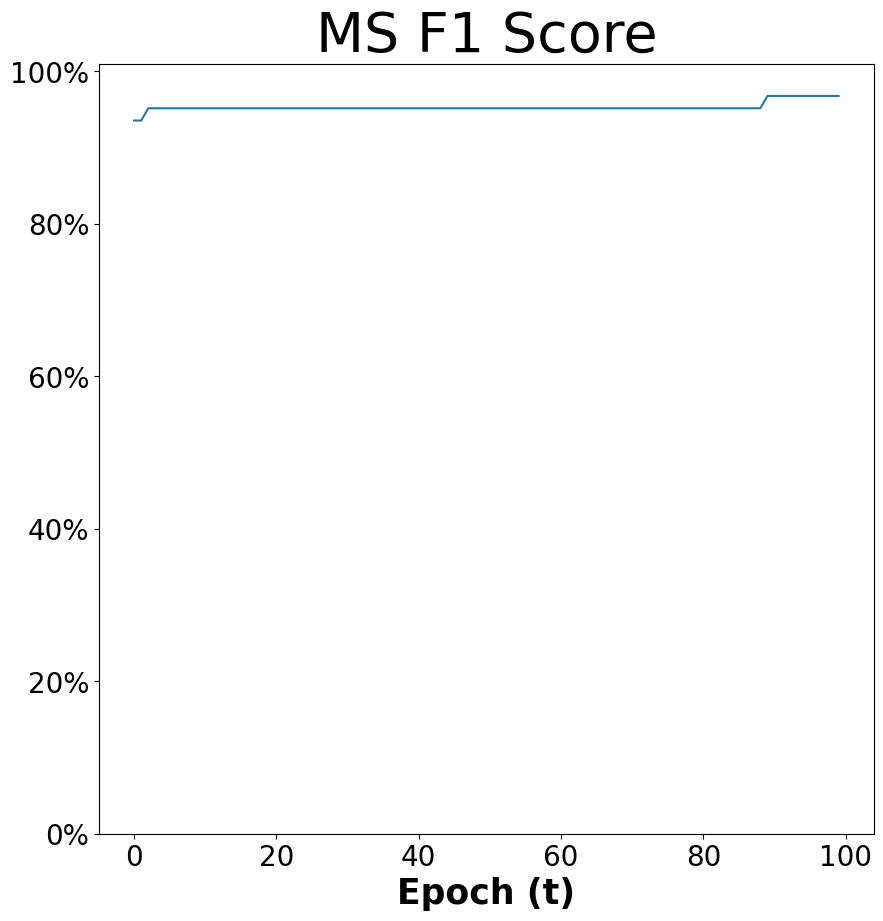

In [32]:
save_figs(ms_glvq_acc, experiment, "MS", learning_rate)

##### 2-step lr = 0.03

In [33]:
learning_rate = 0.03
ms_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = ms_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.middle_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3837, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 11, Loss: 0.3501, Accuracy: 96.77 %, F_1_score: 96.77 %
Epoch: 21, Loss: 0.3488, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 31, Loss: 0.3485, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 41, Loss: 0.3484, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 51, Loss: 0.3484, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 61, Loss: 0.3483, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 71, Loss: 0.3483, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 81, Loss: 0.3483, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 91, Loss: 0.3482, Accuracy: 95.16 %, F_1_score: 95.16 %


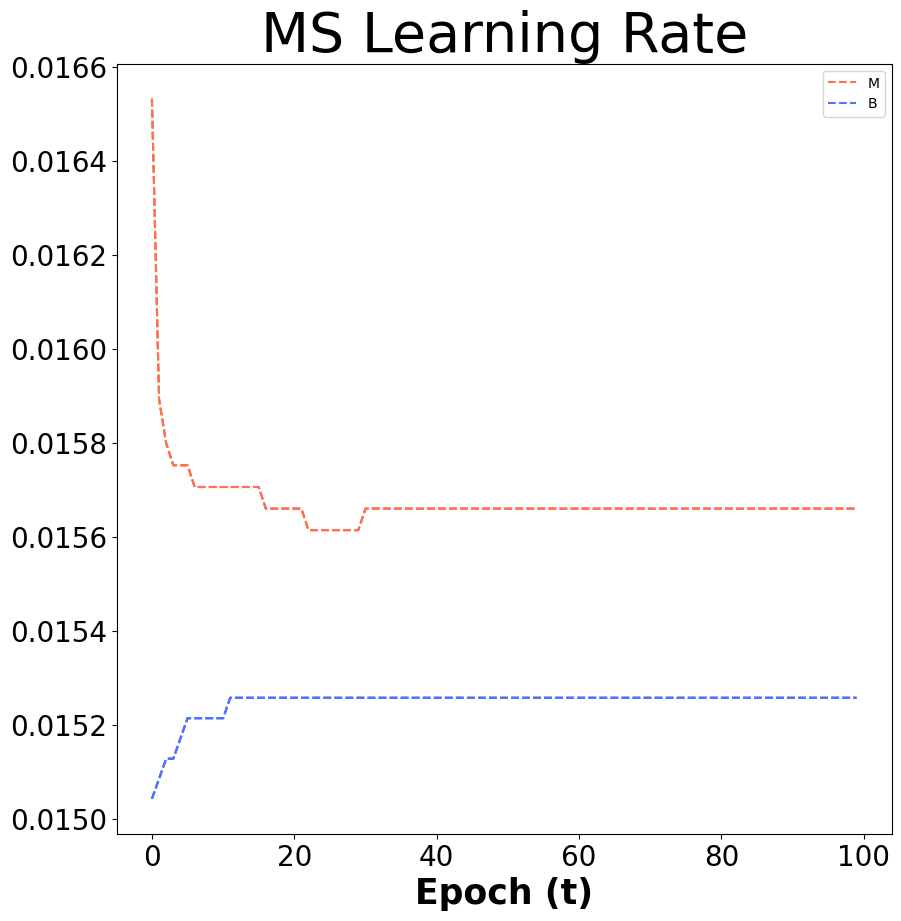

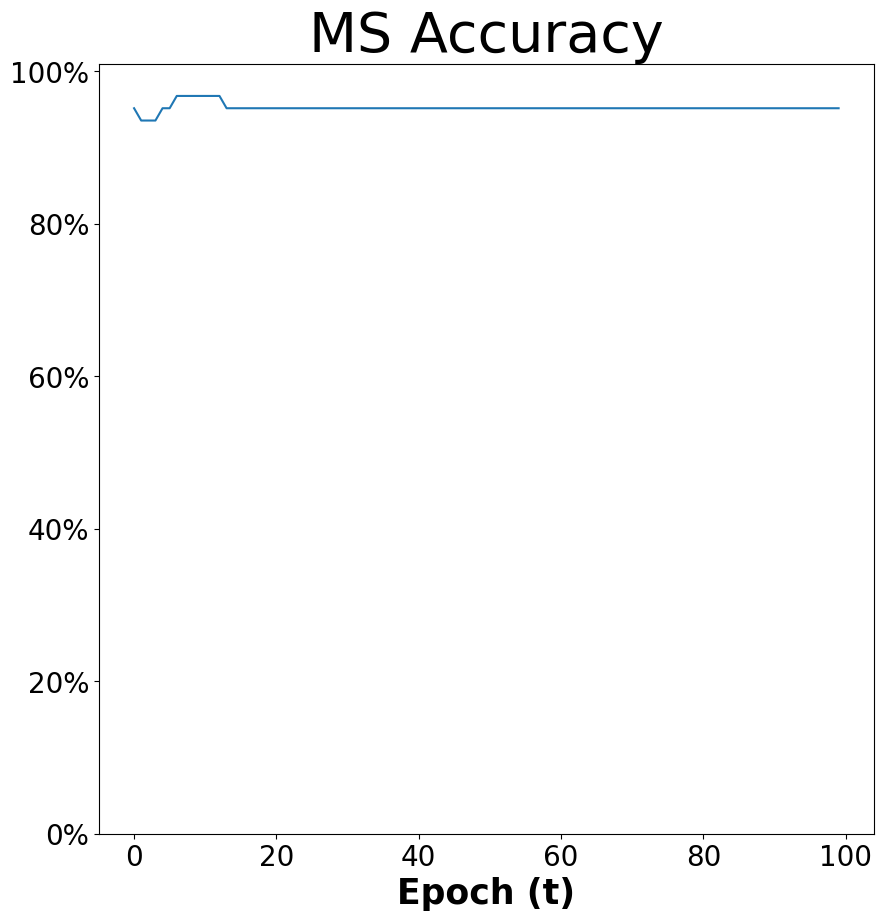

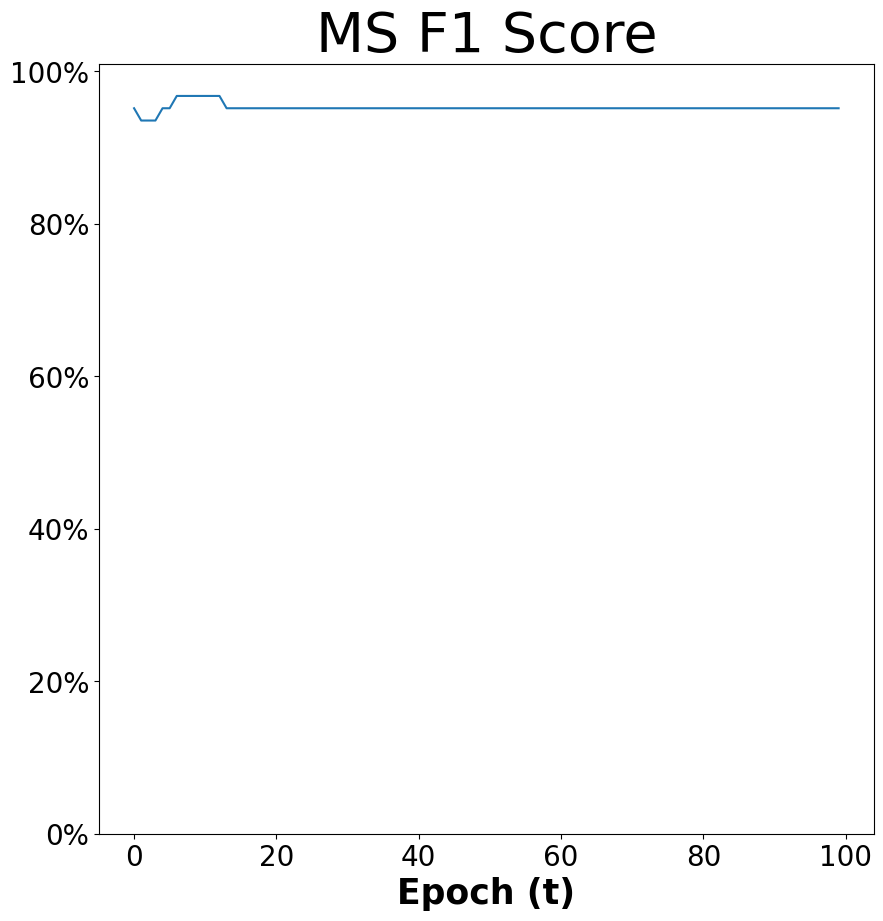

In [34]:
save_figs(ms_glvq_acc, experiment, "MS", learning_rate)

##### 3-step lr = 0.01

In [35]:
learning_rate = 0.01
ms_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = ms_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.middle_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4002, Accuracy: 90.32 %, F_1_score: 90.28 %
Epoch: 11, Loss: 0.3524, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 21, Loss: 0.3505, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 31, Loss: 0.3500, Accuracy: 96.77 %, F_1_score: 96.77 %
Epoch: 41, Loss: 0.3494, Accuracy: 96.77 %, F_1_score: 96.77 %
Epoch: 51, Loss: 0.3489, Accuracy: 96.77 %, F_1_score: 96.77 %
Epoch: 61, Loss: 0.3485, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 71, Loss: 0.3483, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 81, Loss: 0.3483, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 91, Loss: 0.3482, Accuracy: 95.16 %, F_1_score: 95.16 %


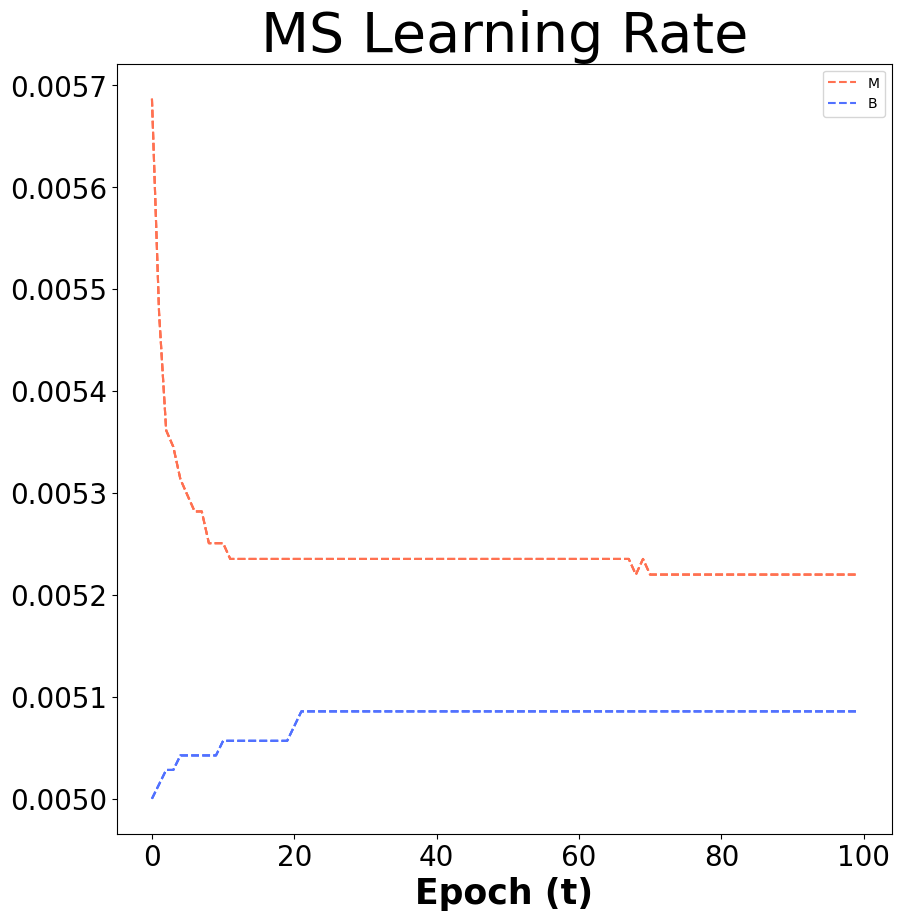

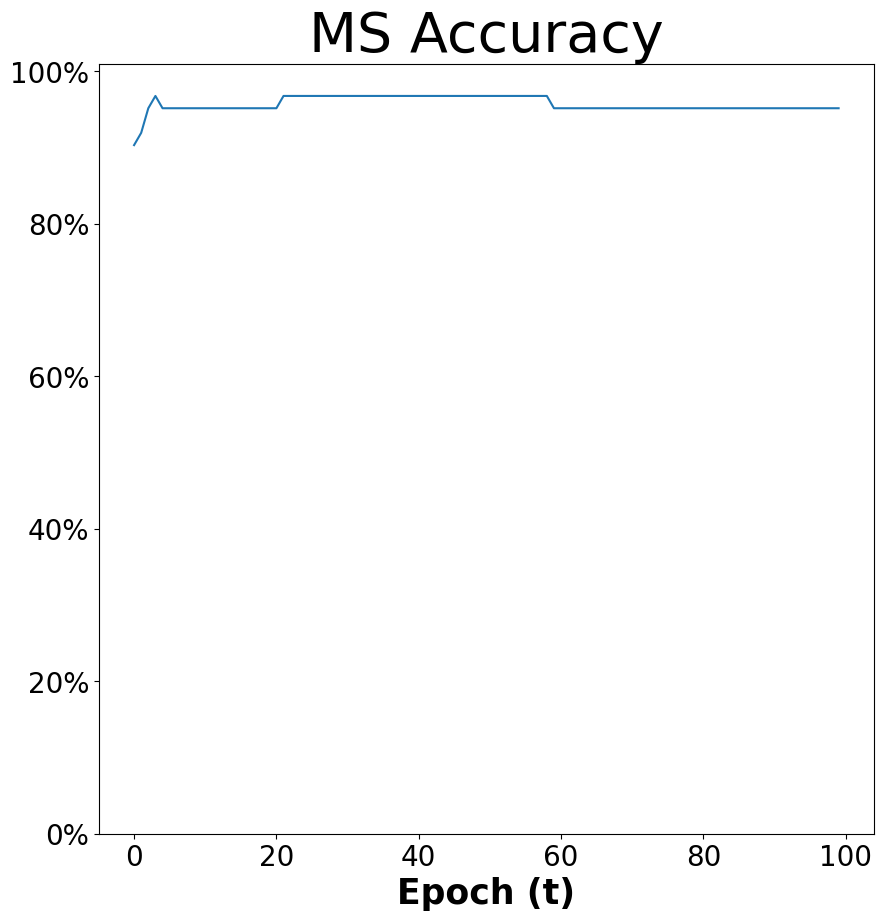

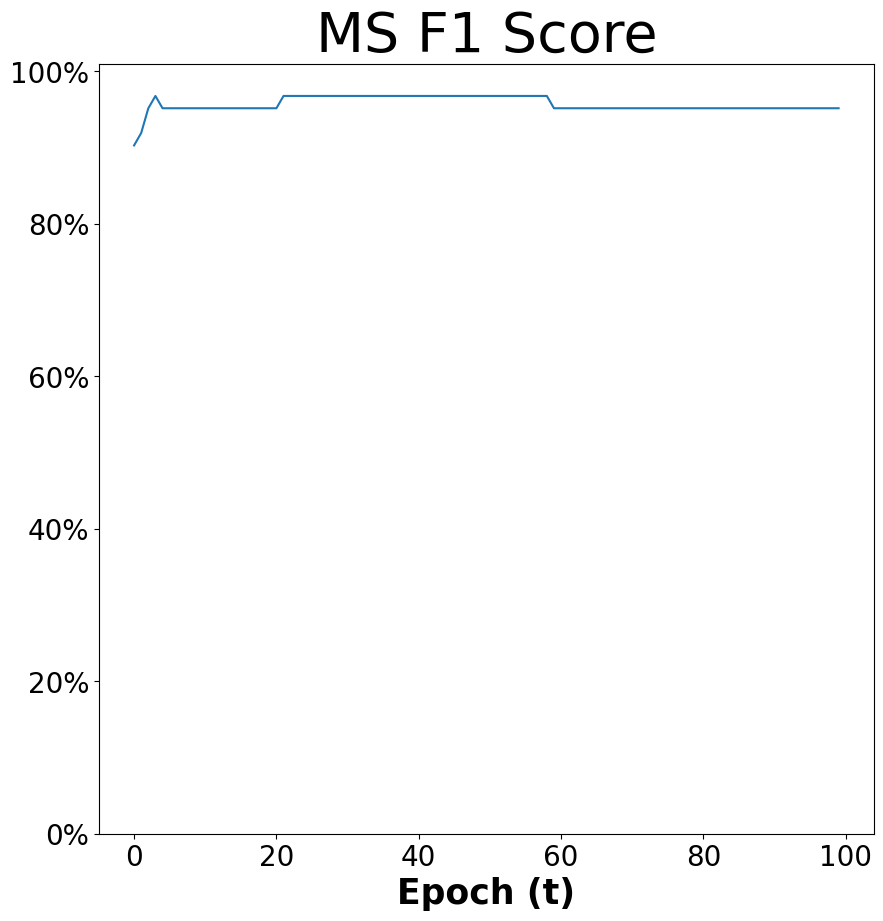

In [36]:
save_figs(ms_glvq_acc, experiment, "MS", learning_rate)

##### LS

##### 1-step lr = 0.1

In [37]:
learning_rate = 0.1
ls_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = ls_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.loose_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3709, Accuracy: 93.55 %, F_1_score: 93.55 %
Epoch: 11, Loss: 0.3492, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 21, Loss: 0.3488, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 31, Loss: 0.3488, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 41, Loss: 0.3487, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 51, Loss: 0.3486, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 61, Loss: 0.3485, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 71, Loss: 0.3485, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 81, Loss: 0.3485, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 91, Loss: 0.3484, Accuracy: 96.77 %, F_1_score: 96.77 %


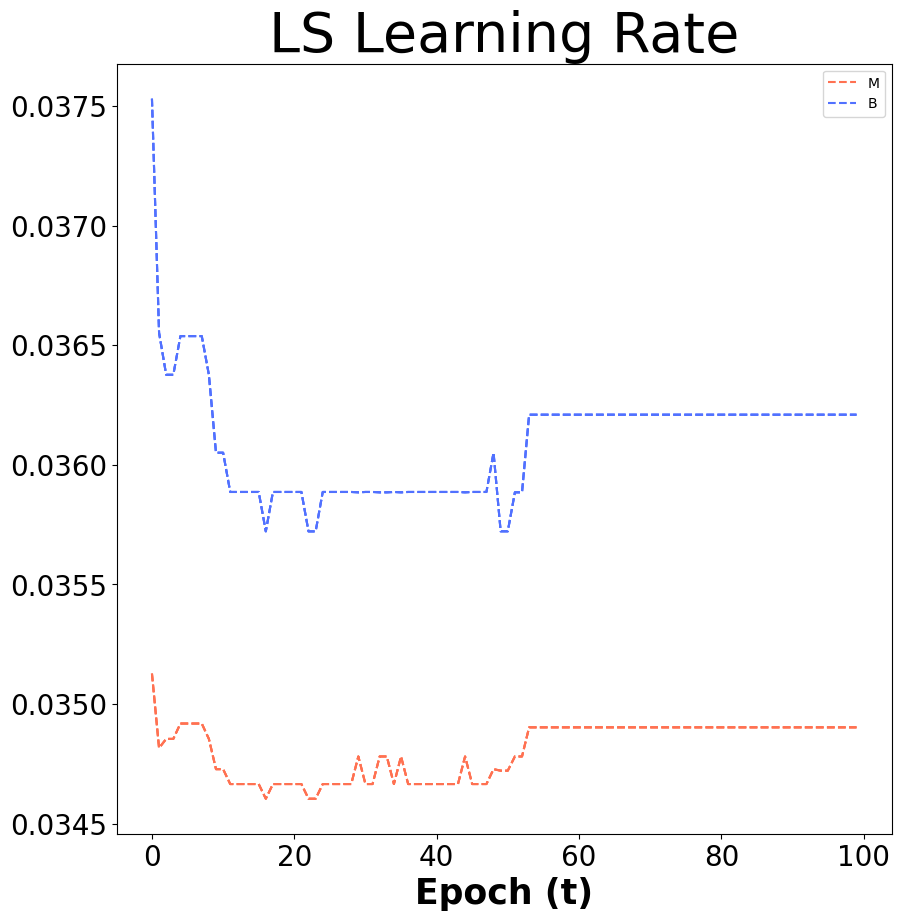

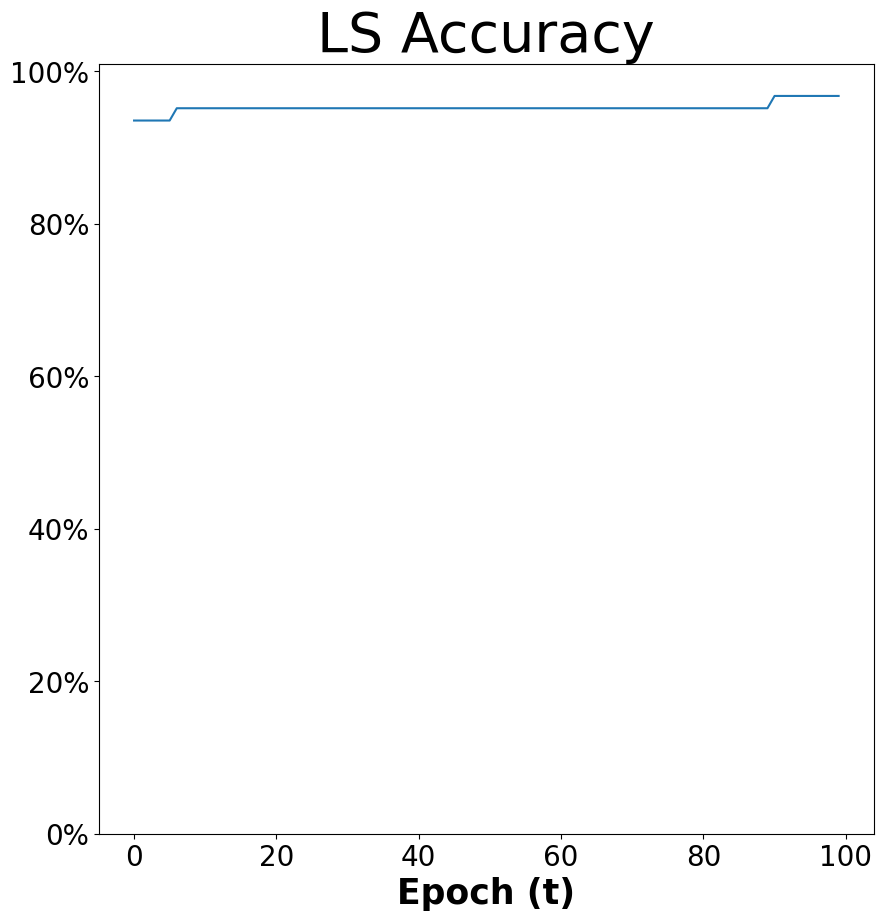

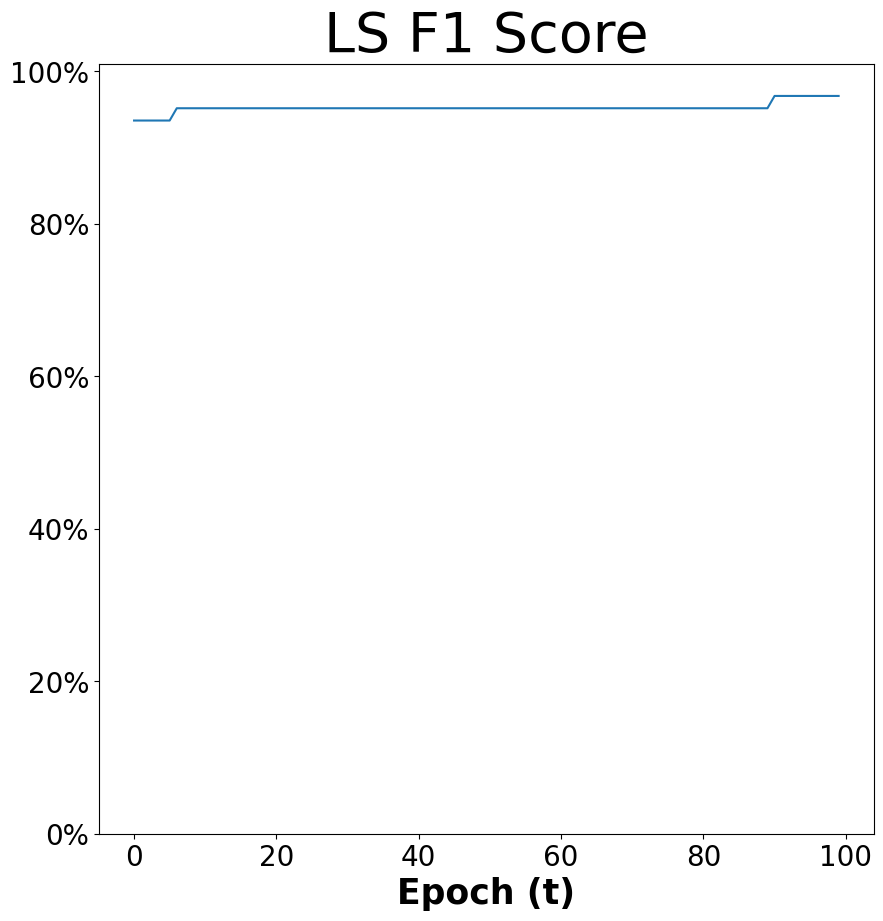

In [38]:
save_figs(ls_glvq_acc, experiment, "LS", learning_rate)

##### 2-step lr = 0.03

In [39]:
learning_rate = 0.03
ls_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = ls_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.loose_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3893, Accuracy: 93.55 %, F_1_score: 93.52 %
Epoch: 11, Loss: 0.3506, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 21, Loss: 0.3497, Accuracy: 96.77 %, F_1_score: 96.77 %
Epoch: 31, Loss: 0.3487, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 41, Loss: 0.3484, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 51, Loss: 0.3483, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 61, Loss: 0.3482, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 71, Loss: 0.3482, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 81, Loss: 0.3482, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 91, Loss: 0.3482, Accuracy: 95.16 %, F_1_score: 95.16 %


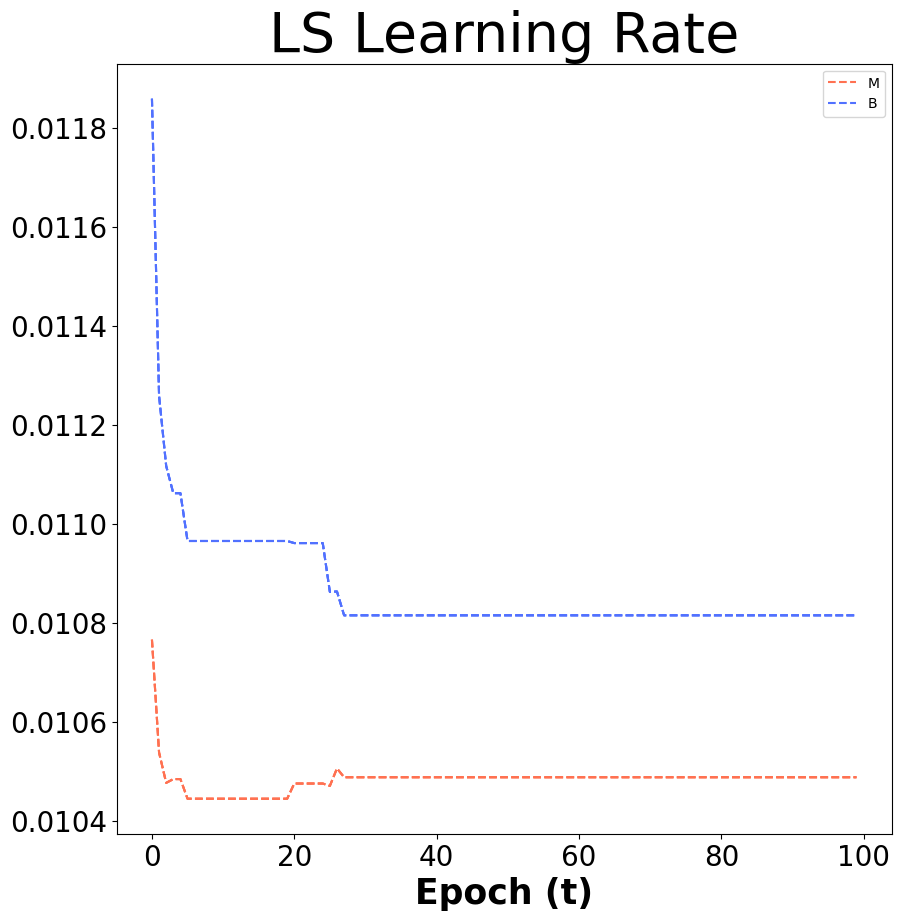

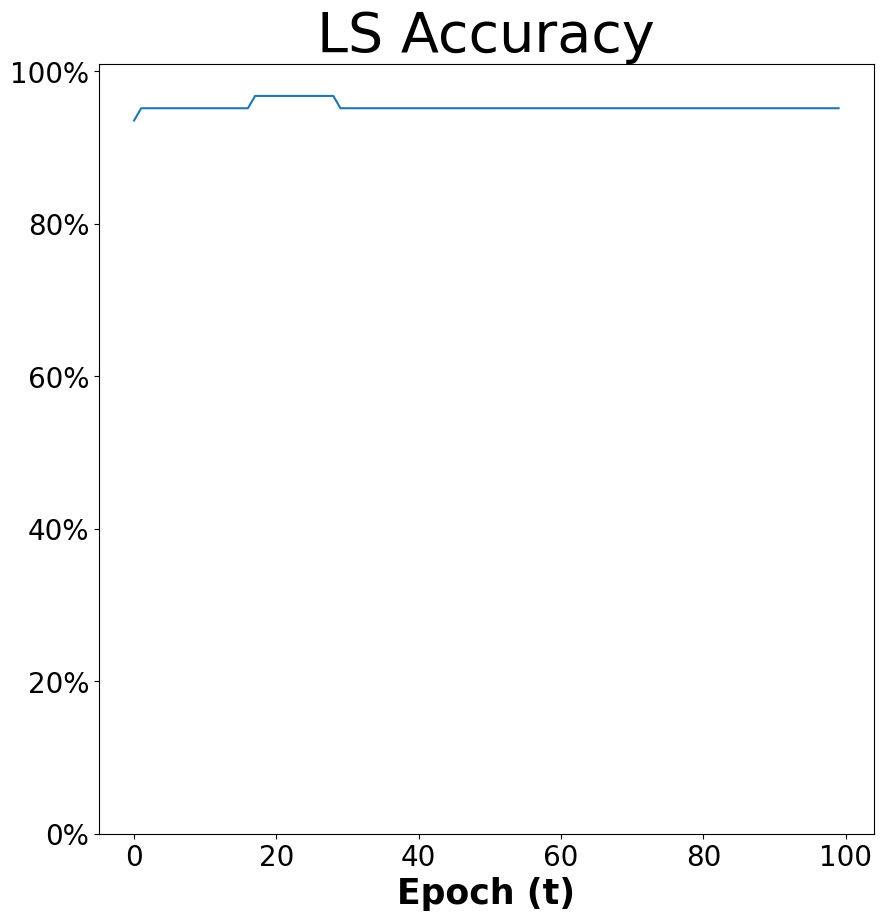

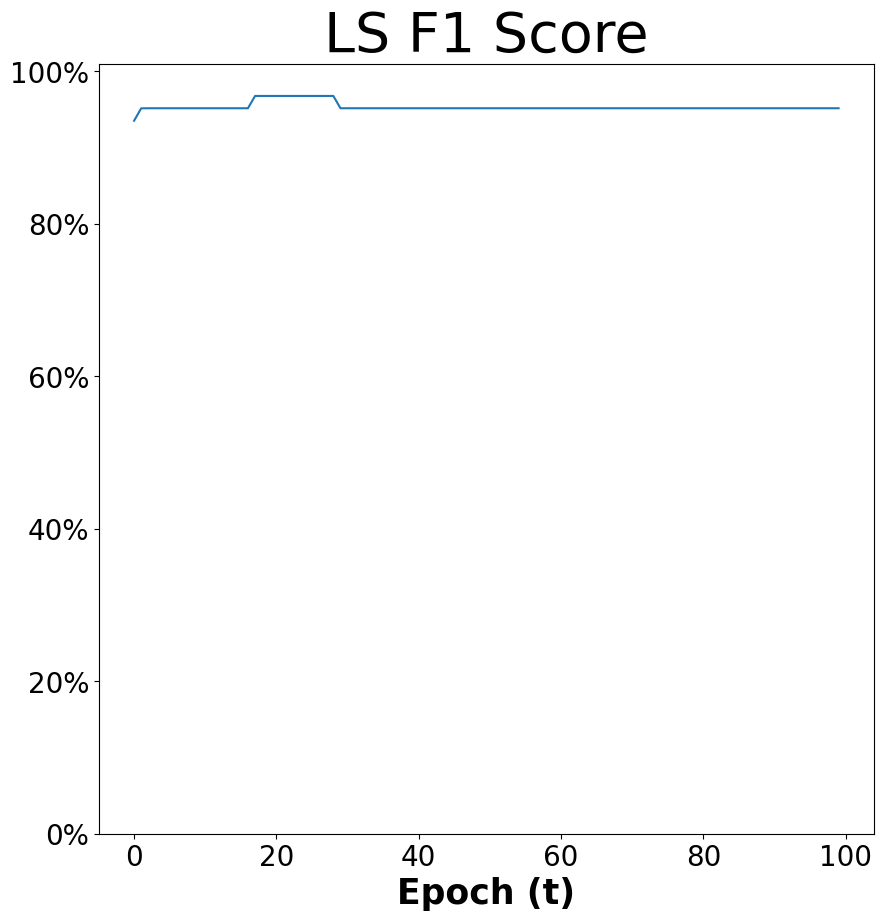

In [40]:
save_figs(ls_glvq_acc, experiment, "LS", learning_rate)

##### 3-step lr = 0.01

In [41]:
learning_rate = 0.01
ls_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = ls_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.loose_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4043, Accuracy: 87.10 %, F_1_score: 86.97 %
Epoch: 11, Loss: 0.3547, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 21, Loss: 0.3513, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 31, Loss: 0.3504, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 41, Loss: 0.3500, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 51, Loss: 0.3497, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 61, Loss: 0.3494, Accuracy: 96.77 %, F_1_score: 96.77 %
Epoch: 71, Loss: 0.3491, Accuracy: 96.77 %, F_1_score: 96.77 %
Epoch: 81, Loss: 0.3487, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 91, Loss: 0.3485, Accuracy: 95.16 %, F_1_score: 95.16 %


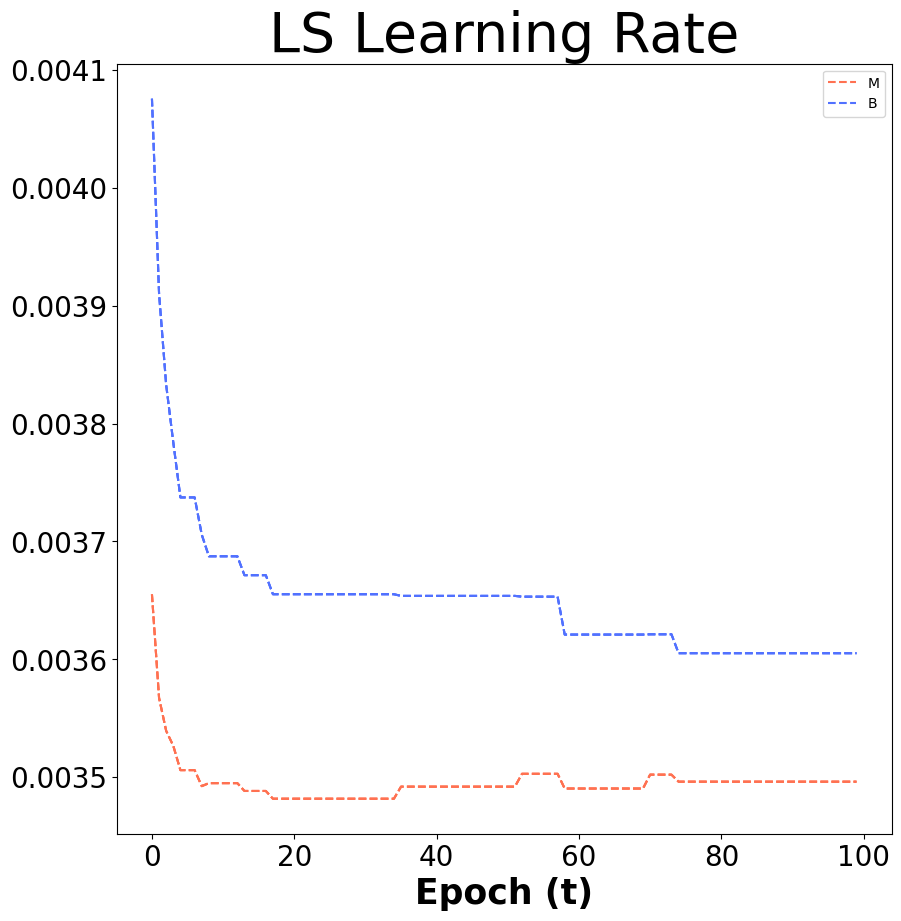

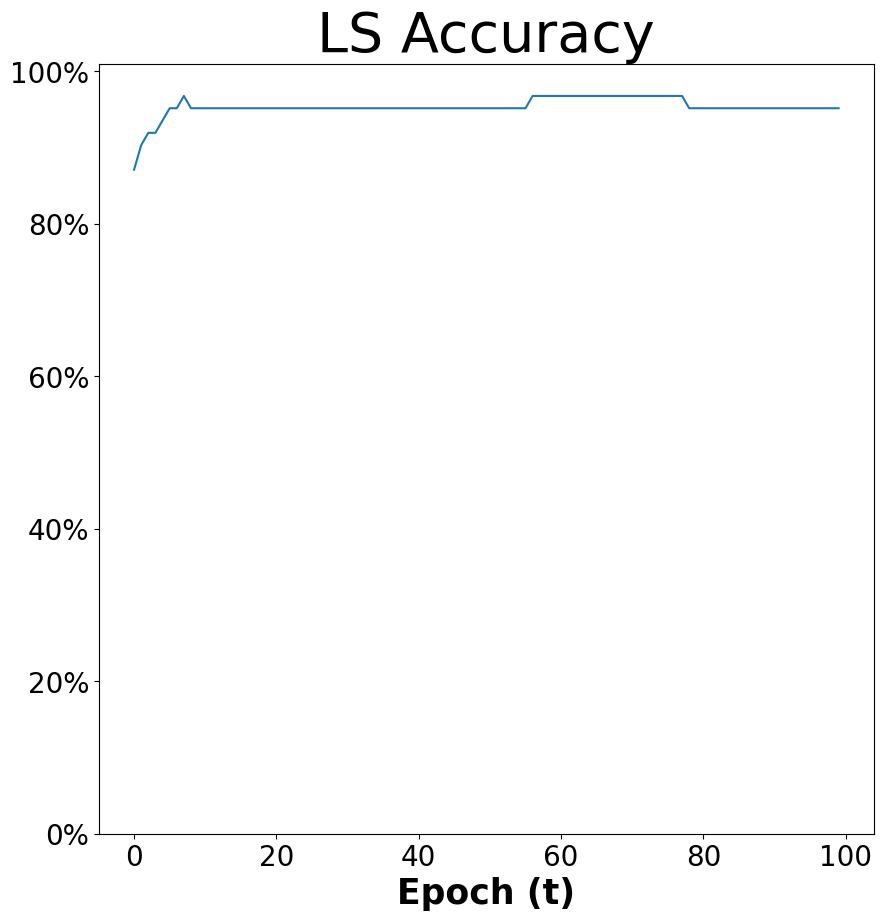

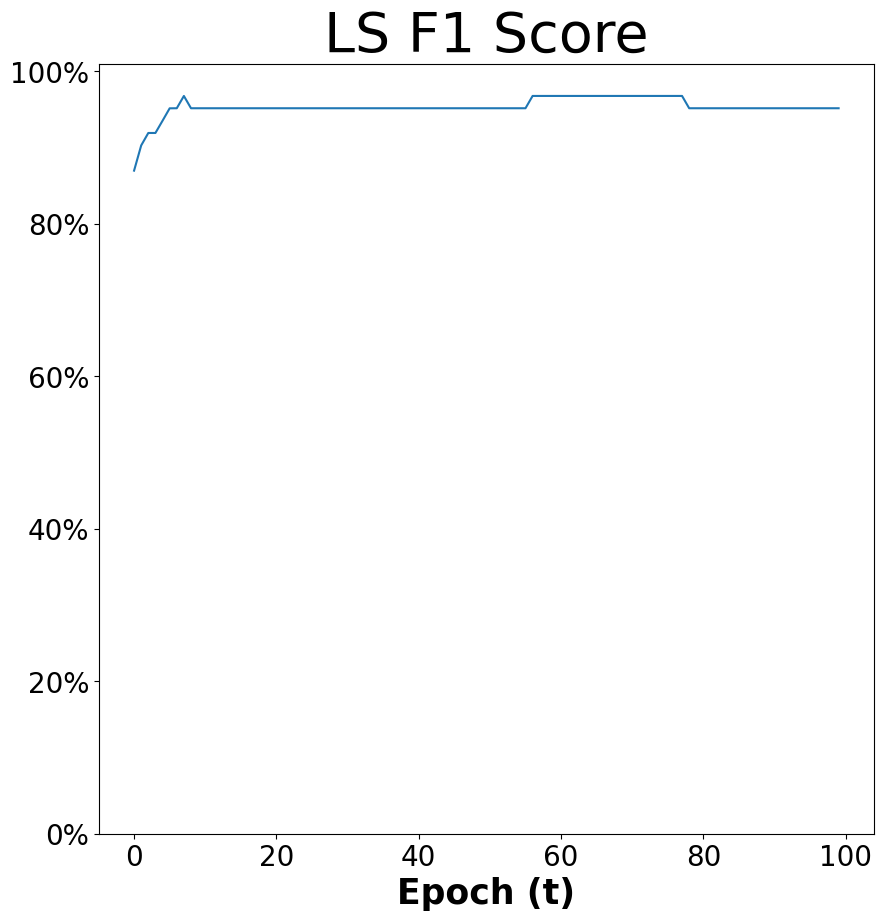

In [42]:
save_figs(ls_glvq_acc, experiment, "LS", learning_rate)

##### LSR

##### 1-step lr = 0.1

In [43]:
learning_rate = 0.1
lsr_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = lsr_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.loose_symmetry_rarity,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3717, Accuracy: 93.55 %, F_1_score: 93.55 %
Epoch: 11, Loss: 0.3492, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 21, Loss: 0.3487, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 31, Loss: 0.3486, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 41, Loss: 0.3486, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 51, Loss: 0.3485, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 61, Loss: 0.3485, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 71, Loss: 0.3485, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 81, Loss: 0.3484, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 91, Loss: 0.3484, Accuracy: 95.16 %, F_1_score: 95.16 %


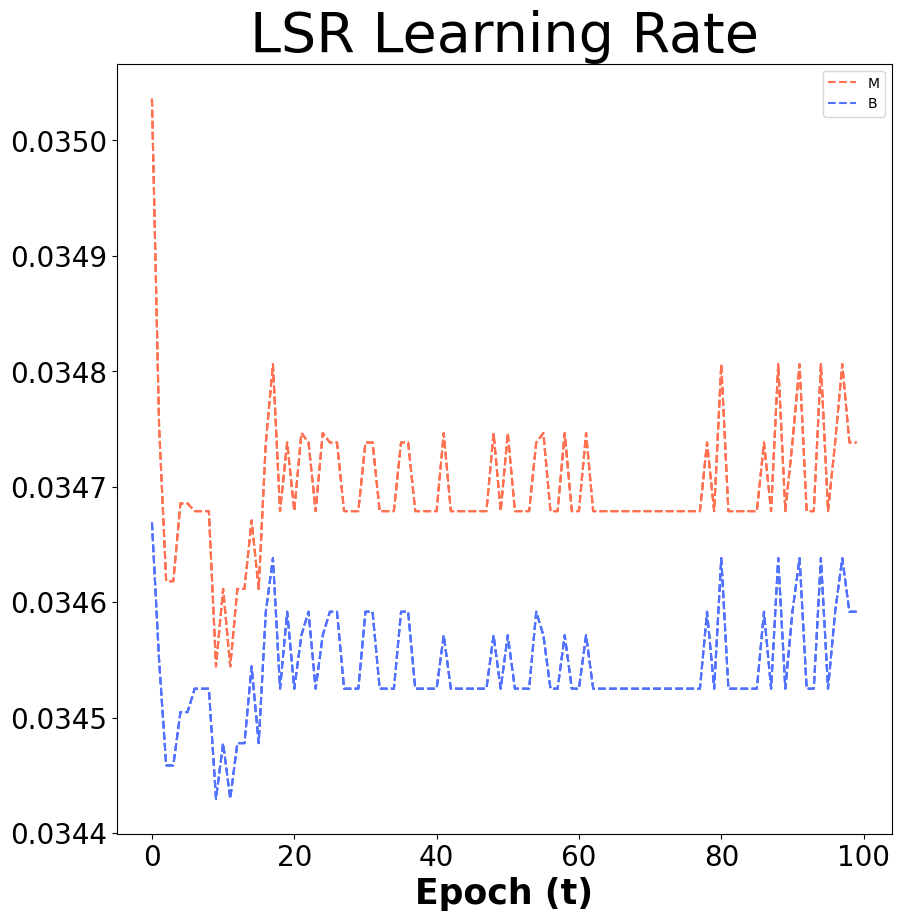

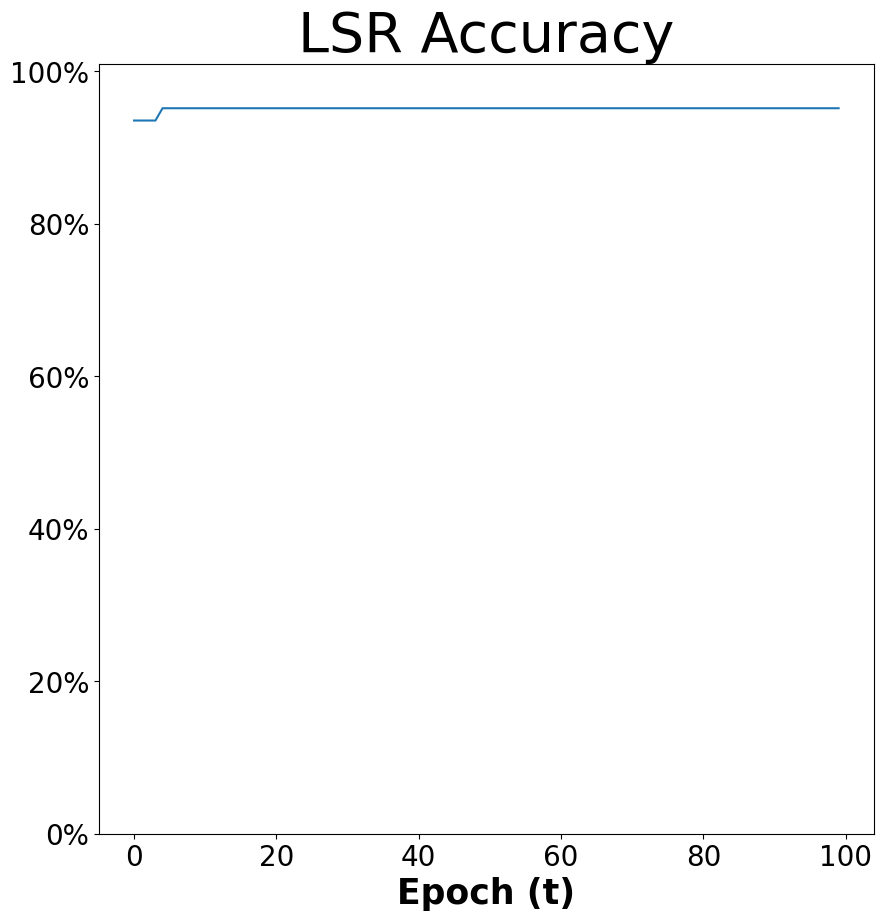

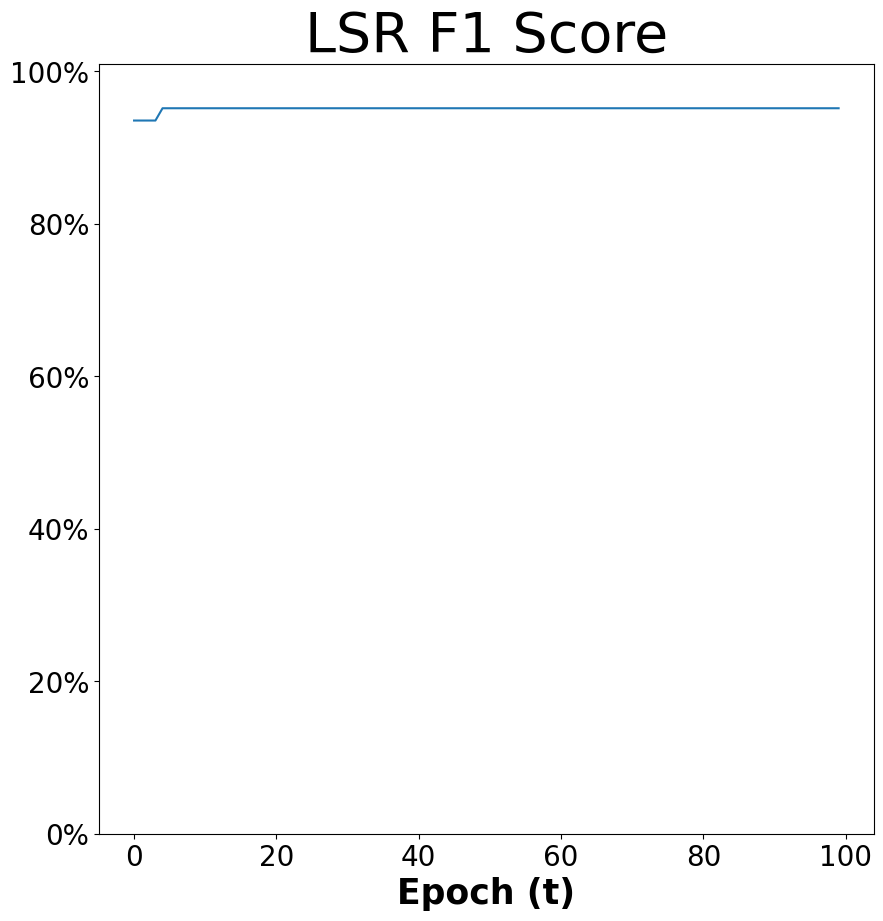

In [44]:
save_figs(lsr_glvq_acc, experiment, "LSR", learning_rate)

##### 2-step lr = 0.03

In [45]:
learning_rate = 0.03
lsr_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = lsr_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.loose_symmetry_rarity,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3902, Accuracy: 93.55 %, F_1_score: 93.52 %
Epoch: 11, Loss: 0.3506, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 21, Loss: 0.3497, Accuracy: 96.77 %, F_1_score: 96.77 %
Epoch: 31, Loss: 0.3487, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 41, Loss: 0.3484, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 51, Loss: 0.3483, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 61, Loss: 0.3482, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 71, Loss: 0.3482, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 81, Loss: 0.3482, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 91, Loss: 0.3482, Accuracy: 95.16 %, F_1_score: 95.16 %


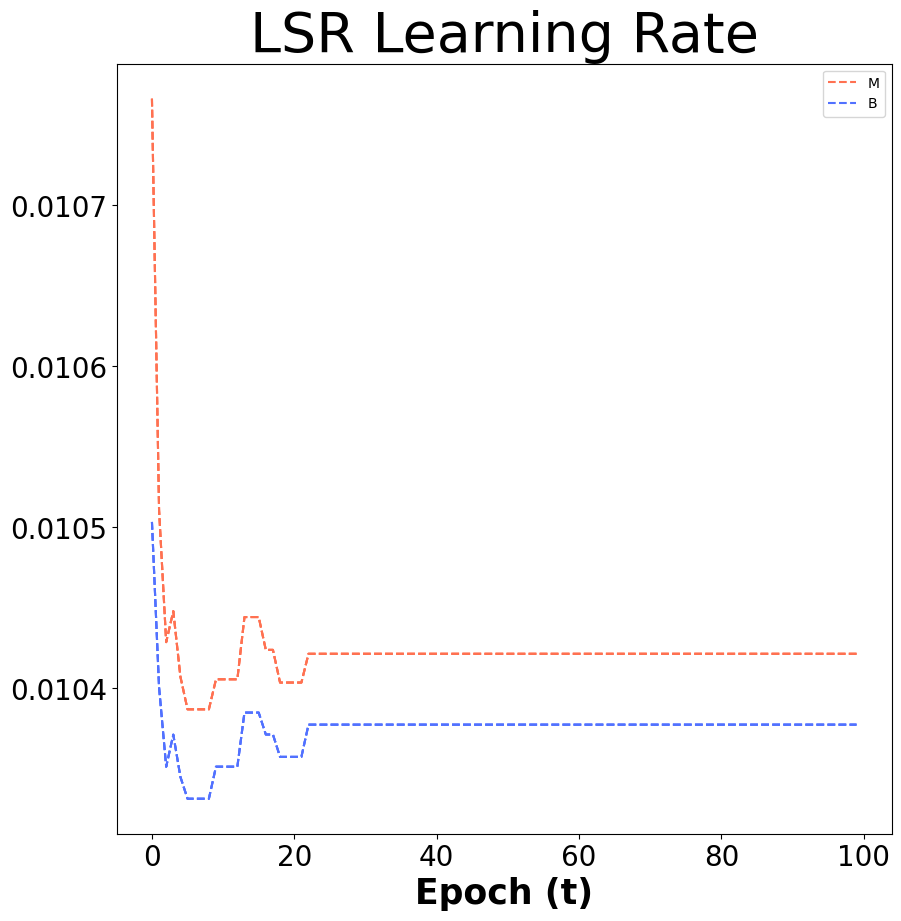

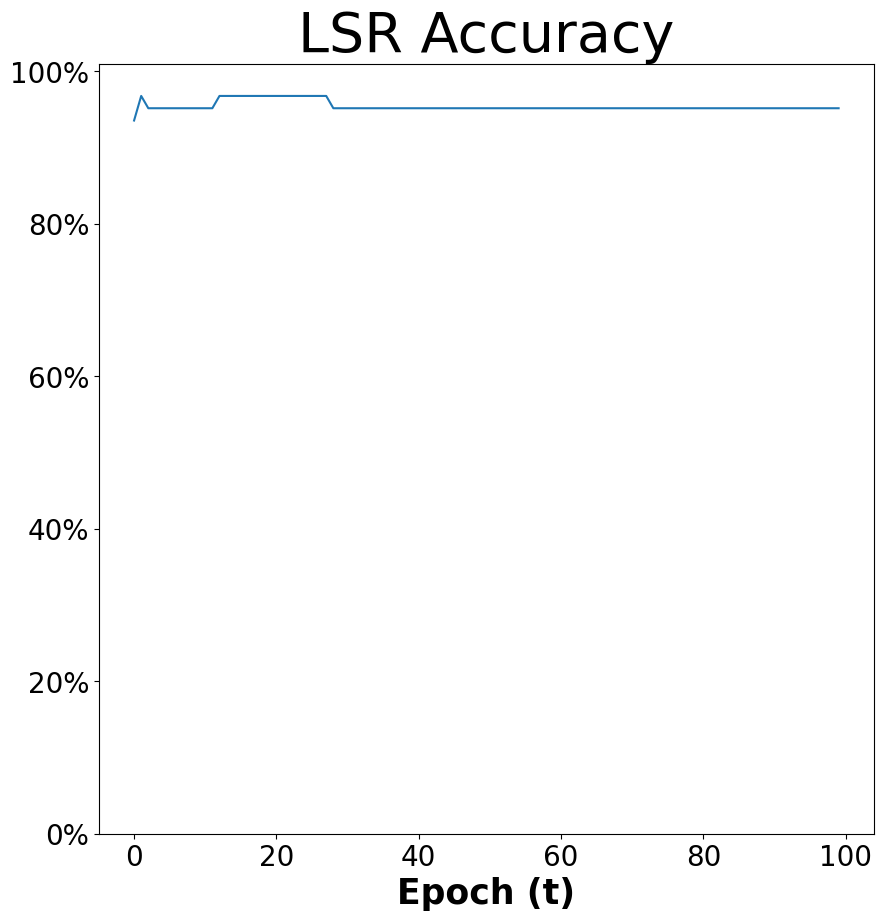

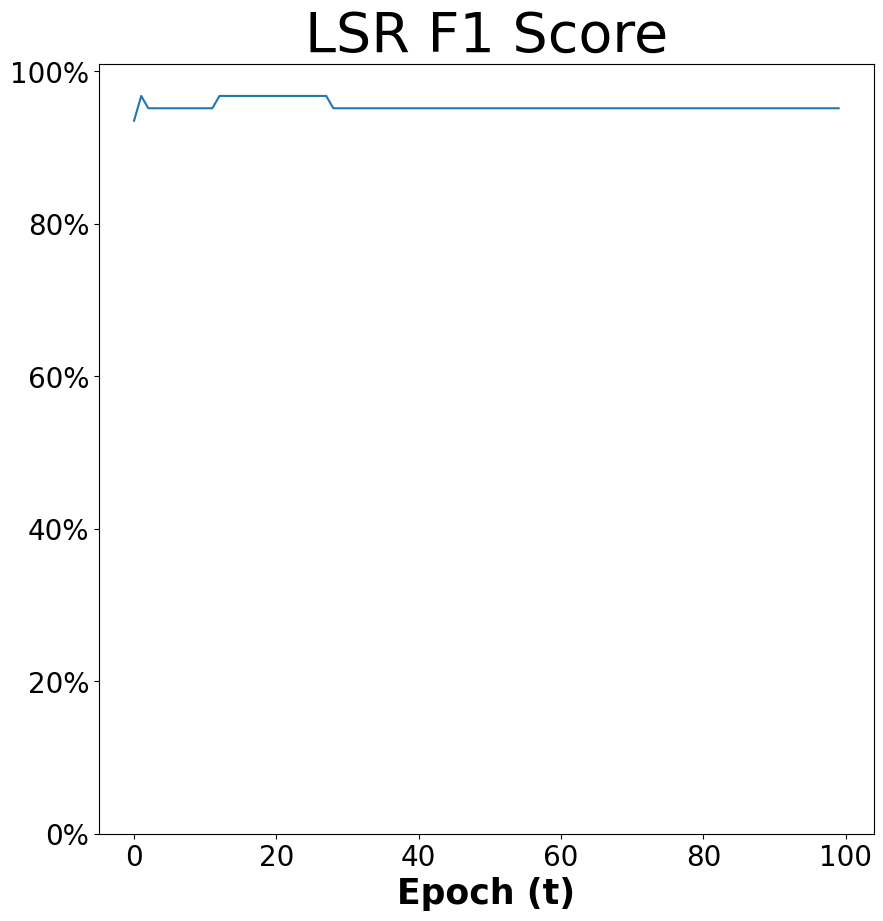

In [46]:
save_figs(lsr_glvq_acc, experiment, "LSR", learning_rate)

##### 3-step lr = 0.01

In [47]:
learning_rate = 0.01
lsr_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = lsr_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.loose_symmetry_rarity,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4048, Accuracy: 87.10 %, F_1_score: 86.97 %
Epoch: 11, Loss: 0.3549, Accuracy: 93.55 %, F_1_score: 93.55 %
Epoch: 21, Loss: 0.3514, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 31, Loss: 0.3504, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 41, Loss: 0.3500, Accuracy: 96.77 %, F_1_score: 96.77 %
Epoch: 51, Loss: 0.3497, Accuracy: 96.77 %, F_1_score: 96.77 %
Epoch: 61, Loss: 0.3494, Accuracy: 96.77 %, F_1_score: 96.77 %
Epoch: 71, Loss: 0.3490, Accuracy: 96.77 %, F_1_score: 96.77 %
Epoch: 81, Loss: 0.3487, Accuracy: 95.16 %, F_1_score: 95.16 %
Epoch: 91, Loss: 0.3485, Accuracy: 95.16 %, F_1_score: 95.16 %


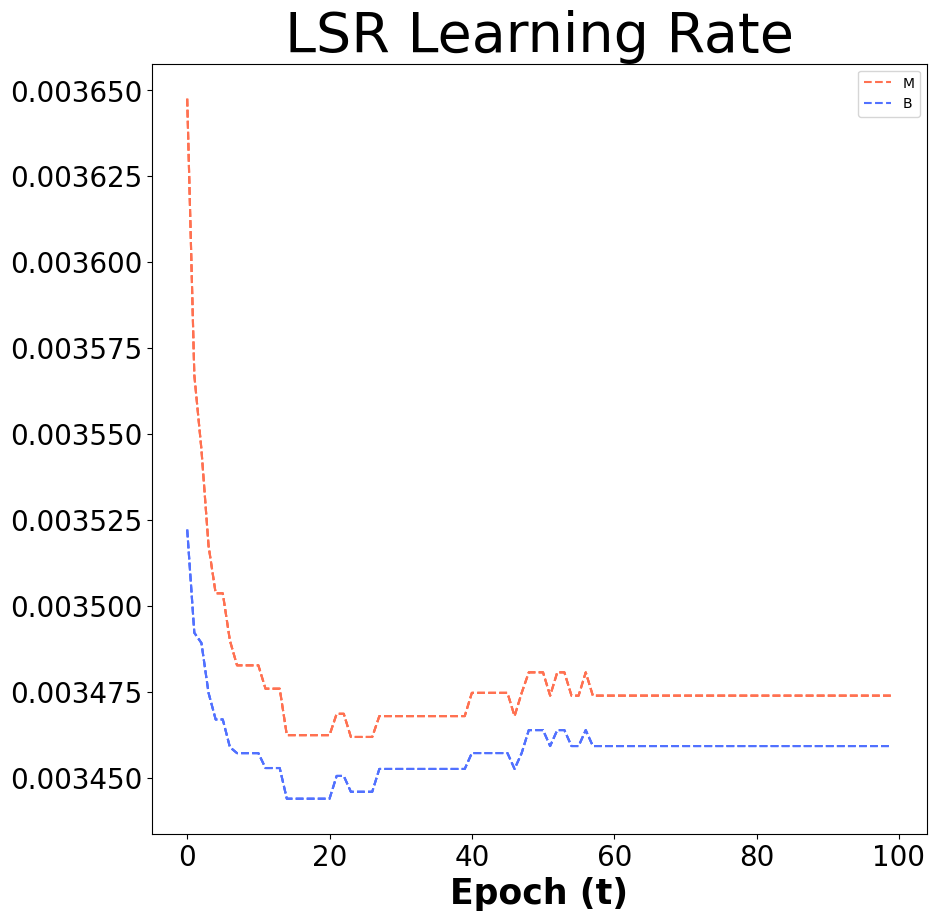

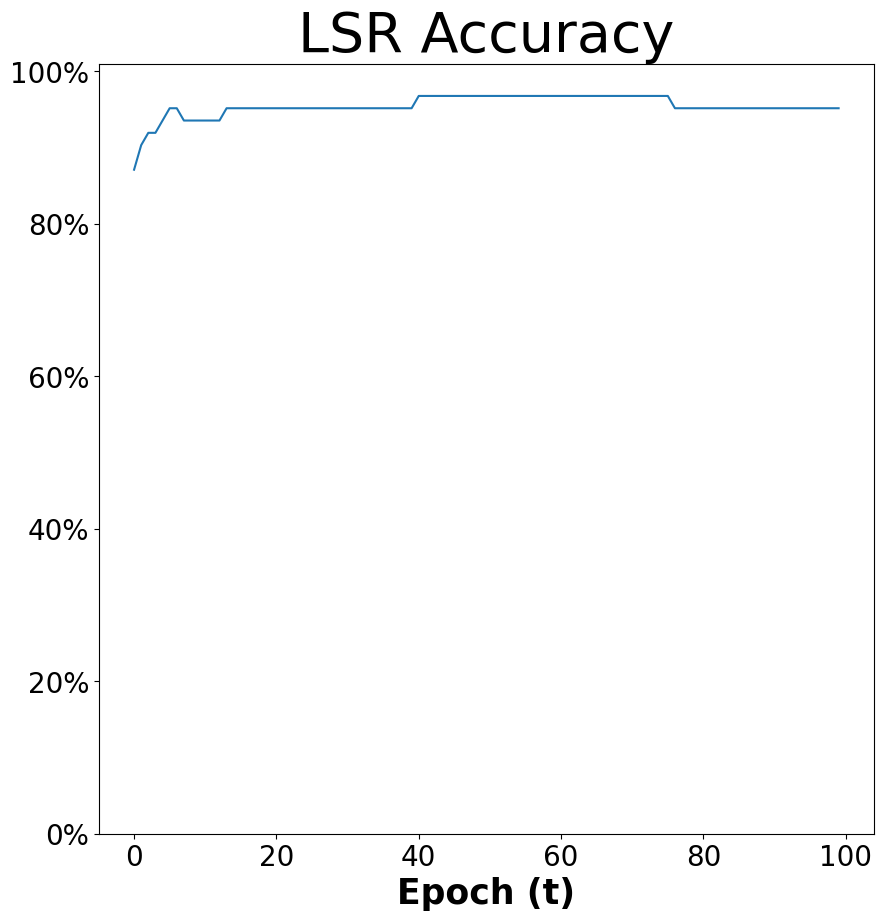

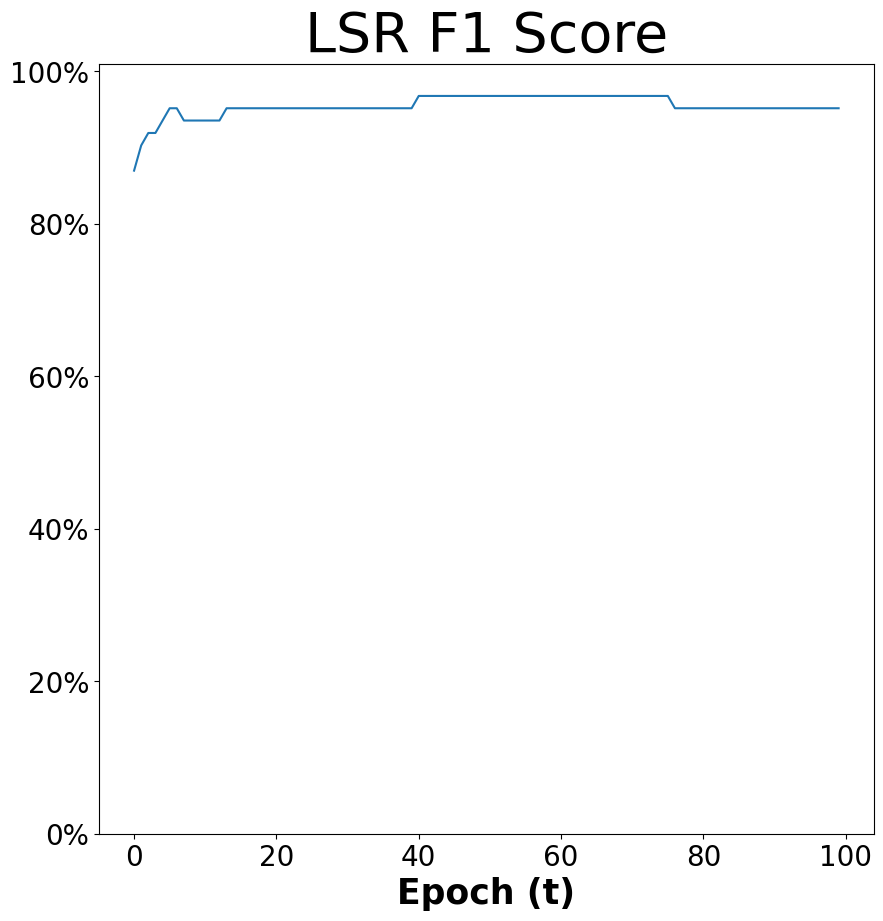

In [48]:
save_figs(lsr_glvq_acc, experiment, "LSR", learning_rate)

##### F1 Score

In [51]:
experiment = "experiment_2"

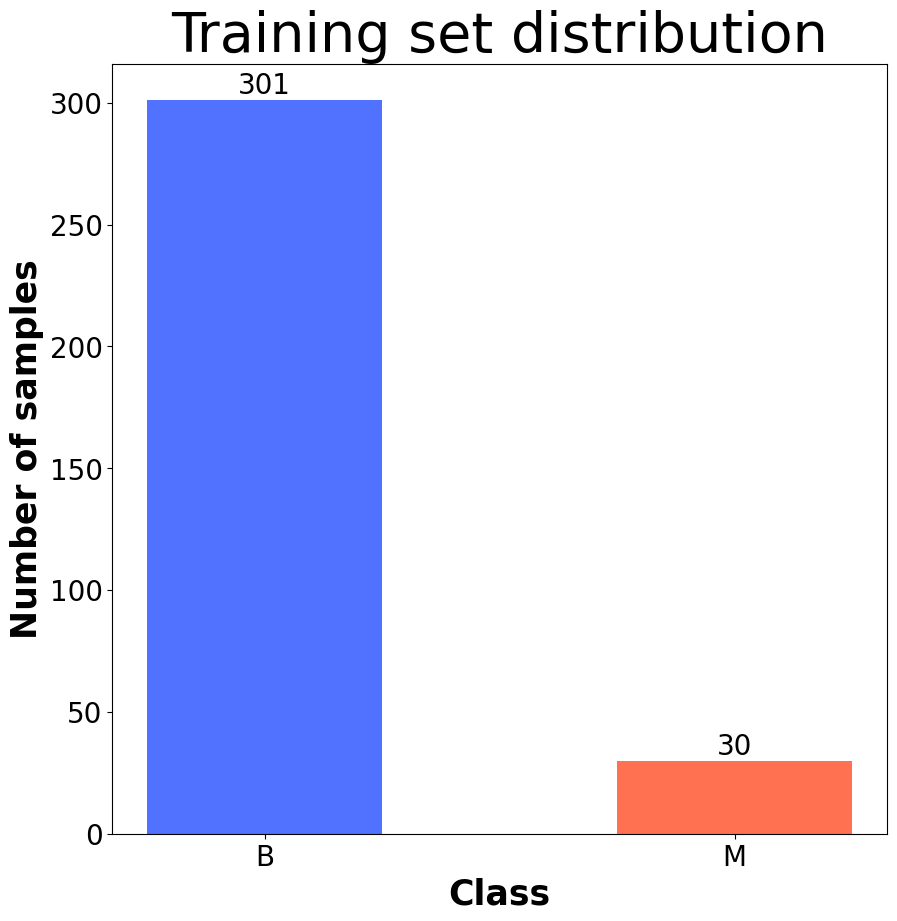

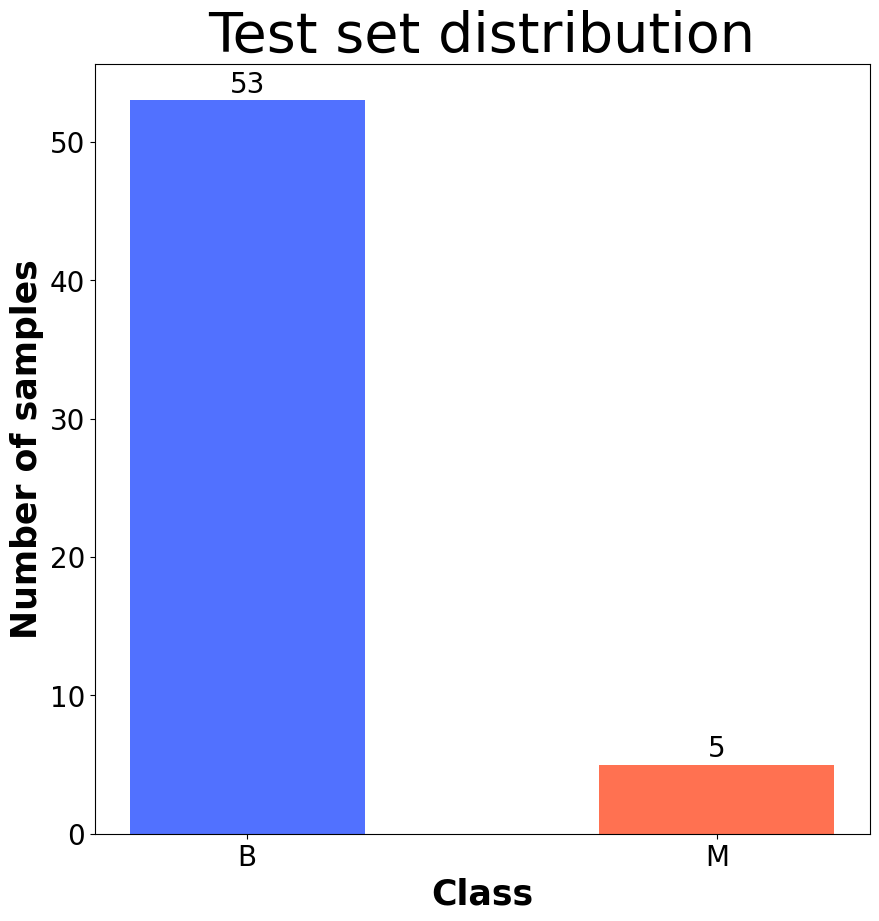

In [52]:
# Select 10% of #sample-1 as #sample-2
max_data = max(count) - num_prototypes
data_per_class = [max_data, int(max_data / 10)]
test_percentage = 0.15
test_size = list(map(lambda data: int(data * test_percentage), data_per_class))
train_size = [data - test for data, test in zip(data_per_class, test_size)]
feature_f1 = copy.deepcopy(feature)
label_f1 = copy.deepcopy(label)

## Select test set
test_index = []
for j, class_name in enumerate(sample_number):
    index_i = np.where(label_f1 == class_name)
    index_i = list(index_i[0])
    index_i_sample = random.sample(index_i, test_size[j])
    test_index += index_i_sample
test_index.sort(reverse=True)
test_set_fscore = [(feature_f1[i], label_f1[i]) for i in test_index]
random.shuffle(test_set_fscore)
unique, counts = np.unique(label_f1[test_index], return_counts=True)
test_dist = dict(zip(unique, counts))
feature_f1 = np.delete(feature_f1, test_index, axis=0)
label_f1 = np.delete(label_f1, test_index, axis=0)

## Select train set
train_index = []
for j, class_name in enumerate(sample_number):
    index_i = np.where(label_f1 == class_name)
    index_i = list(index_i[0])
    index_i_sample = random.sample(index_i, train_size[j])
    train_index += index_i_sample
train_index.sort(reverse=True)
train_set_fscore = [(feature_f1[i], label_f1[i]) for i in train_index]
random.shuffle(train_set_fscore)
unique, counts = np.unique(label_f1[train_index], return_counts=True)
train_dist = dict(zip(unique, counts))

fig, ax = plt.subplots(figsize=(10, 10))
for i, (k, v) in enumerate(train_dist.items()):
    ax.bar(k, v, width=0.5, color=colors[i])
    plt.text(k, v + 0.1, str(v), ha="center", va="bottom", fontsize=20)
plt.title("Training set distribution", fontsize=40)
plt.xlabel("Class", fontsize=25, weight="bold")
plt.ylabel("Number of samples", fontsize=25, weight="bold")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()
fig.savefig(img_folder + experiment + "/" + data_name + "/train_dist.png", dpi=200)

fig, ax = plt.subplots(figsize=(10, 10))
for i, (k, v) in enumerate(test_dist.items()):
    ax.bar(k, v, width=0.5, color=colors[i])
    plt.text(k, v + 0.1, str(v), ha="center", va="bottom", fontsize=20)
plt.title("Test set distribution", fontsize=40)
plt.xlabel("Class", fontsize=25, weight="bold")
plt.ylabel("Number of samples", fontsize=25, weight="bold")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()
fig.savefig(img_folder + experiment + "/" + data_name + "/test_dist.png", dpi=200)

#### Train the Models

In [53]:
num_epochs = 100

##### GLVQ

##### 1-step lr =0.1

In [54]:
learning_rate = 0.1
oglvq_fscore = oglvq.OGLVQ(prototypes, learning_rate)
hist = oglvq_fscore.train(
    num_epochs, train_set_fscore, test_set_fscore, sample_number=train_dist
)


Epoch: 1, Loss: 109.1938, Accuracy: 96.55 %, F_1_score: 96.05 %
Epoch: 11, Loss: 102.9069, Accuracy: 93.10 %, F_1_score: 90.65 %
Epoch: 21, Loss: 102.7147, Accuracy: 93.10 %, F_1_score: 90.65 %
Epoch: 31, Loss: 102.6478, Accuracy: 93.10 %, F_1_score: 90.65 %
Epoch: 41, Loss: 102.6138, Accuracy: 91.38 %, F_1_score: 86.84 %
Epoch: 51, Loss: 102.5936, Accuracy: 91.38 %, F_1_score: 86.84 %
Epoch: 61, Loss: 102.5801, Accuracy: 91.38 %, F_1_score: 86.84 %
Epoch: 71, Loss: 102.5705, Accuracy: 91.38 %, F_1_score: 86.84 %
Epoch: 81, Loss: 102.5633, Accuracy: 91.38 %, F_1_score: 86.84 %
Epoch: 91, Loss: 102.5575, Accuracy: 91.38 %, F_1_score: 86.84 %


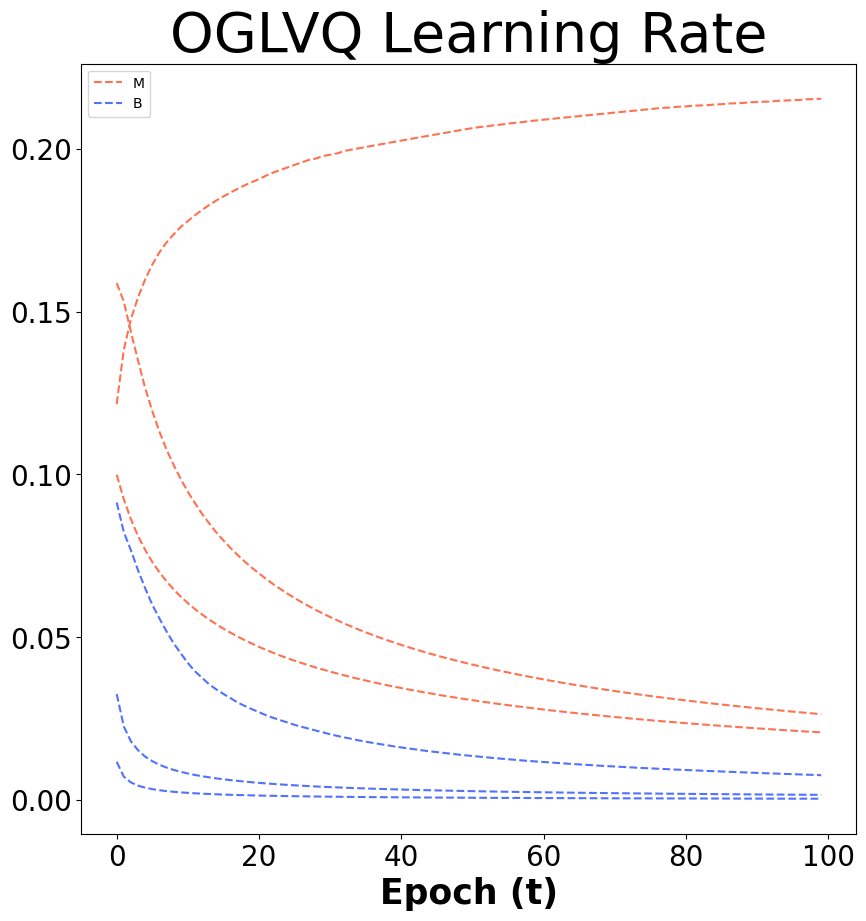

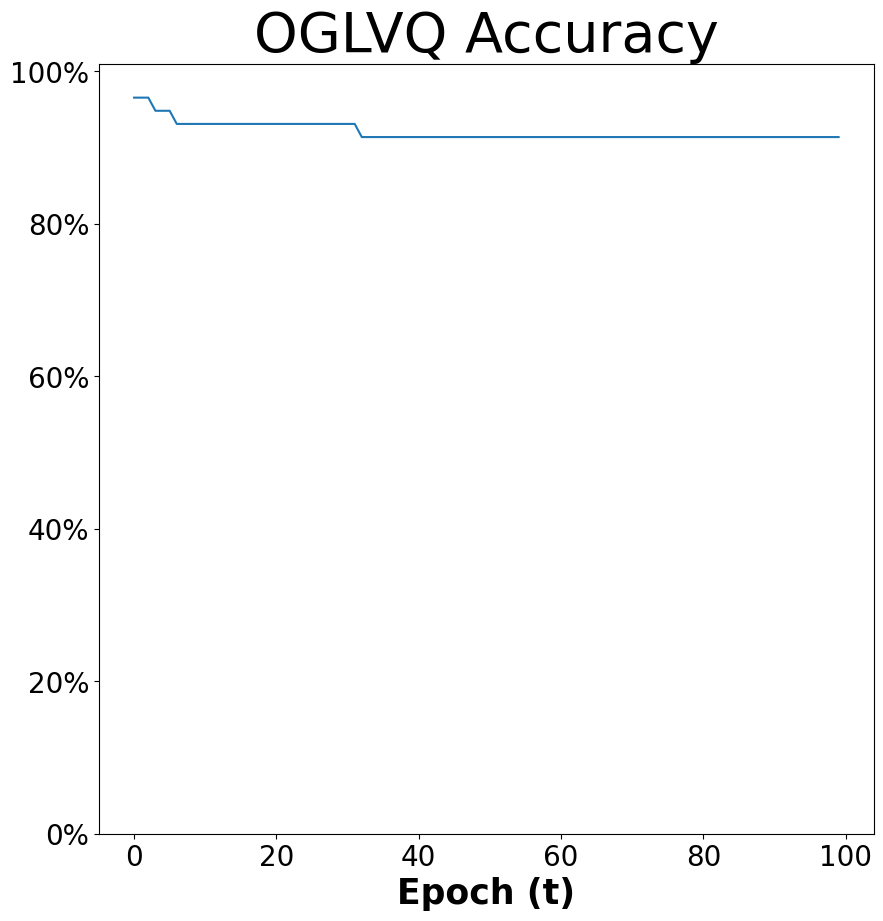

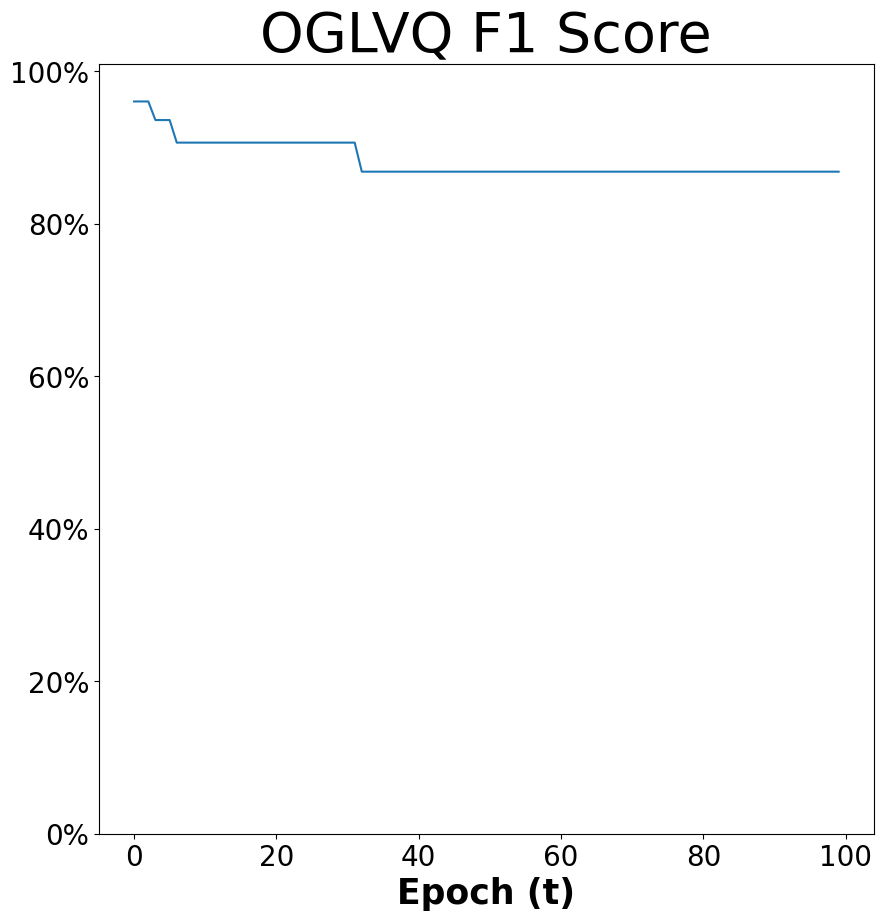

In [55]:
save_figs(oglvq_fscore, experiment, "OGLVQ", learning_rate)

##### 2-step lr = 0.03

In [56]:
learning_rate = 0.03
oglvq_fscore = oglvq.OGLVQ(
    prototypes,
    learning_rate,
)
hist = oglvq_fscore.train(
    num_epochs, train_set_fscore, test_set_fscore, sample_number=train_dist
)


Epoch: 1, Loss: 113.6551, Accuracy: 96.55 %, F_1_score: 96.05 %
Epoch: 11, Loss: 103.7680, Accuracy: 96.55 %, F_1_score: 96.05 %
Epoch: 21, Loss: 103.1875, Accuracy: 94.83 %, F_1_score: 93.61 %
Epoch: 31, Loss: 102.9780, Accuracy: 93.10 %, F_1_score: 90.65 %
Epoch: 41, Loss: 102.8677, Accuracy: 93.10 %, F_1_score: 90.65 %
Epoch: 51, Loss: 102.7973, Accuracy: 93.10 %, F_1_score: 90.65 %
Epoch: 61, Loss: 102.7494, Accuracy: 93.10 %, F_1_score: 90.65 %
Epoch: 71, Loss: 102.7156, Accuracy: 93.10 %, F_1_score: 90.65 %
Epoch: 81, Loss: 102.6901, Accuracy: 93.10 %, F_1_score: 90.65 %
Epoch: 91, Loss: 102.6701, Accuracy: 93.10 %, F_1_score: 90.65 %


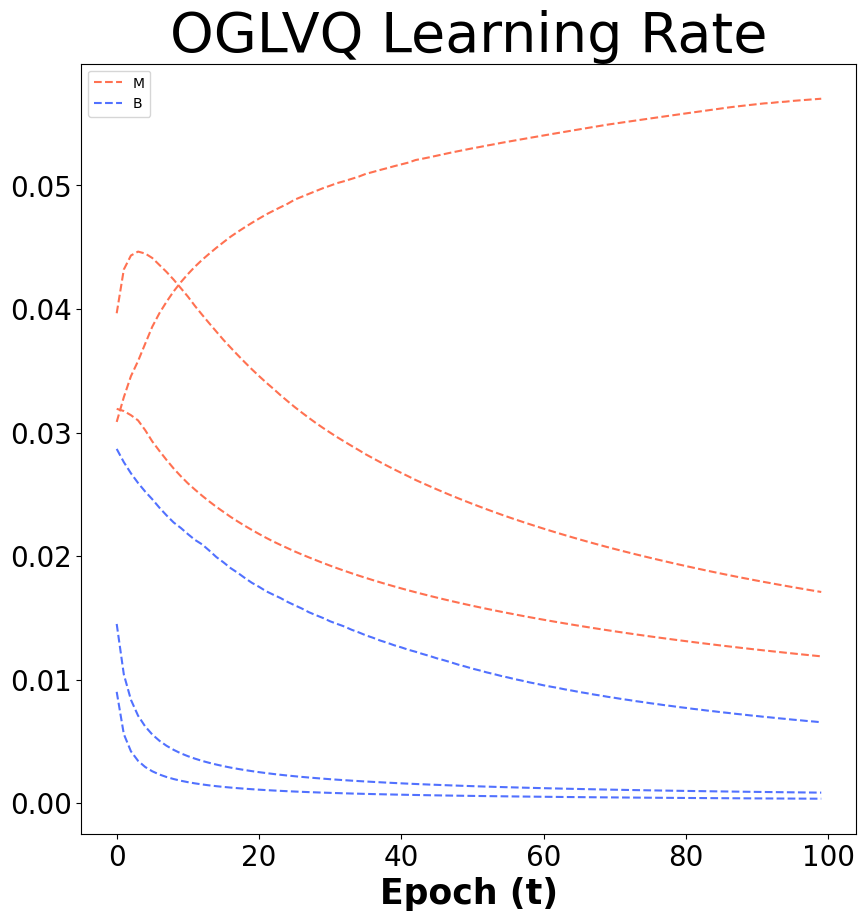

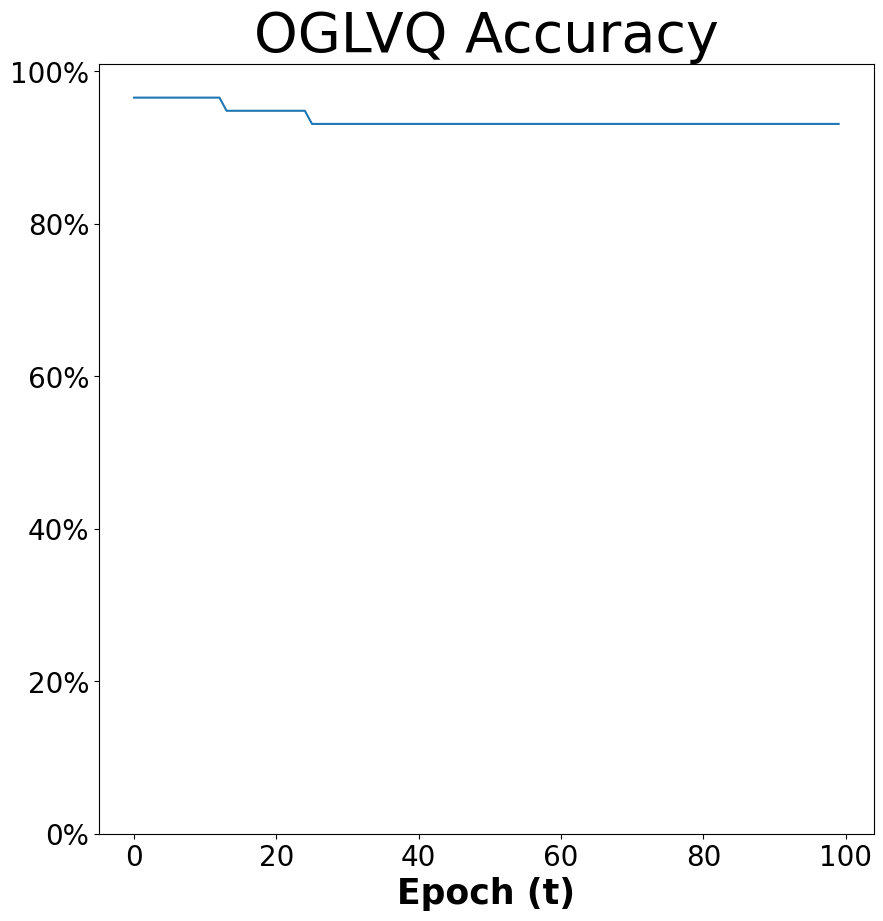

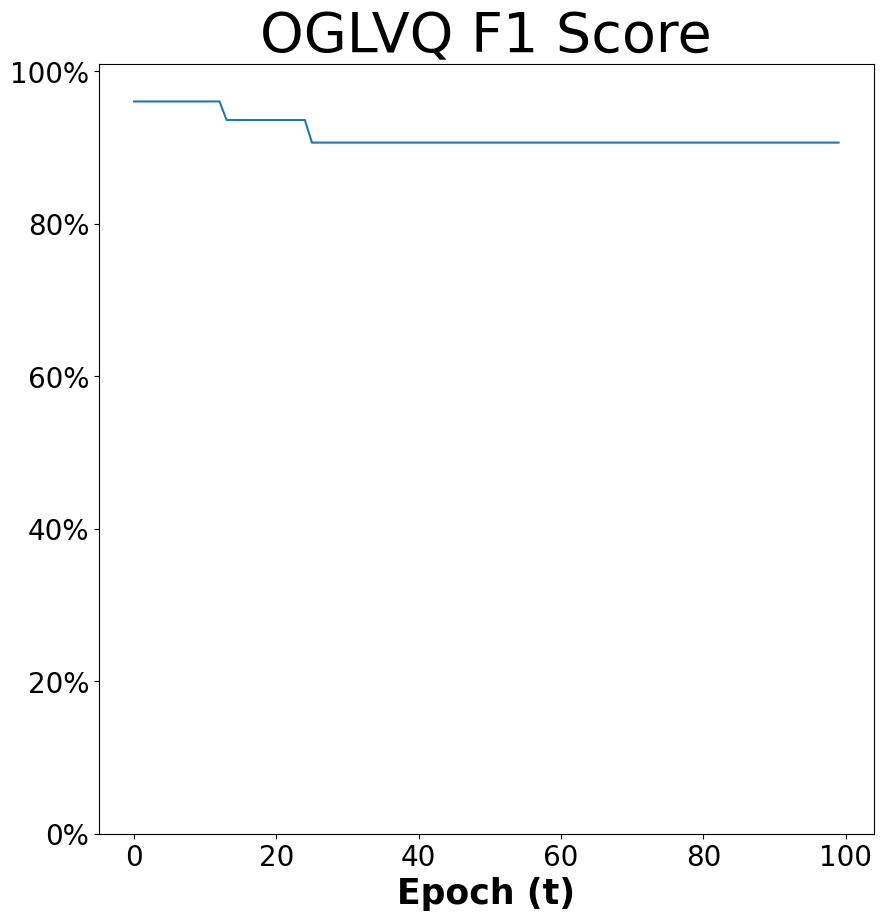

In [57]:
save_figs(oglvq_fscore, experiment, "OGLVQ", learning_rate)

##### 3-step lr = 0.01

In [58]:
learning_rate = 0.01
oglvq_fscore = oglvq.OGLVQ(prototypes, learning_rate)
hist = oglvq_fscore.train(
    num_epochs, train_set_fscore, test_set_fscore, sample_number=train_dist
)


Epoch: 1, Loss: 118.1711, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 11, Loss: 105.7917, Accuracy: 96.55 %, F_1_score: 96.05 %
Epoch: 21, Loss: 104.4166, Accuracy: 96.55 %, F_1_score: 96.05 %
Epoch: 31, Loss: 103.8392, Accuracy: 96.55 %, F_1_score: 96.05 %
Epoch: 41, Loss: 103.5265, Accuracy: 96.55 %, F_1_score: 96.05 %
Epoch: 51, Loss: 103.3303, Accuracy: 94.83 %, F_1_score: 93.61 %
Epoch: 61, Loss: 103.1986, Accuracy: 94.83 %, F_1_score: 93.61 %
Epoch: 71, Loss: 103.1061, Accuracy: 94.83 %, F_1_score: 93.61 %
Epoch: 81, Loss: 103.0367, Accuracy: 94.83 %, F_1_score: 93.61 %
Epoch: 91, Loss: 102.9827, Accuracy: 93.10 %, F_1_score: 90.65 %


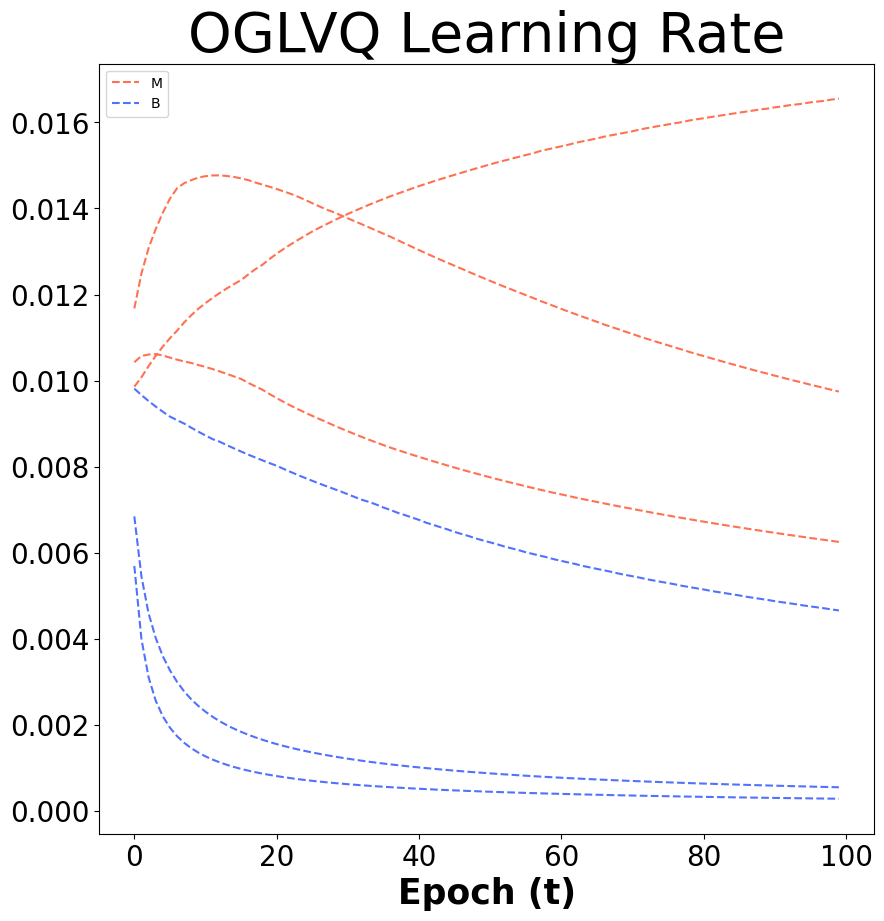

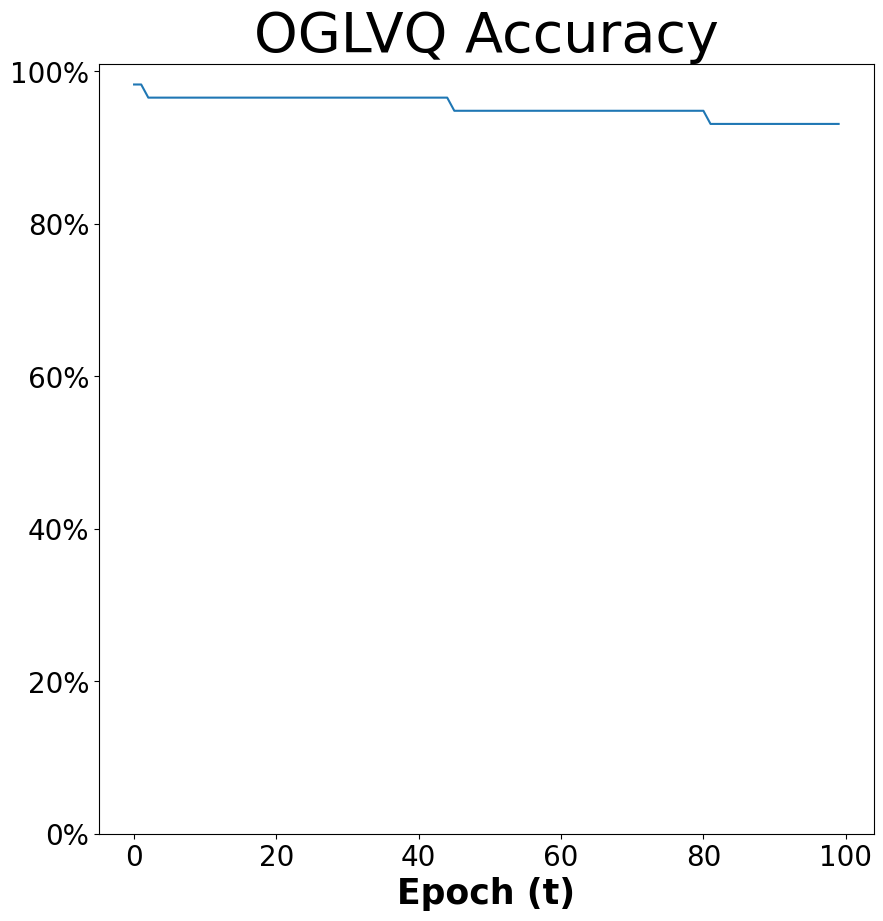

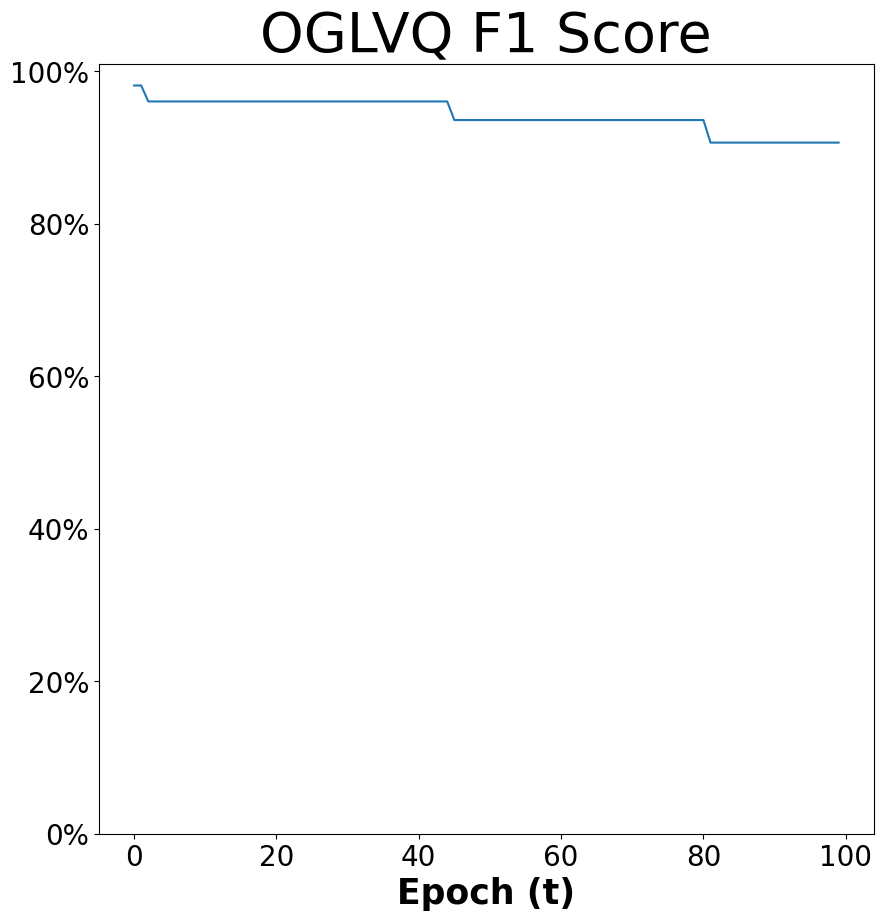

In [59]:
save_figs(oglvq_fscore, experiment, "OGLVQ", learning_rate)

##### CP

##### 1-step lr = 0.1

In [60]:
learning_rate = 0.1
cp_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = cp_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.conditional_probability,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3625, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 11, Loss: 0.3308, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 21, Loss: 0.3291, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 31, Loss: 0.3278, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 41, Loss: 0.3269, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 51, Loss: 0.3262, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 61, Loss: 0.3257, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 71, Loss: 0.3254, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 81, Loss: 0.3250, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 91, Loss: 0.3246, Accuracy: 98.28 %, F_1_score: 98.14 %


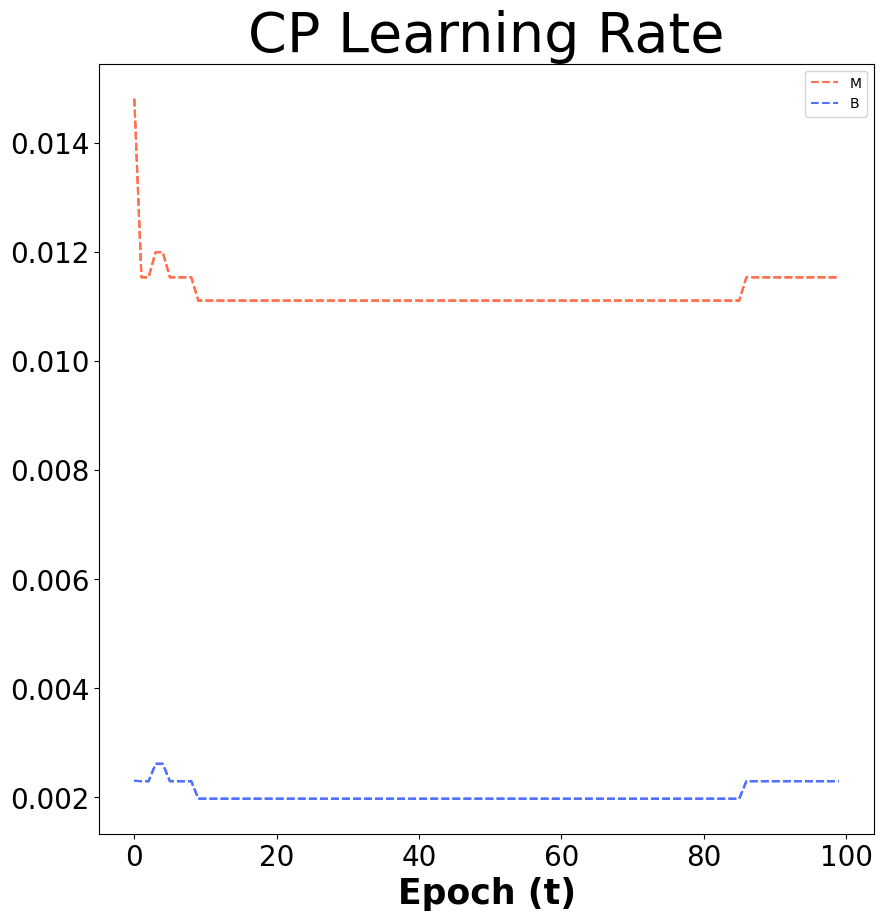

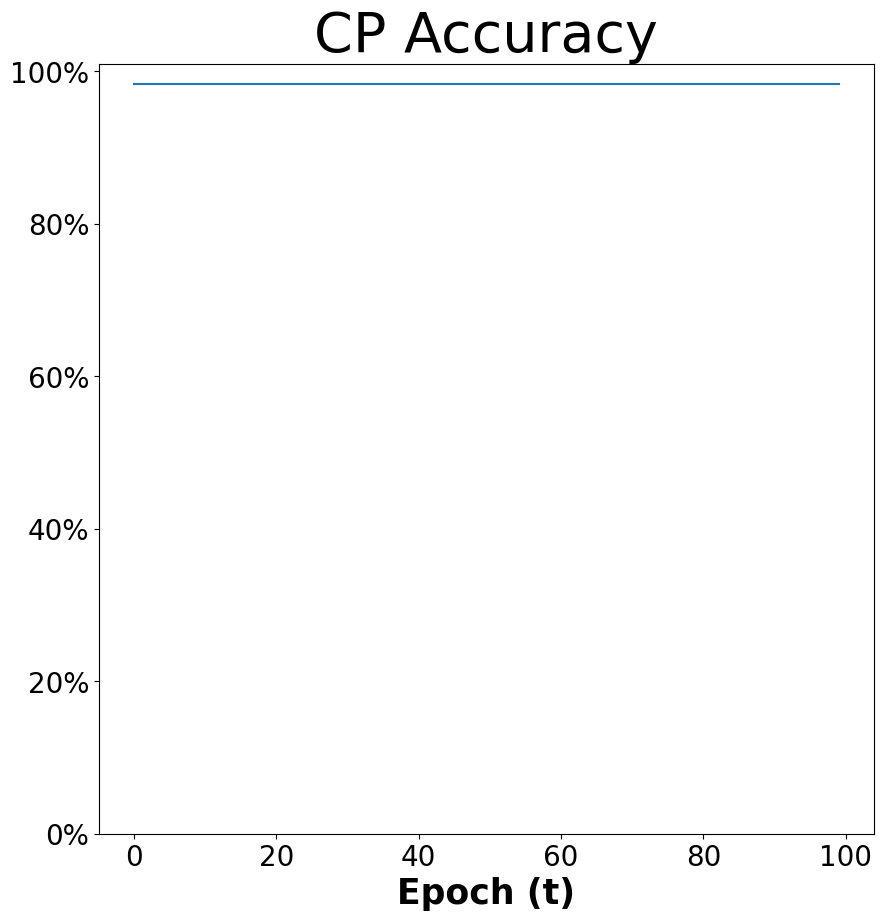

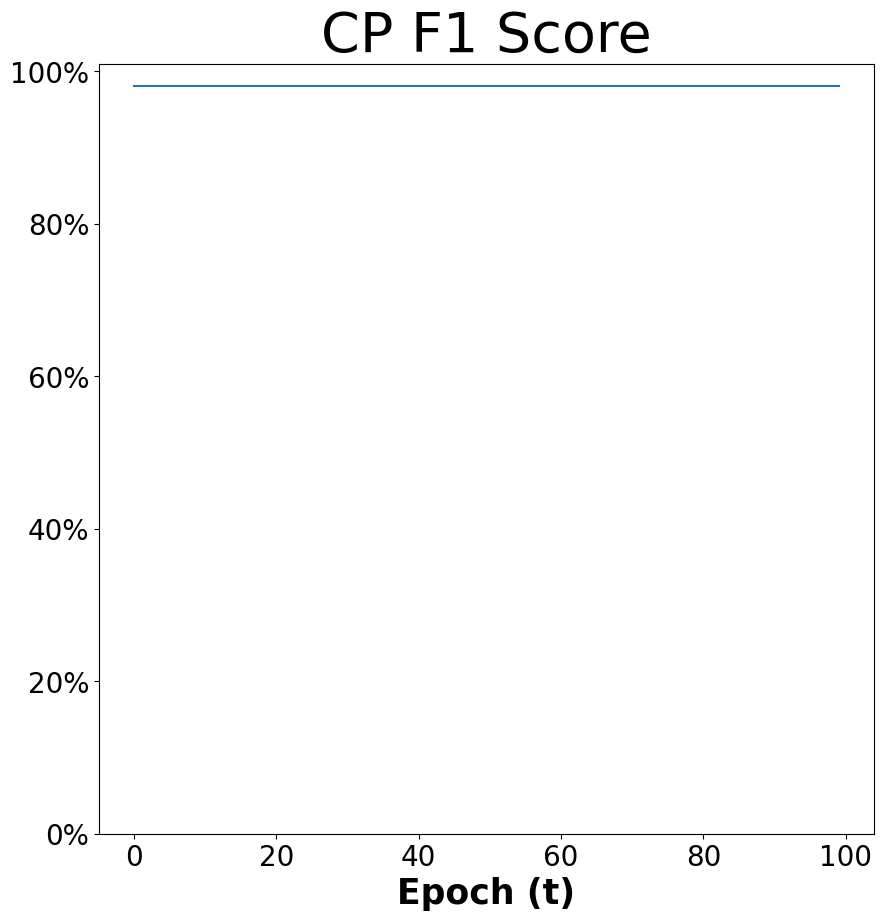

In [61]:
save_figs(cp_glvq_fscore, experiment, "CP", learning_rate)

##### 2-step lr = 0.03

In [62]:
learning_rate = 0.03
cp_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = cp_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.conditional_probability,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3715, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 11, Loss: 0.3389, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 21, Loss: 0.3321, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 31, Loss: 0.3305, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 41, Loss: 0.3300, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 51, Loss: 0.3295, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 61, Loss: 0.3291, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 71, Loss: 0.3287, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 81, Loss: 0.3284, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 91, Loss: 0.3280, Accuracy: 98.28 %, F_1_score: 98.14 %


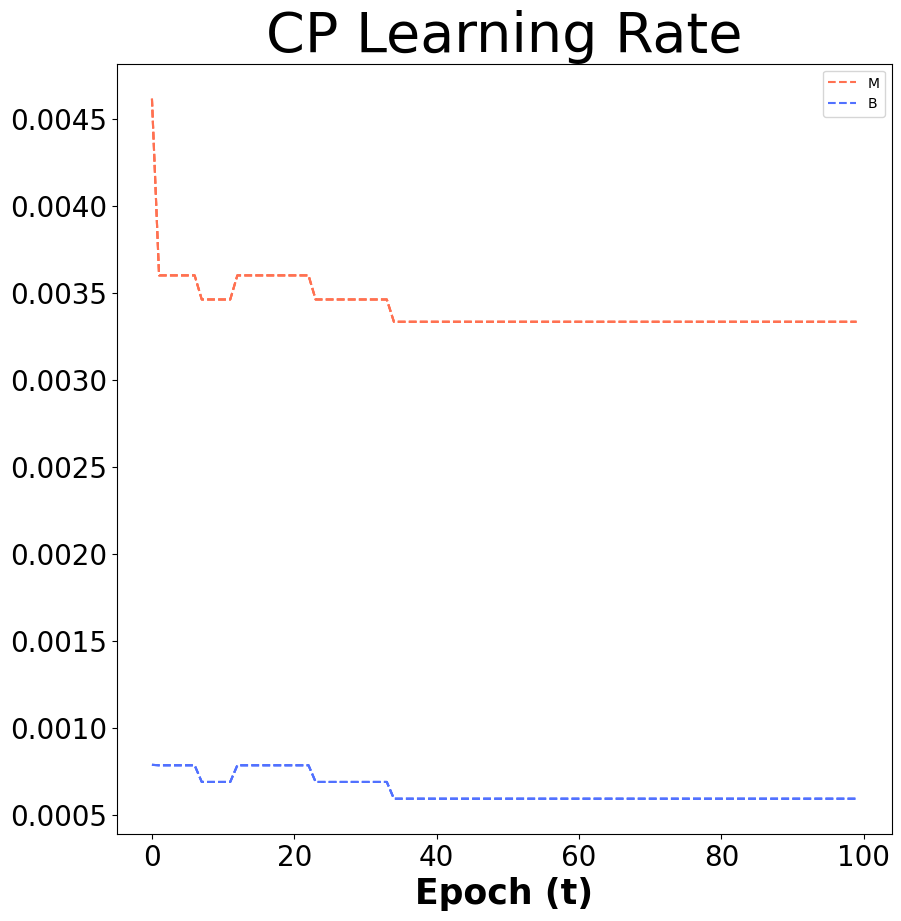

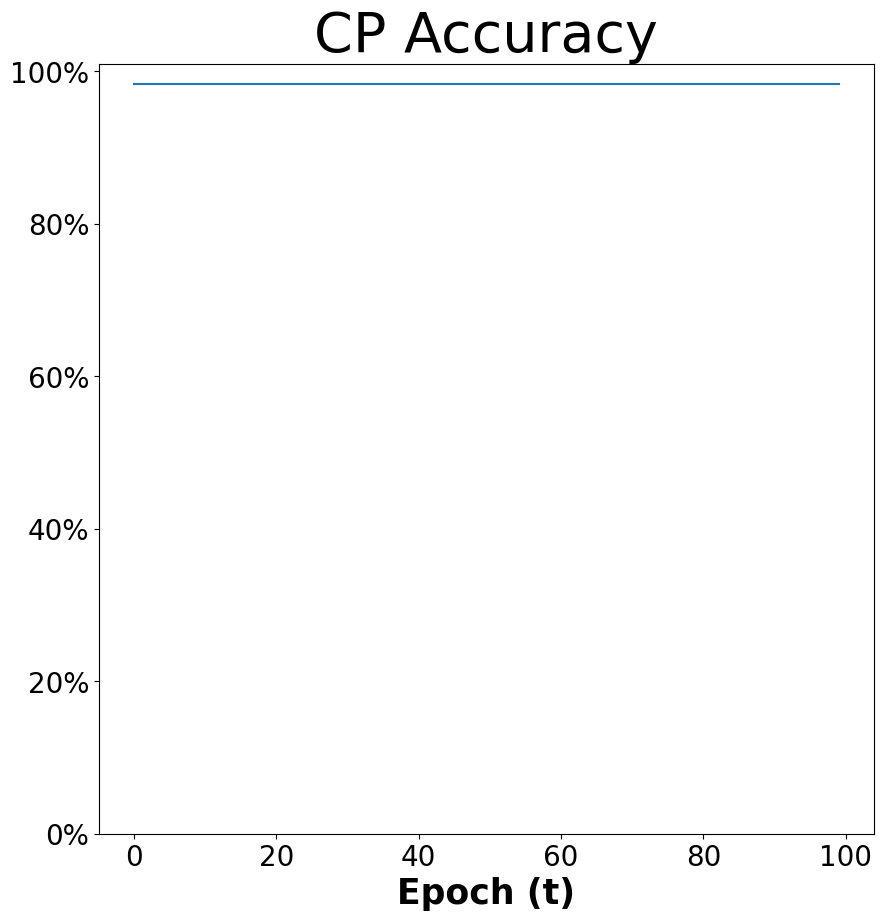

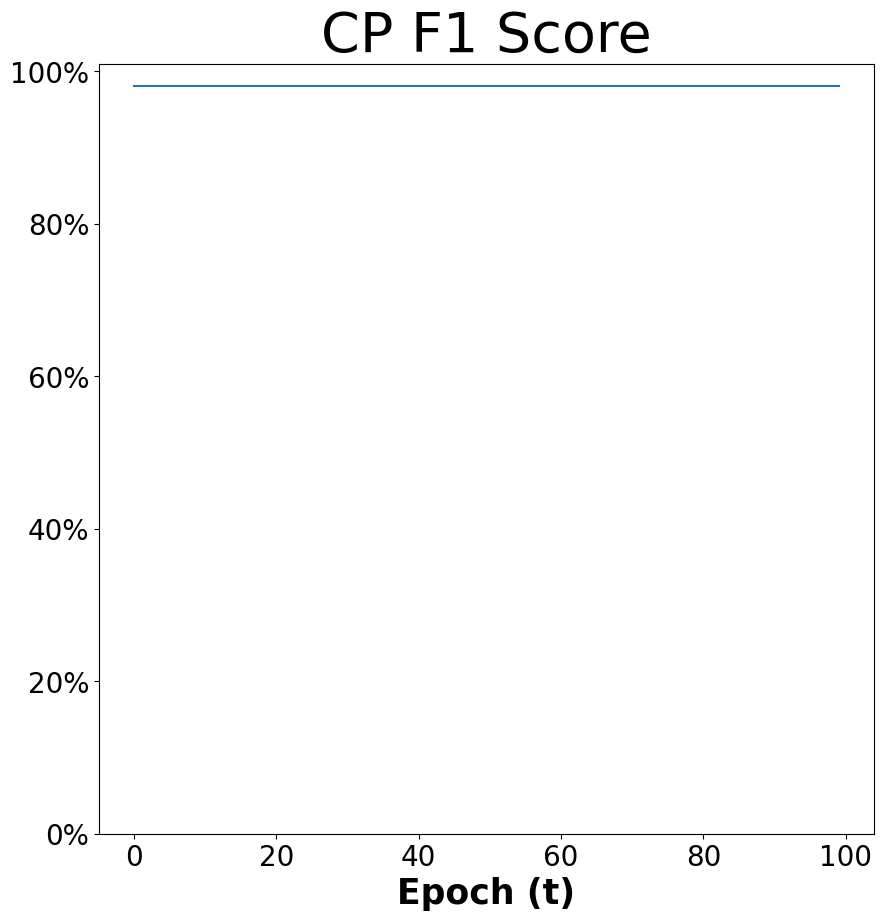

In [63]:
save_figs(cp_glvq_fscore, experiment, "CP", learning_rate)

##### 3-step lr = 0.01

In [64]:
learning_rate = 0.01
cp_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = cp_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.conditional_probability,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3743, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 11, Loss: 0.3560, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 21, Loss: 0.3454, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 31, Loss: 0.3394, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 41, Loss: 0.3359, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 51, Loss: 0.3337, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 61, Loss: 0.3322, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 71, Loss: 0.3314, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 81, Loss: 0.3310, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 91, Loss: 0.3307, Accuracy: 98.28 %, F_1_score: 98.14 %


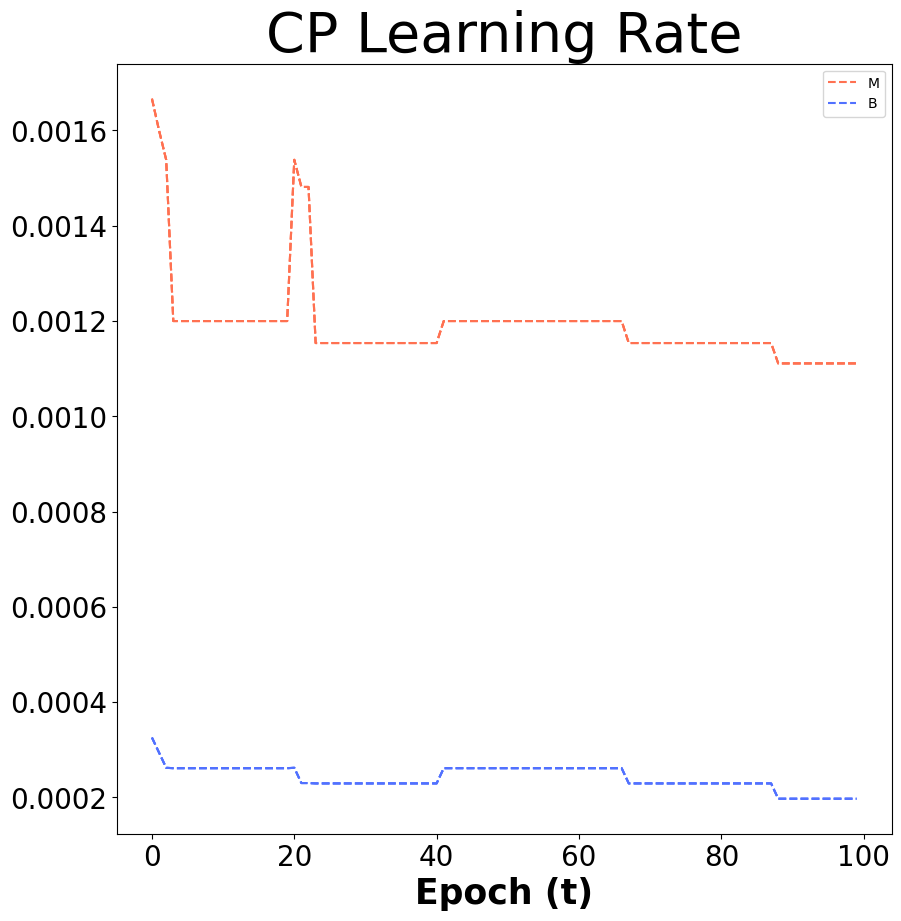

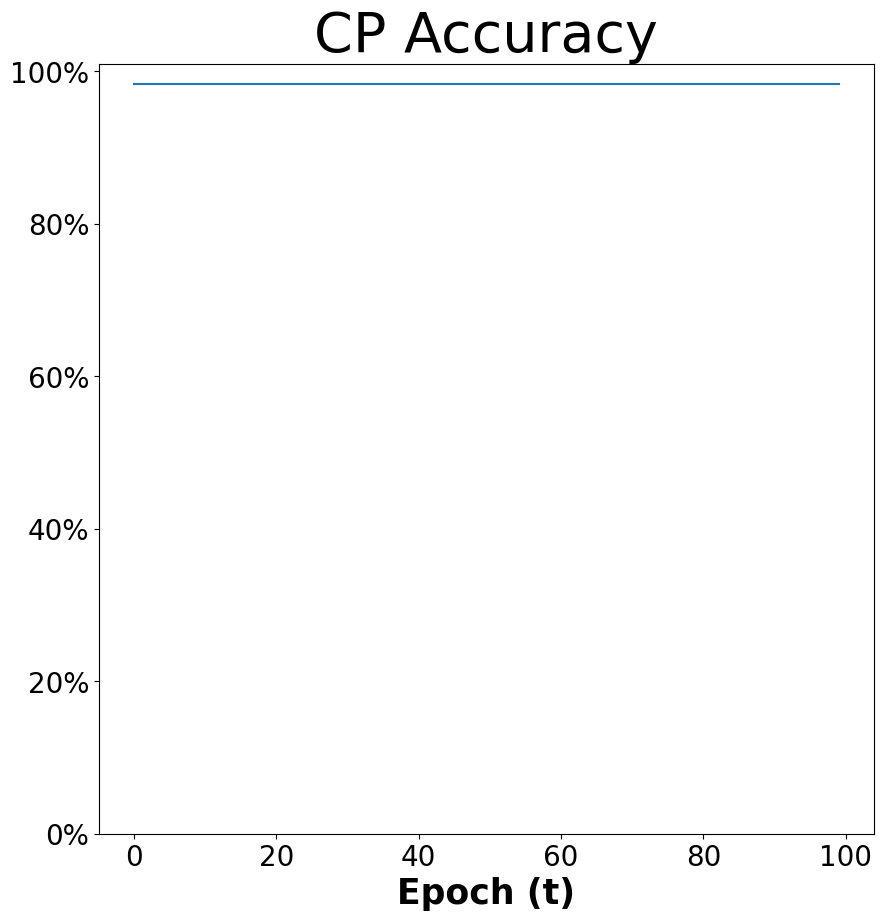

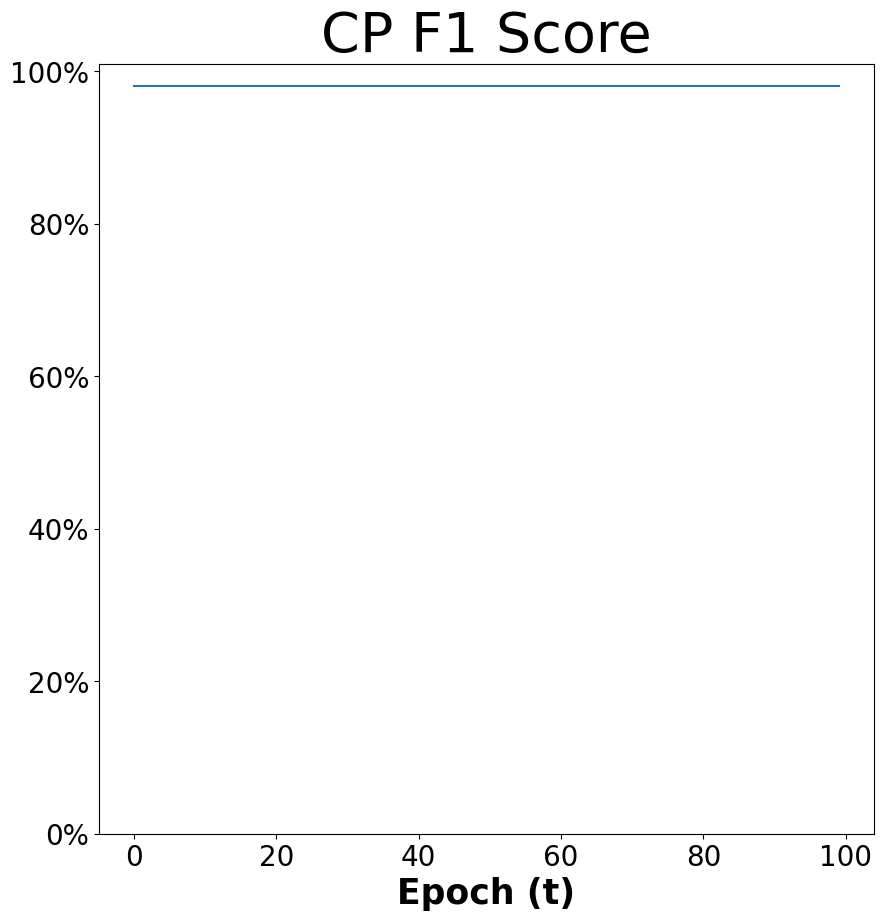

In [65]:
save_figs(cp_glvq_fscore, experiment, "CP", learning_rate)

##### DFH

##### 1-step lr = 0.1

In [66]:
learning_rate = 0.1
dfh_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = dfh_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.dual_factor_heuristic,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3597, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 11, Loss: 0.3488, Accuracy: 93.10 %, F_1_score: 93.48 %
Epoch: 21, Loss: 0.3493, Accuracy: 93.10 %, F_1_score: 93.48 %
Epoch: 31, Loss: 0.3492, Accuracy: 93.10 %, F_1_score: 93.48 %
Epoch: 41, Loss: 0.3492, Accuracy: 93.10 %, F_1_score: 93.48 %
Epoch: 51, Loss: 0.3483, Accuracy: 93.10 %, F_1_score: 93.48 %
Epoch: 61, Loss: 0.3494, Accuracy: 93.10 %, F_1_score: 93.48 %
Epoch: 71, Loss: 0.3492, Accuracy: 93.10 %, F_1_score: 93.48 %
Epoch: 81, Loss: 0.3488, Accuracy: 93.10 %, F_1_score: 93.48 %
Epoch: 91, Loss: 0.3489, Accuracy: 93.10 %, F_1_score: 93.48 %


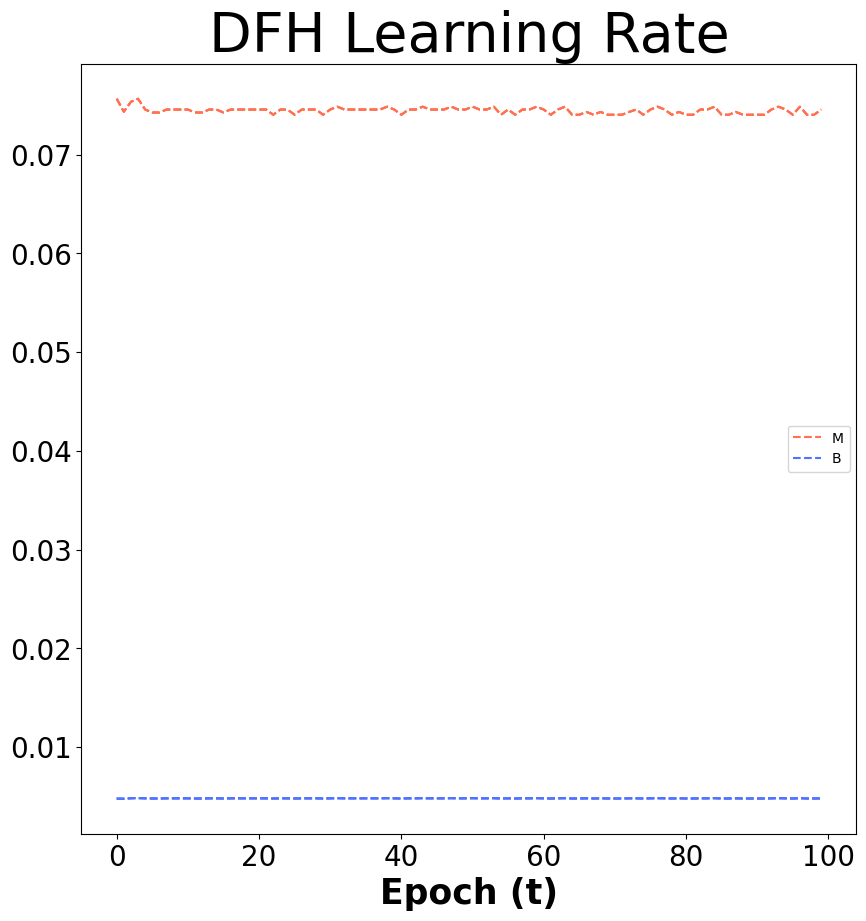

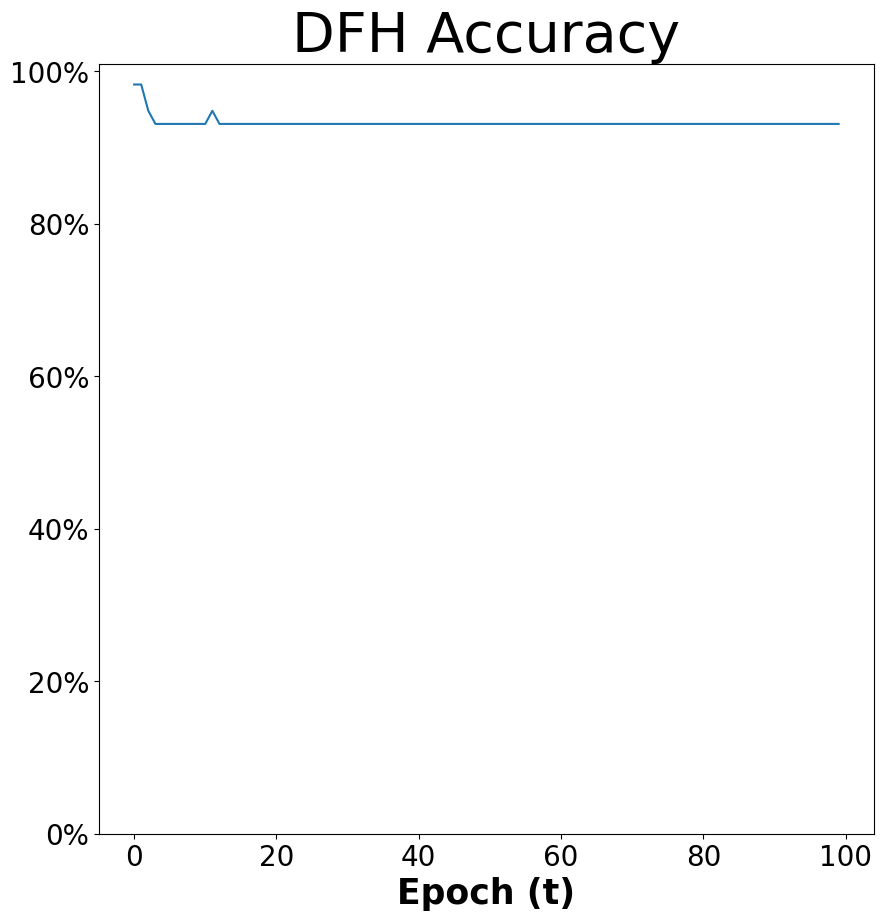

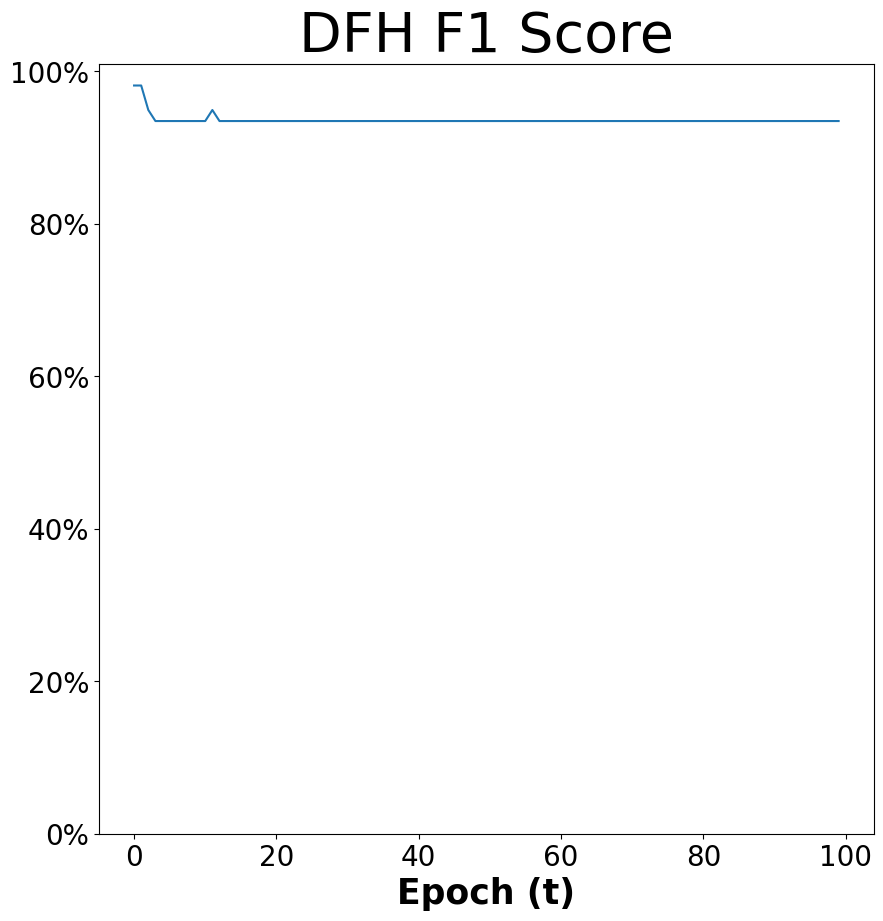

In [67]:
save_figs(dfh_glvq_fscore, experiment, "DFH", learning_rate)

##### 2-step lr = 0.03

In [68]:
learning_rate = 0.03
dfh_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = dfh_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.dual_factor_heuristic,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3691, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 11, Loss: 0.3491, Accuracy: 94.83 %, F_1_score: 94.93 %
Epoch: 21, Loss: 0.3488, Accuracy: 93.10 %, F_1_score: 93.48 %
Epoch: 31, Loss: 0.3488, Accuracy: 93.10 %, F_1_score: 93.48 %
Epoch: 41, Loss: 0.3487, Accuracy: 93.10 %, F_1_score: 93.48 %
Epoch: 51, Loss: 0.3488, Accuracy: 93.10 %, F_1_score: 93.48 %
Epoch: 61, Loss: 0.3489, Accuracy: 93.10 %, F_1_score: 93.48 %
Epoch: 71, Loss: 0.3490, Accuracy: 93.10 %, F_1_score: 93.48 %
Epoch: 81, Loss: 0.3490, Accuracy: 93.10 %, F_1_score: 93.48 %
Epoch: 91, Loss: 0.3490, Accuracy: 93.10 %, F_1_score: 93.48 %


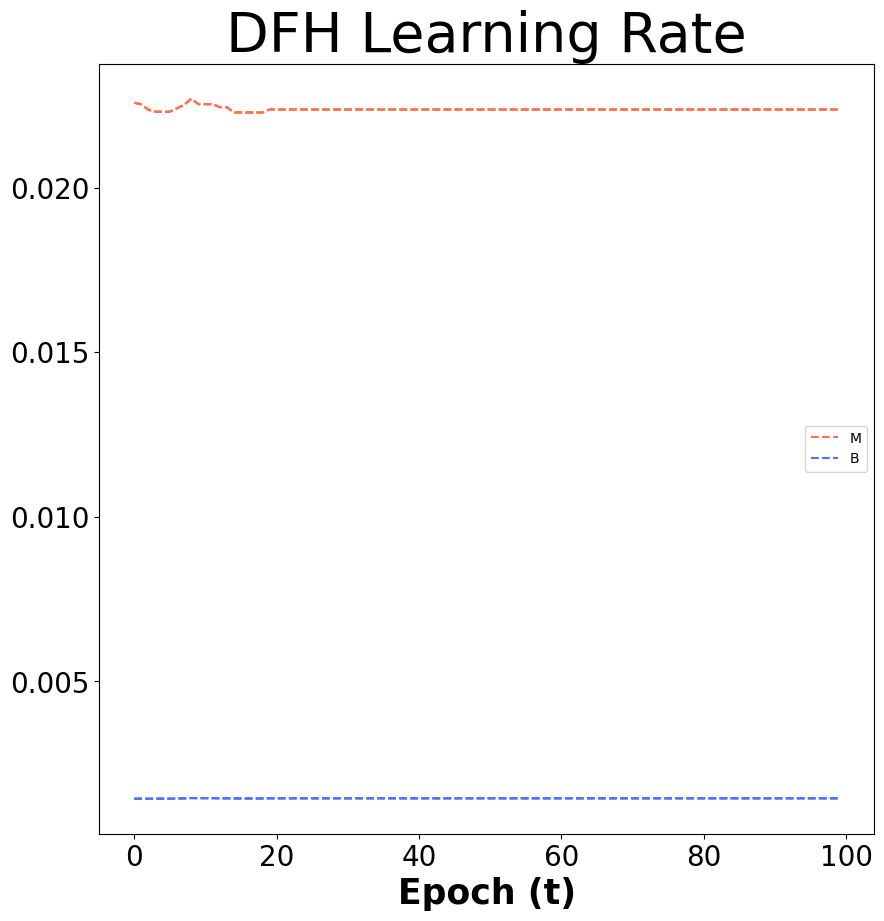

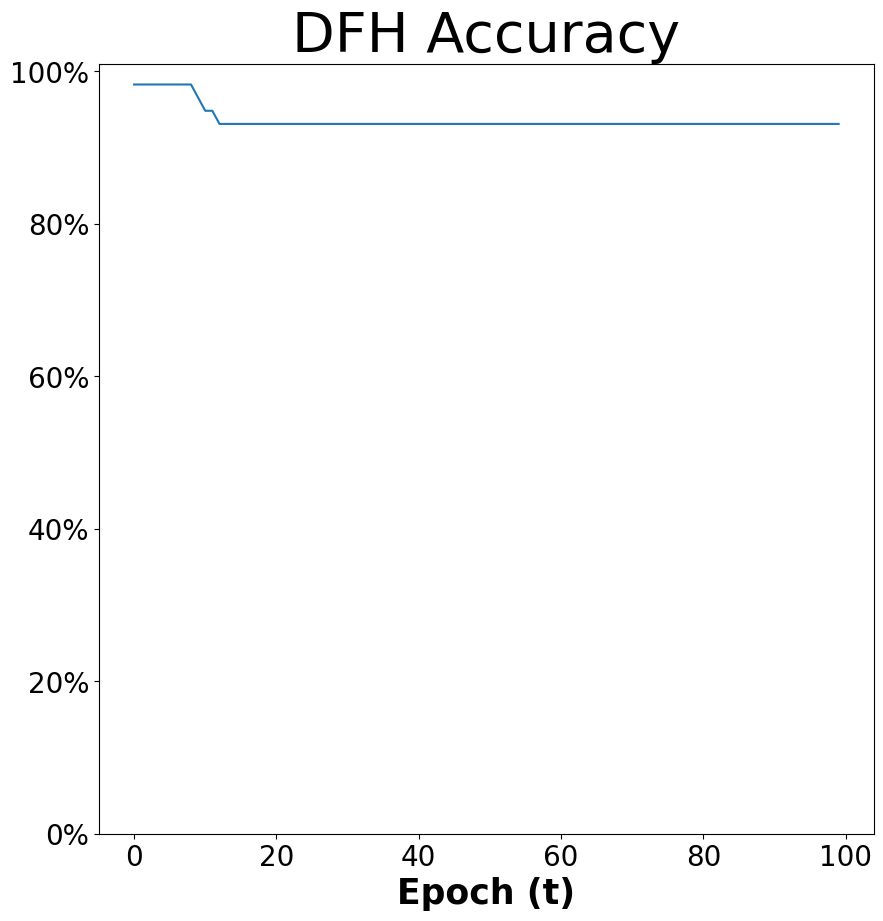

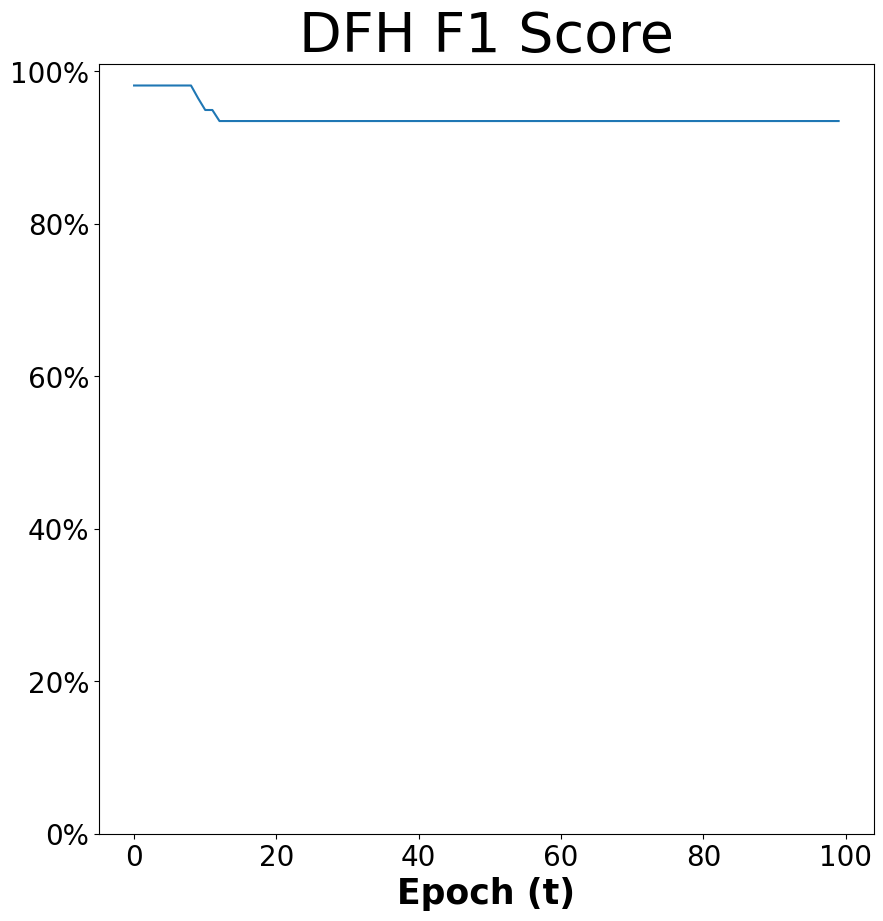

In [69]:
save_figs(dfh_glvq_fscore, experiment, "DFH", learning_rate)

##### 3-step lr = 0.01

In [70]:
learning_rate = 0.01
dfh_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = dfh_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.dual_factor_heuristic,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3735, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 11, Loss: 0.3540, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 21, Loss: 0.3501, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 31, Loss: 0.3492, Accuracy: 96.55 %, F_1_score: 96.47 %
Epoch: 41, Loss: 0.3491, Accuracy: 93.10 %, F_1_score: 93.48 %
Epoch: 51, Loss: 0.3489, Accuracy: 93.10 %, F_1_score: 93.48 %
Epoch: 61, Loss: 0.3488, Accuracy: 93.10 %, F_1_score: 93.48 %
Epoch: 71, Loss: 0.3487, Accuracy: 93.10 %, F_1_score: 93.48 %
Epoch: 81, Loss: 0.3486, Accuracy: 93.10 %, F_1_score: 93.48 %
Epoch: 91, Loss: 0.3486, Accuracy: 93.10 %, F_1_score: 93.48 %


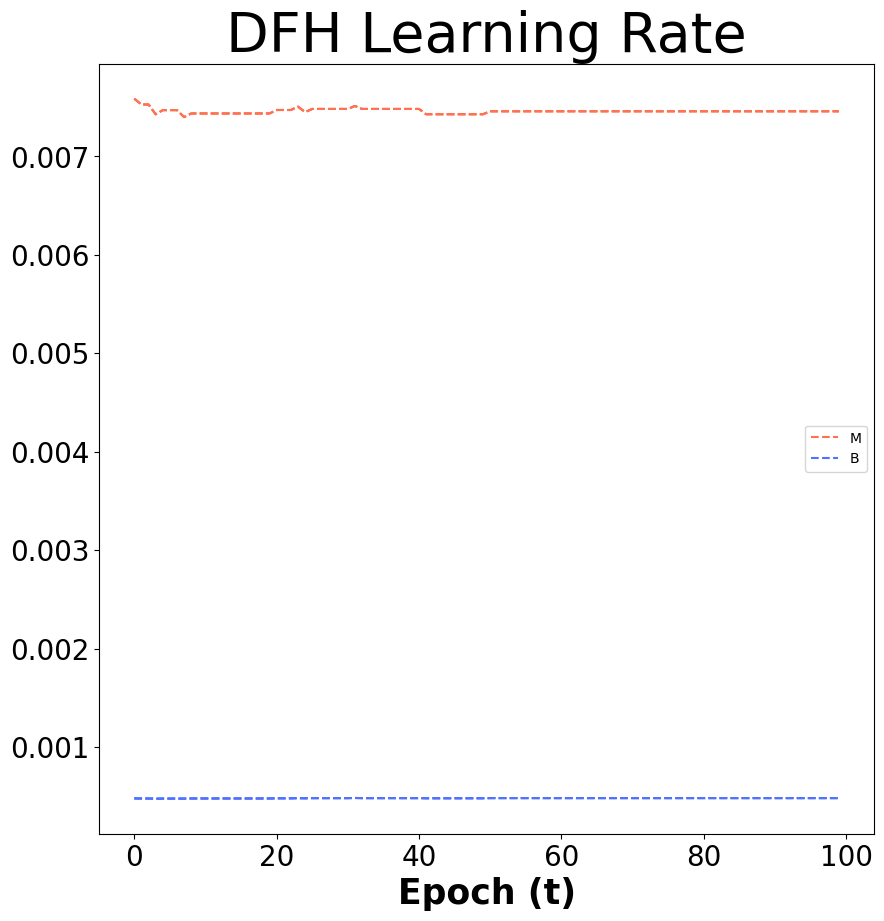

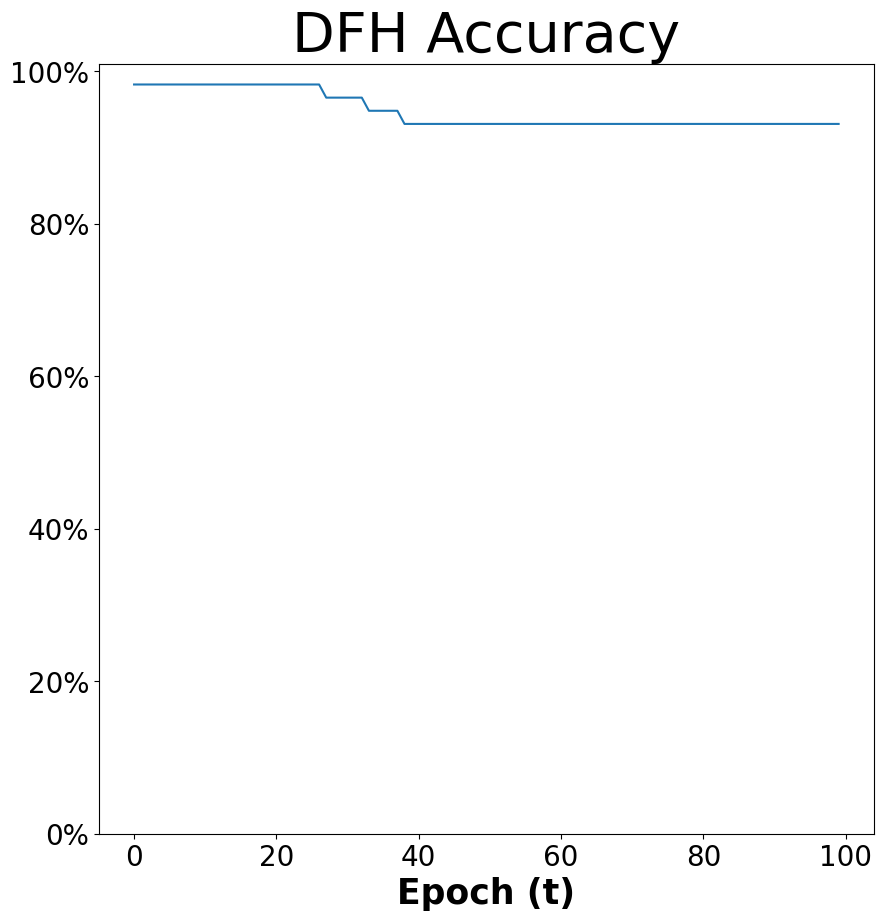

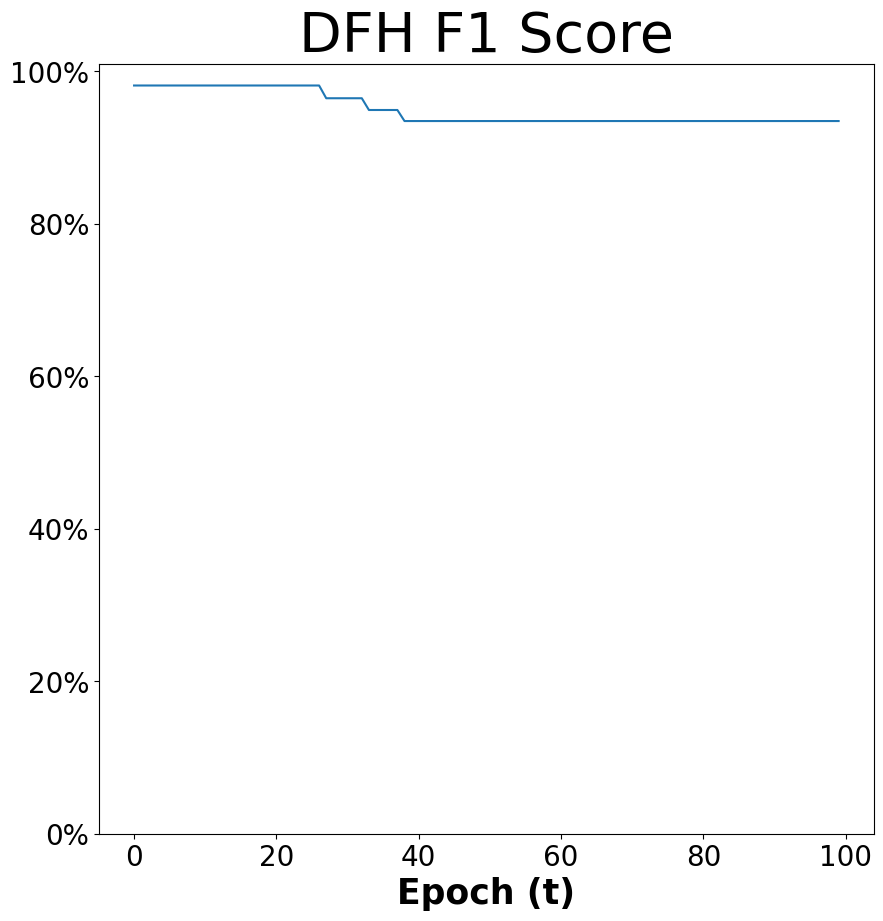

In [71]:
save_figs(dfh_glvq_fscore, experiment, "DFH", learning_rate)

##### MS

##### 1-step lr = 0.1

In [72]:
learning_rate = 0.1
ms_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = ms_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.middle_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3512, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 11, Loss: 0.3389, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 21, Loss: 0.3383, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 31, Loss: 0.3384, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 41, Loss: 0.3383, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 51, Loss: 0.3379, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 61, Loss: 0.3379, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 71, Loss: 0.3378, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 81, Loss: 0.3381, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 91, Loss: 0.3375, Accuracy: 96.55 %, F_1_score: 96.47 %


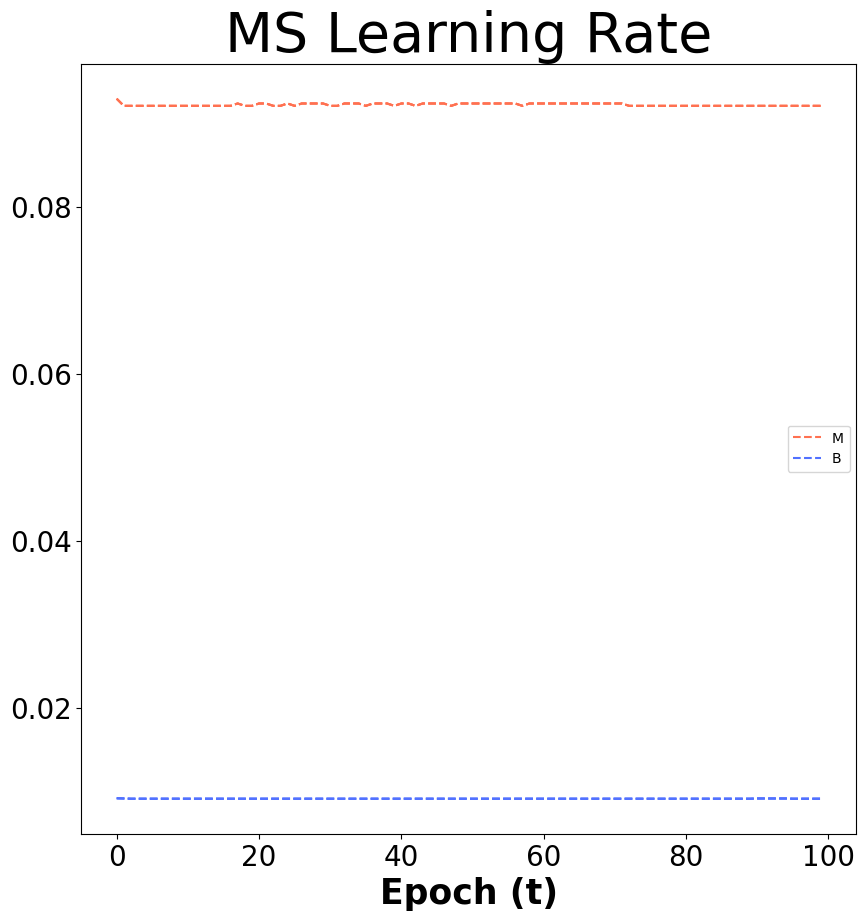

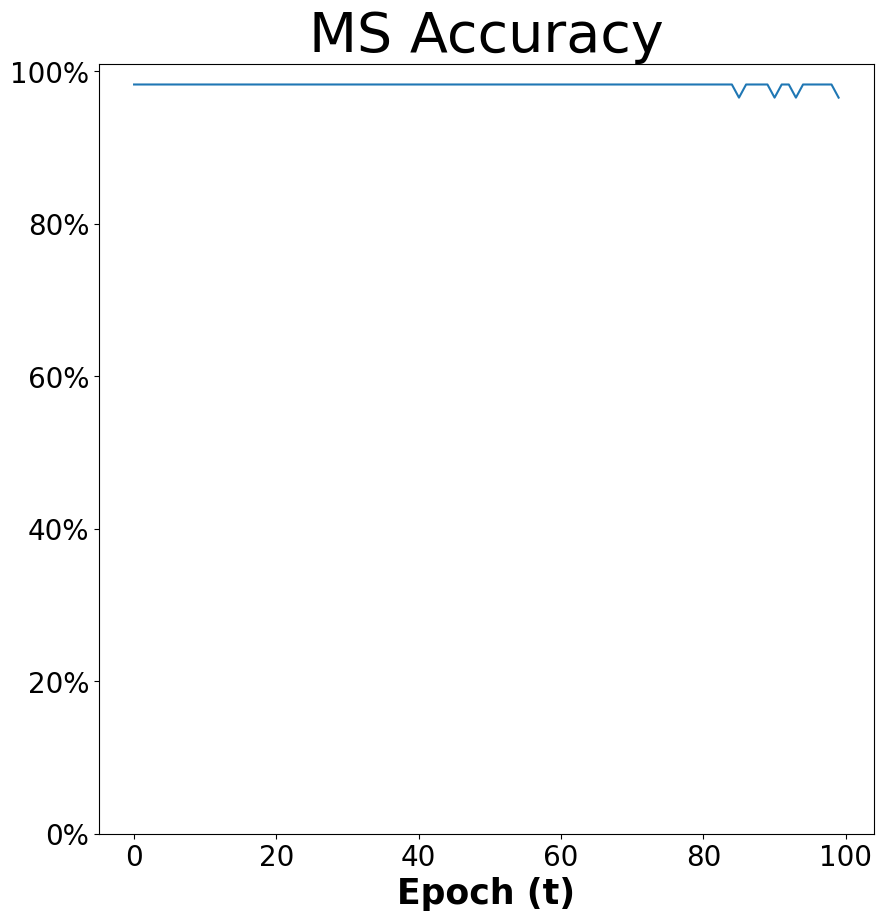

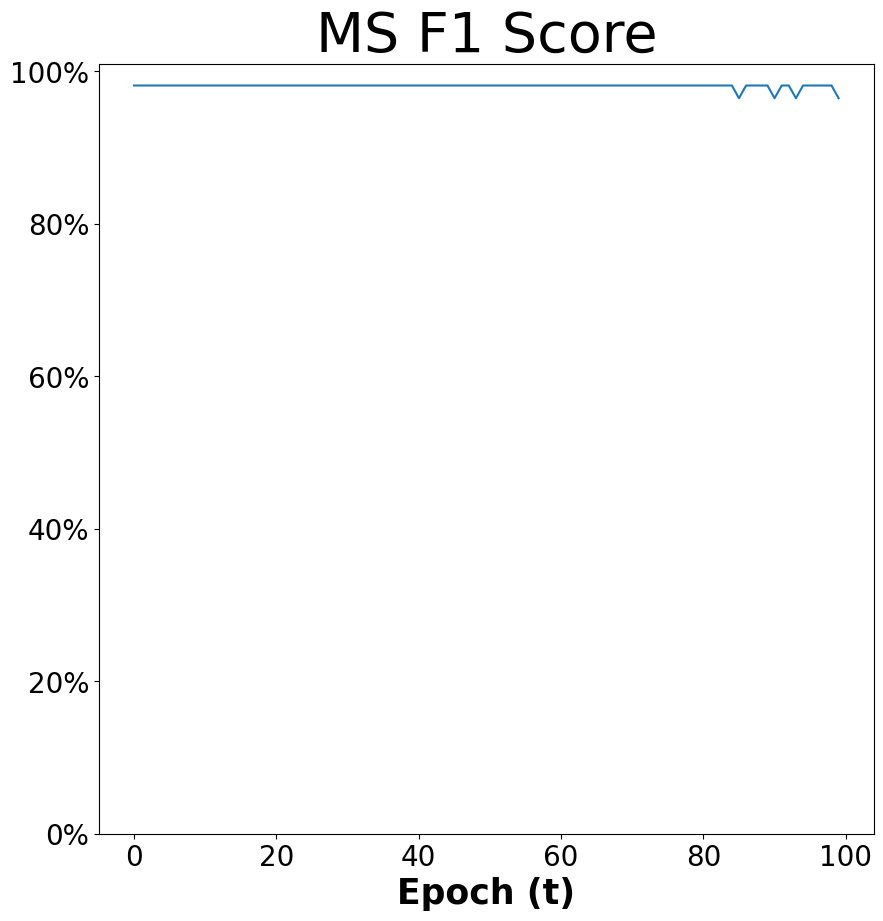

In [73]:
save_figs(ms_glvq_fscore, experiment, "MS", learning_rate)

##### 2-step lr = 0.03

In [74]:
learning_rate = 0.03
ms_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = ms_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.middle_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3645, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 11, Loss: 0.3396, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 21, Loss: 0.3387, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 31, Loss: 0.3385, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 41, Loss: 0.3385, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 51, Loss: 0.3384, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 61, Loss: 0.3382, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 71, Loss: 0.3381, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 81, Loss: 0.3381, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 91, Loss: 0.3380, Accuracy: 98.28 %, F_1_score: 98.14 %


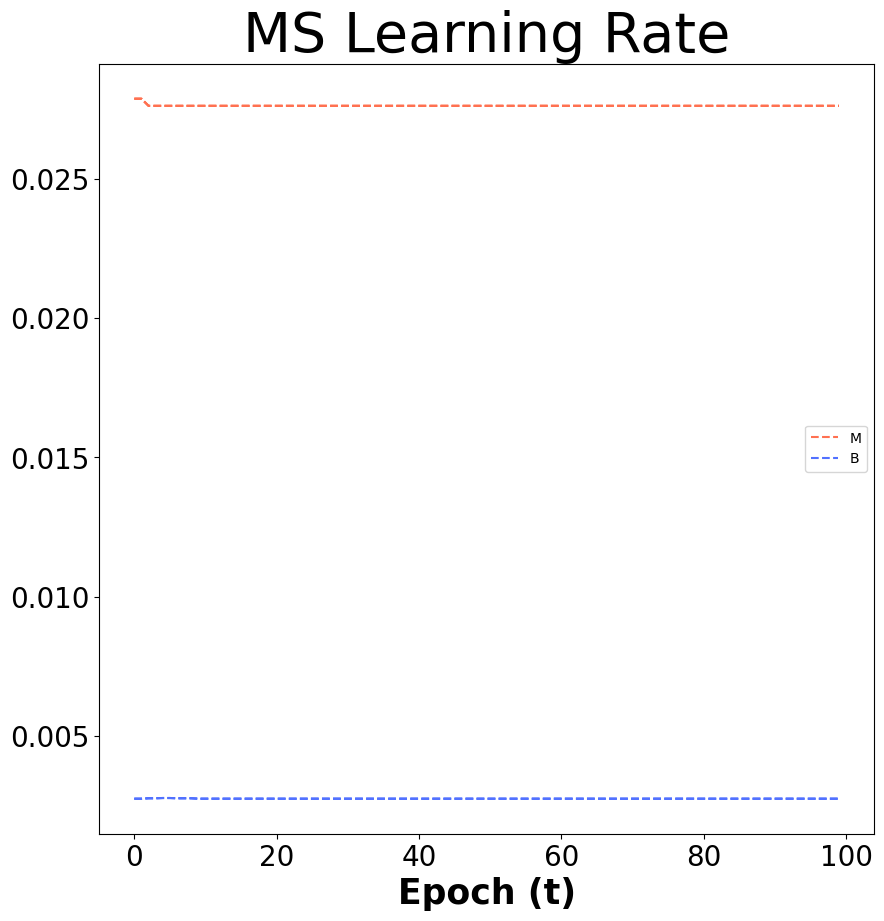

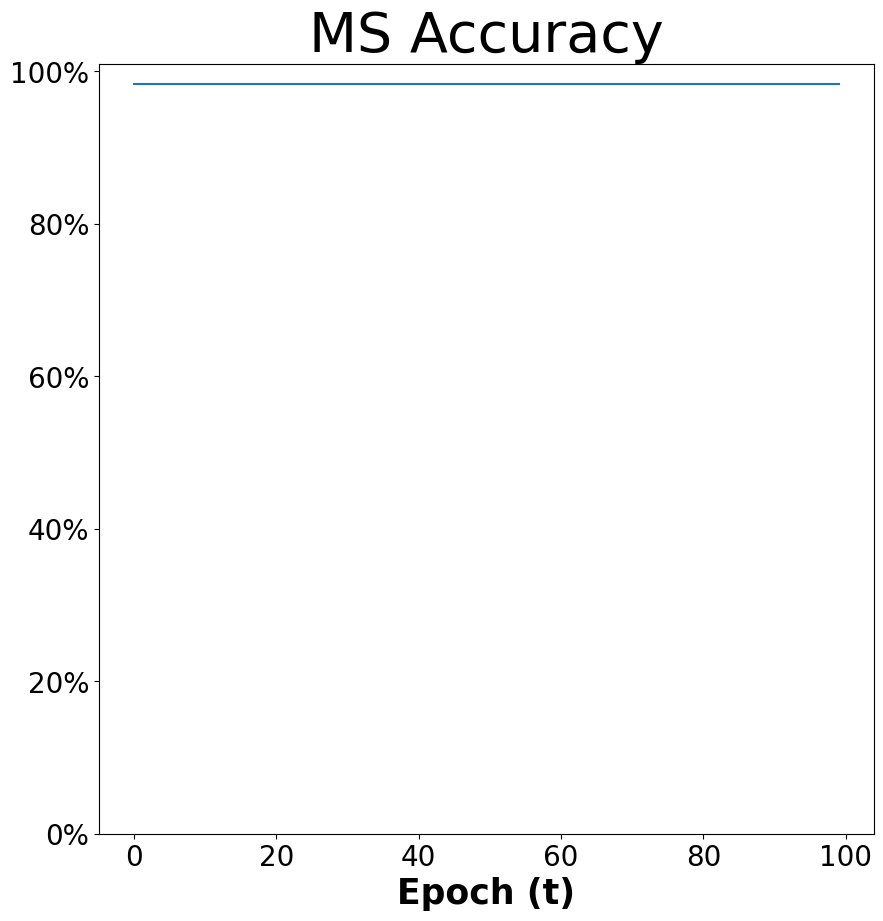

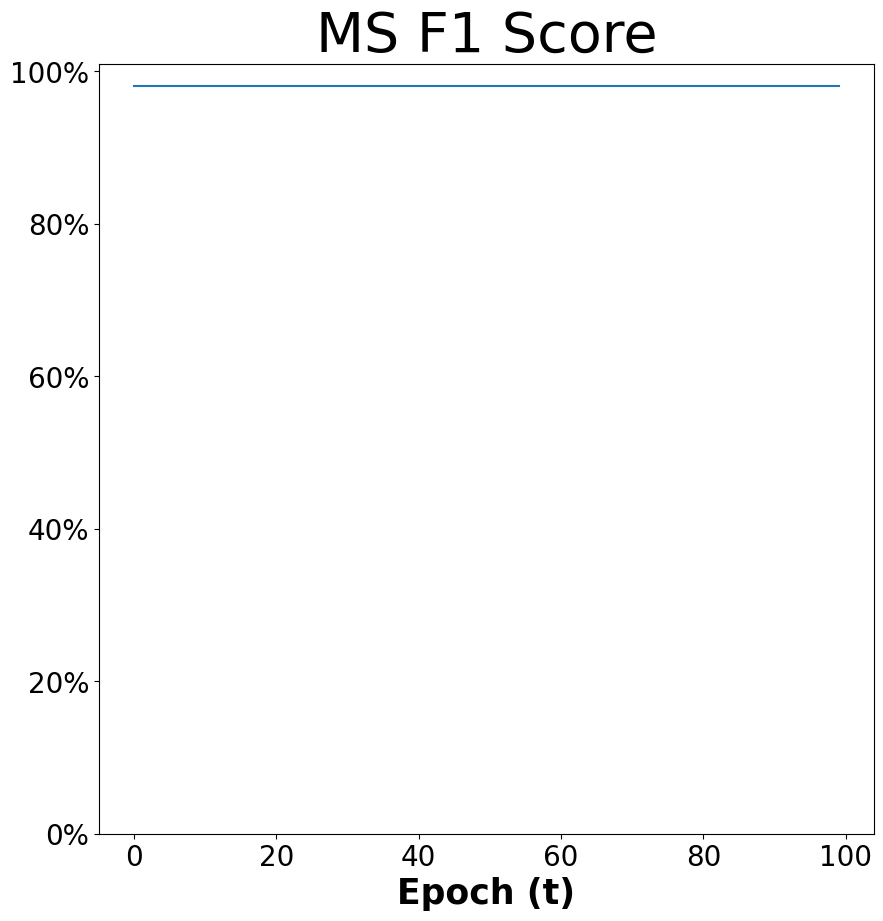

In [75]:
save_figs(ms_glvq_fscore, experiment, "MS", learning_rate)

##### 3-step lr = 0.01

In [76]:
learning_rate = 0.01
ms_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = ms_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.middle_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3716, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 11, Loss: 0.3435, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 21, Loss: 0.3402, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 31, Loss: 0.3395, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 41, Loss: 0.3391, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 51, Loss: 0.3388, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 61, Loss: 0.3386, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 71, Loss: 0.3385, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 81, Loss: 0.3385, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 91, Loss: 0.3385, Accuracy: 98.28 %, F_1_score: 98.14 %


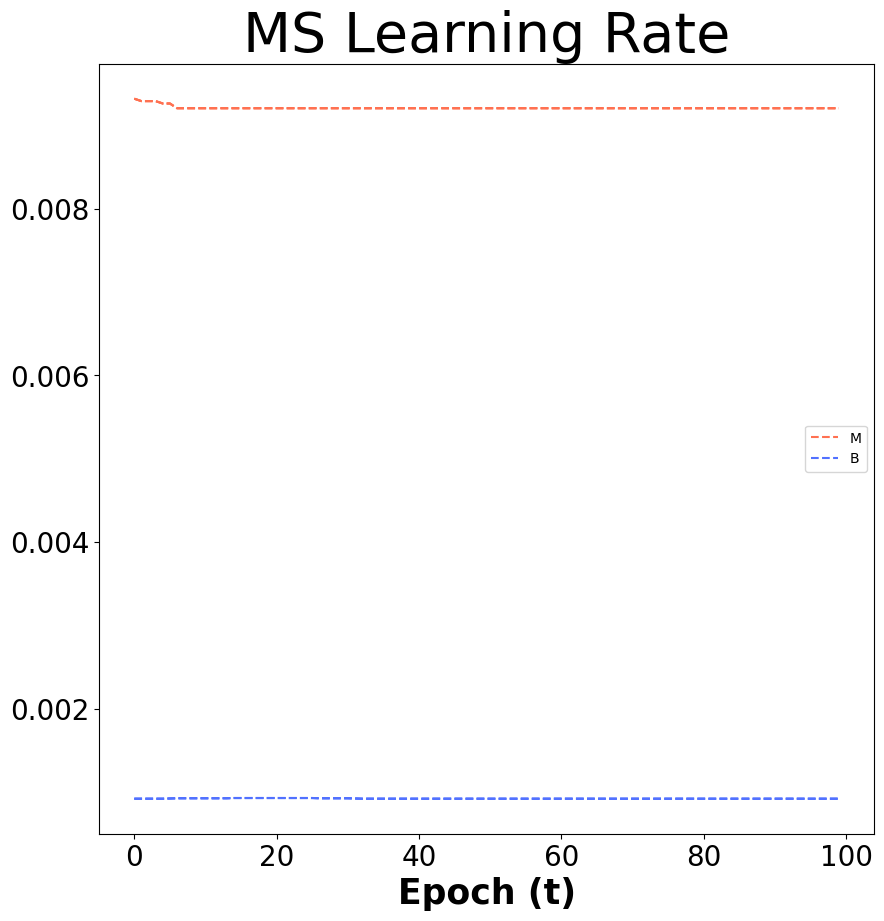

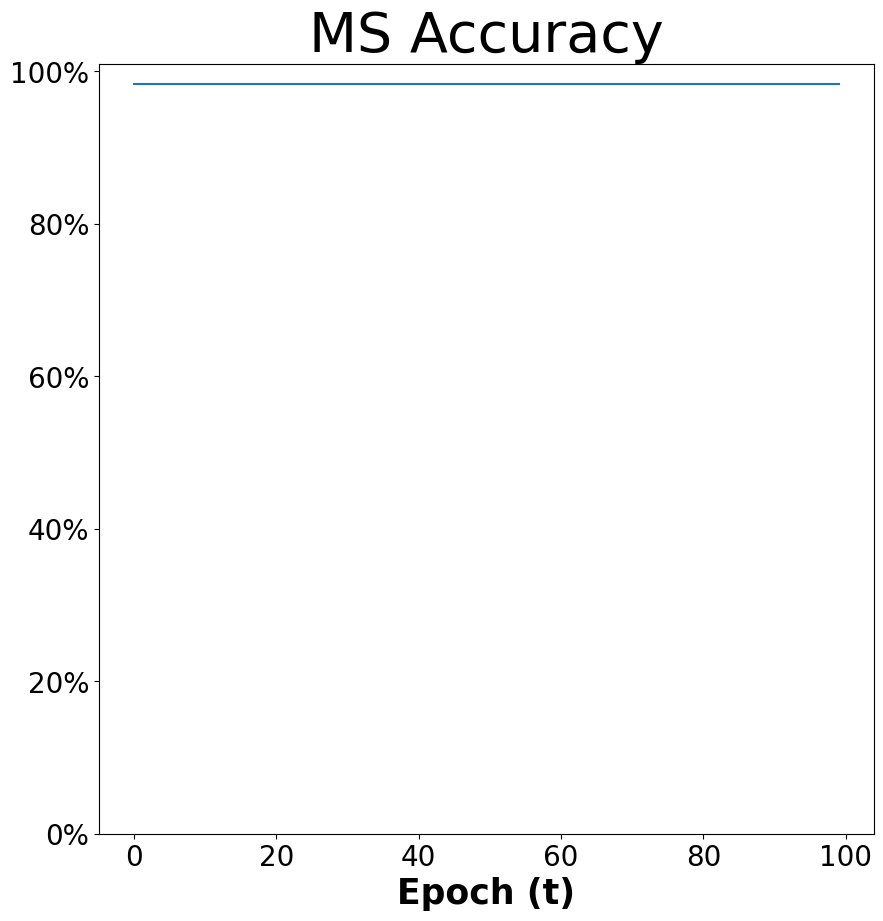

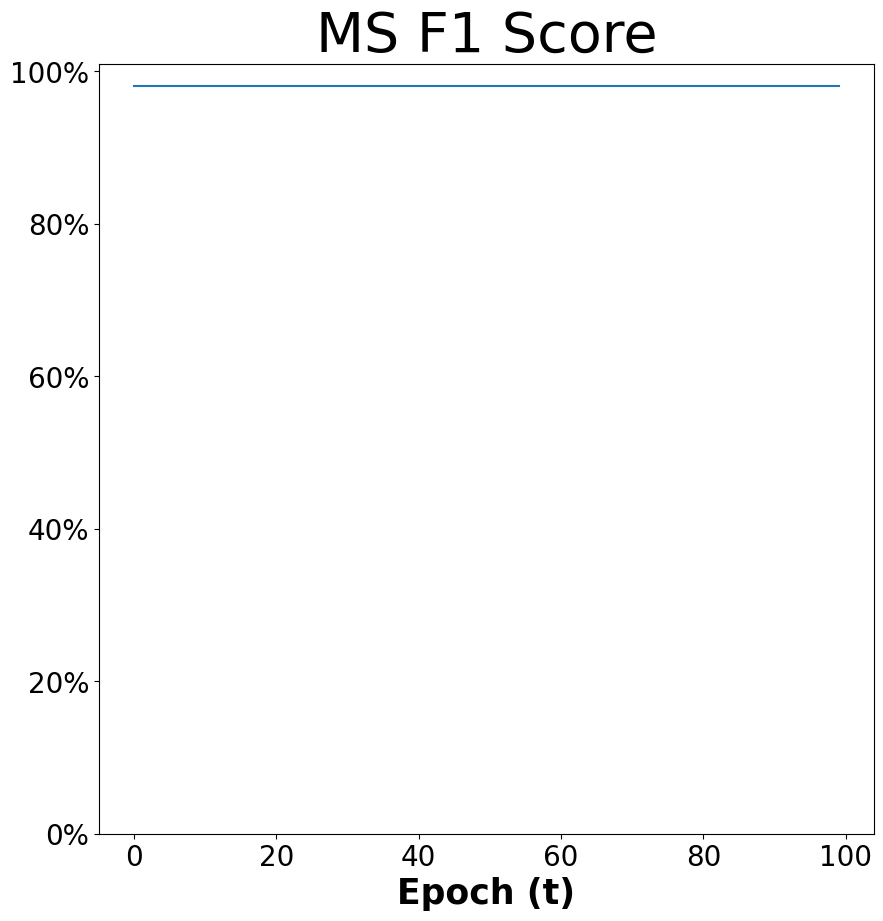

In [77]:
save_figs(ms_glvq_fscore, experiment, "MS", learning_rate)

##### LS

##### 1-step lr = 0.1

In [78]:
learning_rate = 0.1
ls_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = ls_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.loose_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3505, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 11, Loss: 0.3283, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 21, Loss: 0.3273, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 31, Loss: 0.3267, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 41, Loss: 0.3263, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 51, Loss: 0.3263, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 61, Loss: 0.3261, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 71, Loss: 0.3261, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 81, Loss: 0.3259, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 91, Loss: 0.3259, Accuracy: 98.28 %, F_1_score: 98.14 %


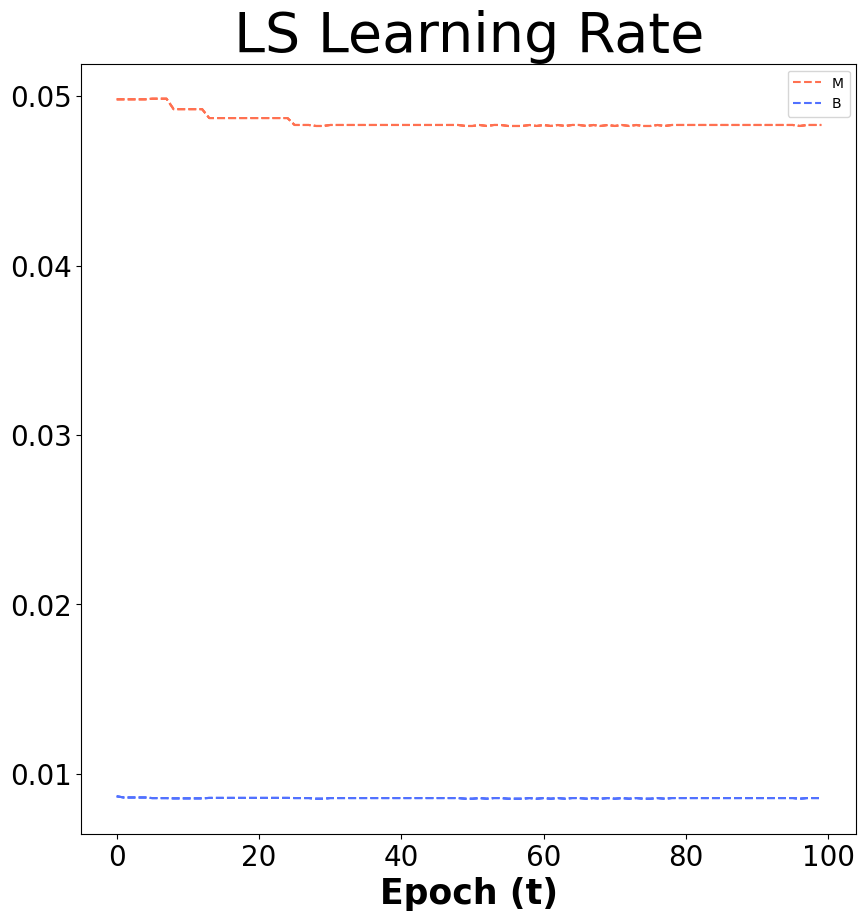

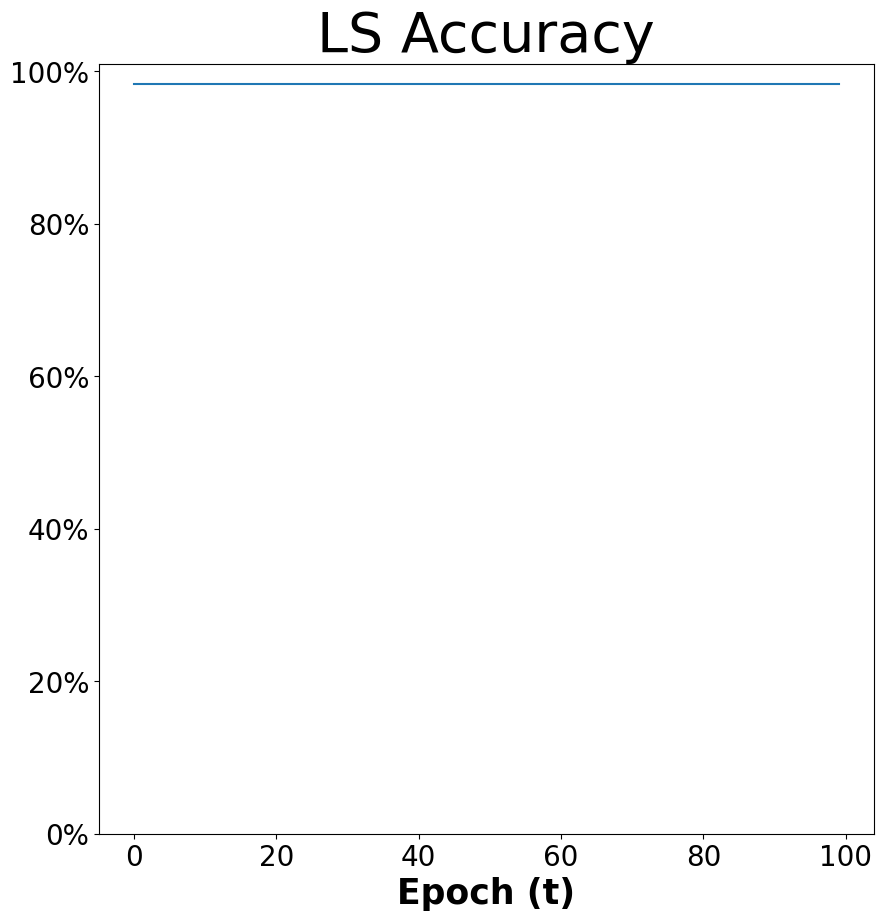

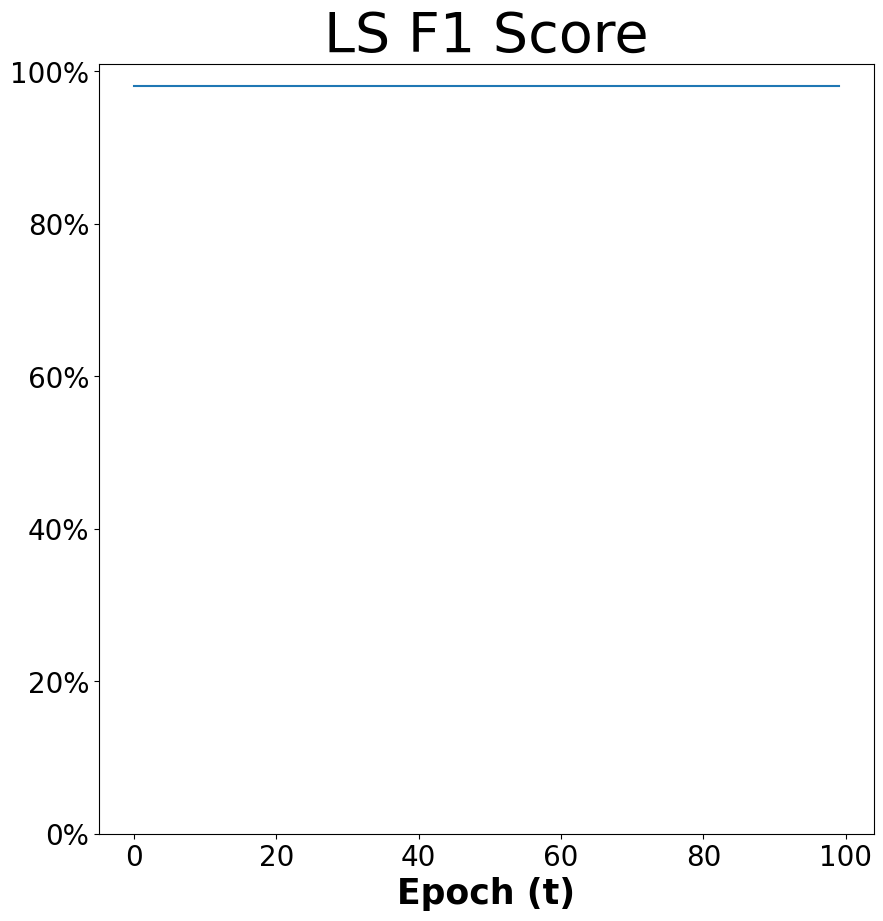

In [79]:
save_figs(ls_glvq_fscore, experiment, "LS", learning_rate)

##### 2-step lr = 0.03

In [80]:
learning_rate = 0.03
ls_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = ls_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.loose_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3654, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 11, Loss: 0.3325, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 21, Loss: 0.3302, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 31, Loss: 0.3288, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 41, Loss: 0.3279, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 51, Loss: 0.3271, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 61, Loss: 0.3268, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 71, Loss: 0.3266, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 81, Loss: 0.3264, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 91, Loss: 0.3263, Accuracy: 98.28 %, F_1_score: 98.14 %


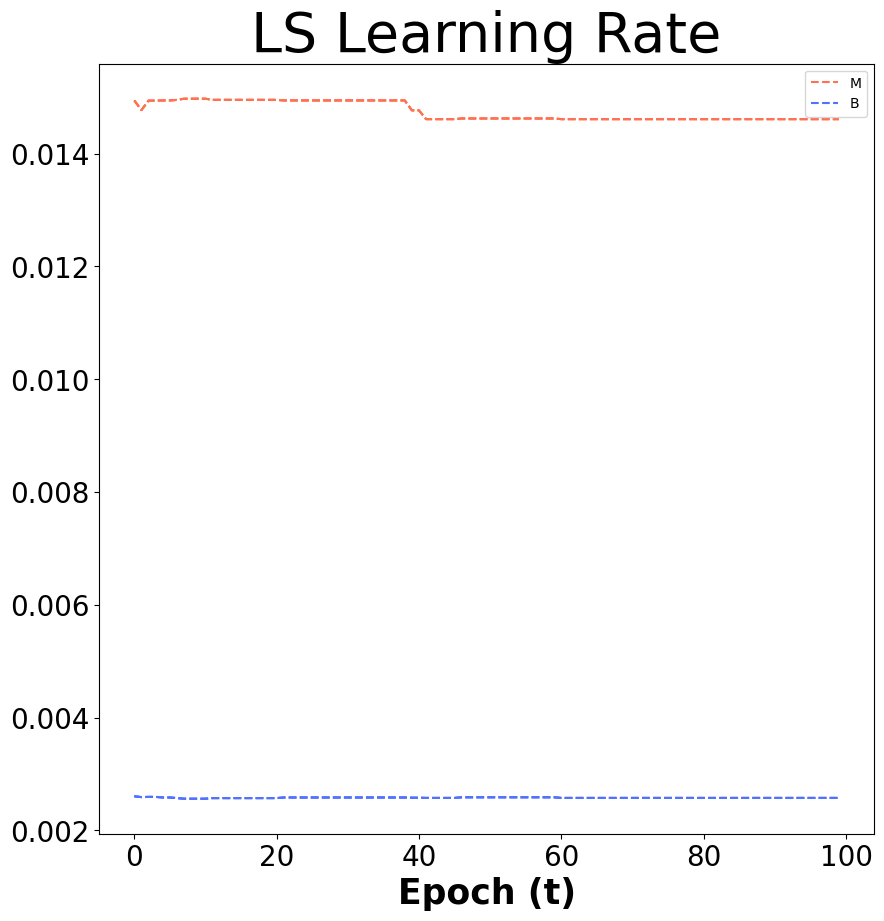

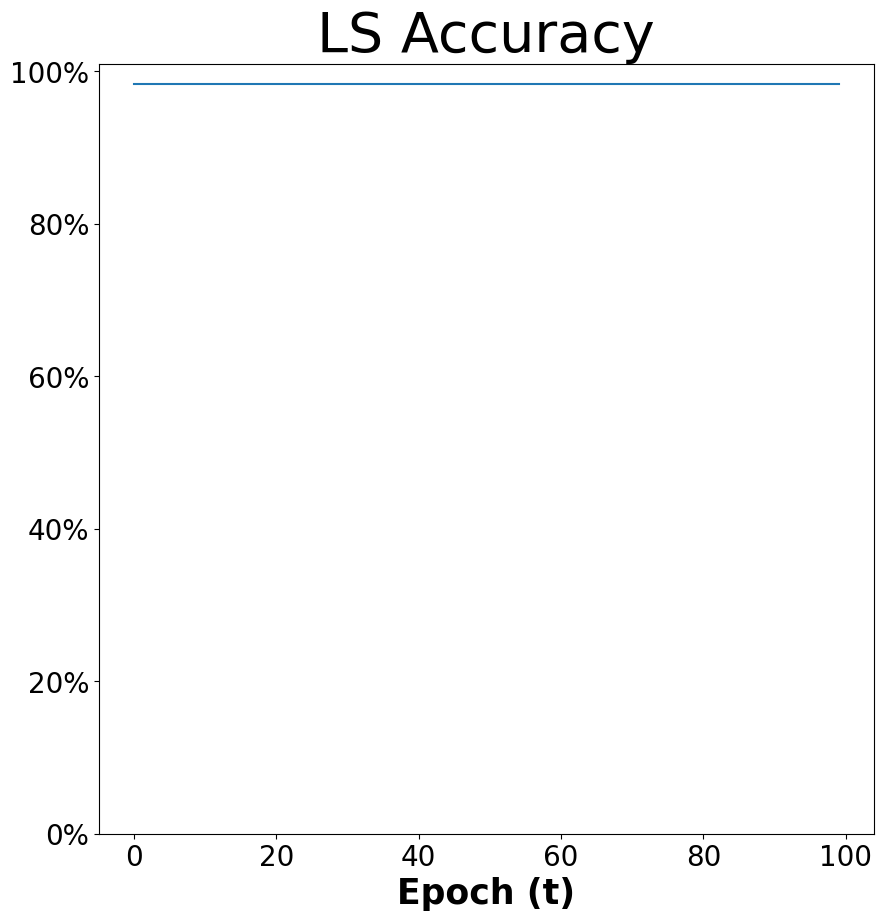

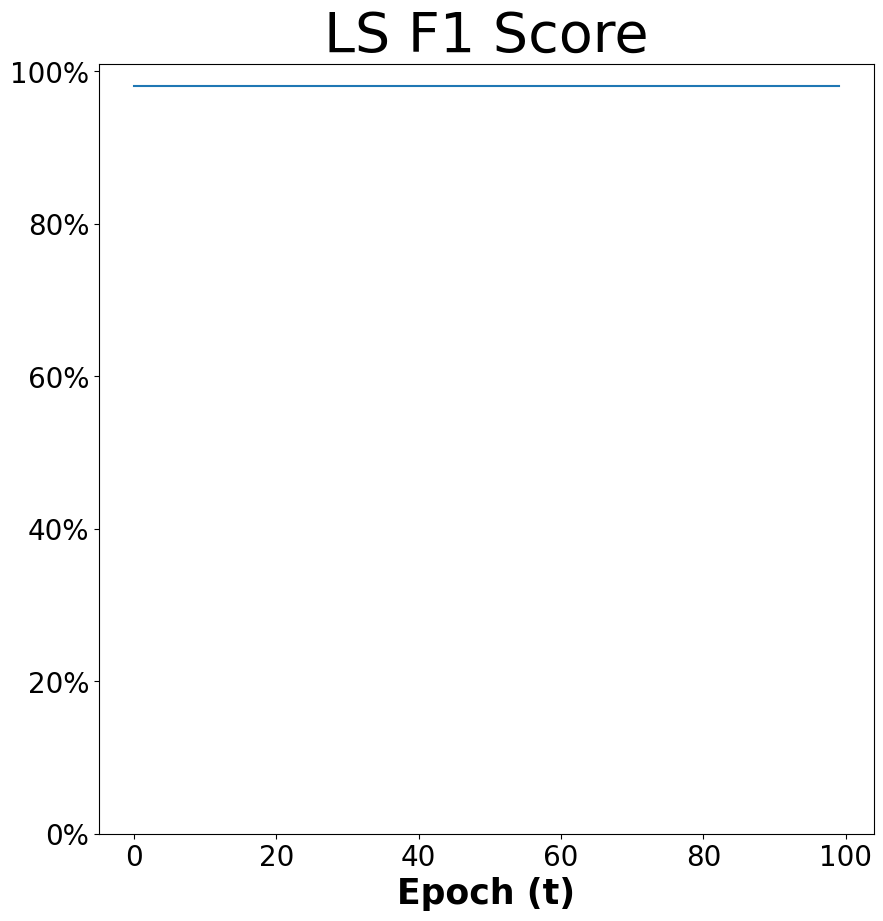

In [81]:
save_figs(ls_glvq_fscore, experiment, "LS", learning_rate)

##### 3-step lr = 0.01

In [82]:
learning_rate = 0.01
ls_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = ls_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.loose_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3721, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 11, Loss: 0.3401, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 21, Loss: 0.3343, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 31, Loss: 0.3326, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 41, Loss: 0.3316, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 51, Loss: 0.3308, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 61, Loss: 0.3302, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 71, Loss: 0.3296, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 81, Loss: 0.3292, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 91, Loss: 0.3288, Accuracy: 98.28 %, F_1_score: 98.14 %


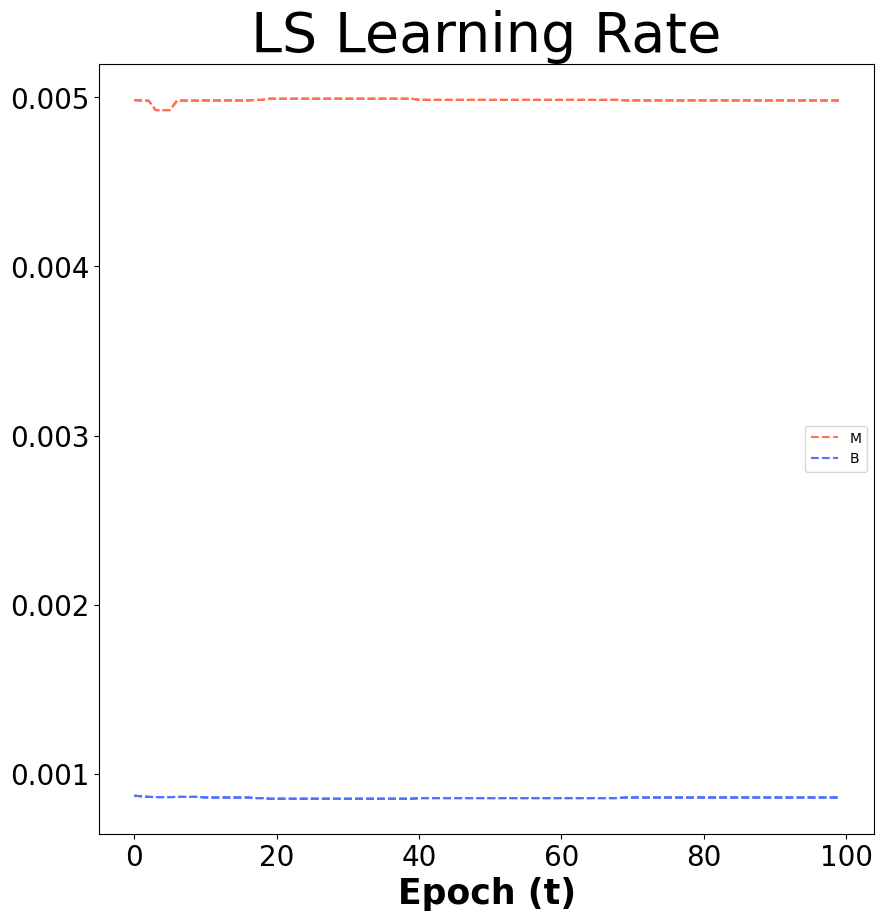

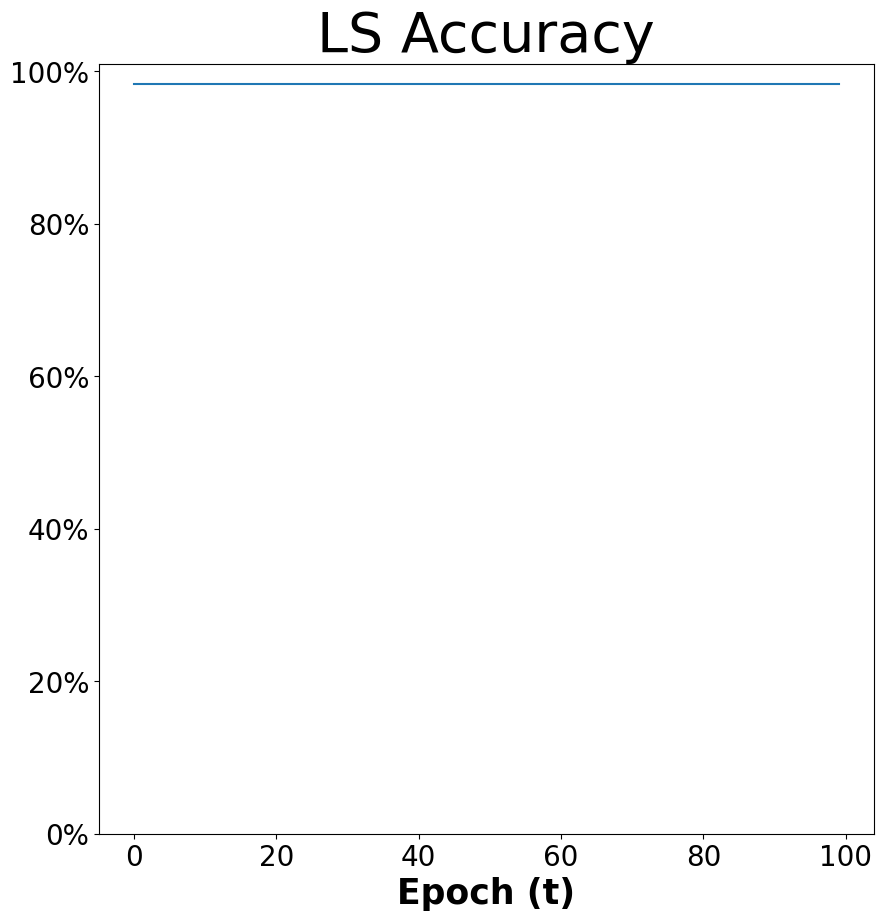

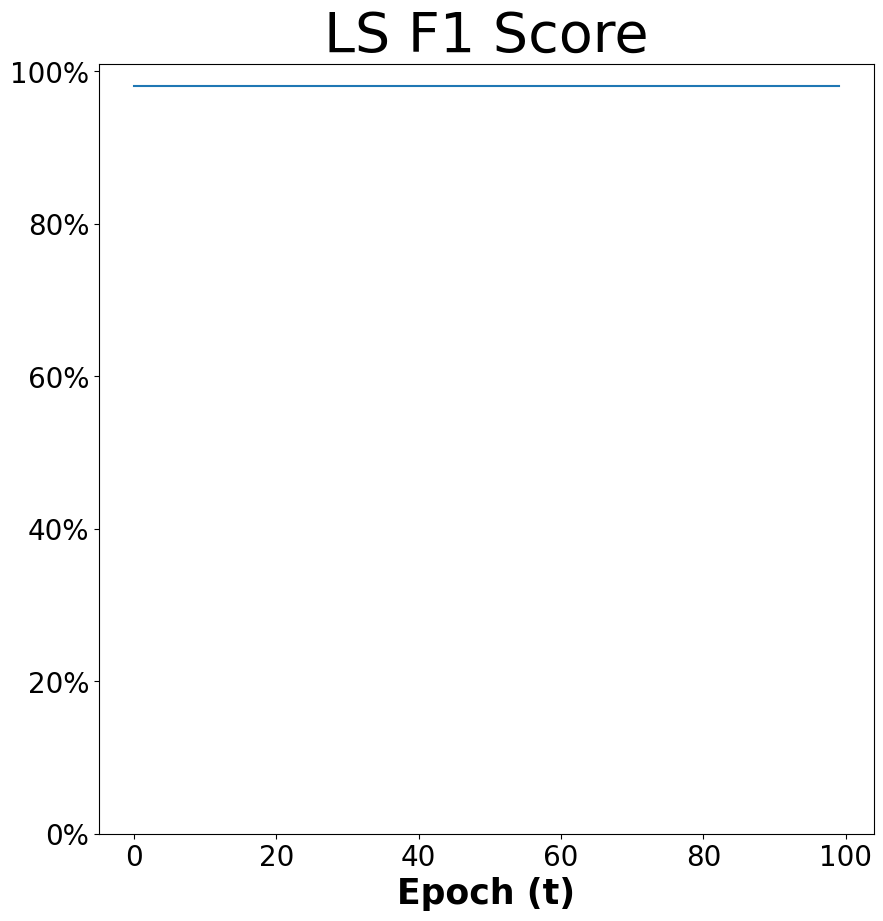

In [83]:
save_figs(ls_glvq_fscore, experiment, "LS", learning_rate)

##### LSR

##### 1-step lr = 0.1

In [84]:
learning_rate = 0.1
lsr_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = lsr_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.loose_symmetry_rarity,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3510, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 11, Loss: 0.3286, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 21, Loss: 0.3273, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 31, Loss: 0.3267, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 41, Loss: 0.3266, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 51, Loss: 0.3265, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 61, Loss: 0.3264, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 71, Loss: 0.3264, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 81, Loss: 0.3263, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 91, Loss: 0.3264, Accuracy: 98.28 %, F_1_score: 98.14 %


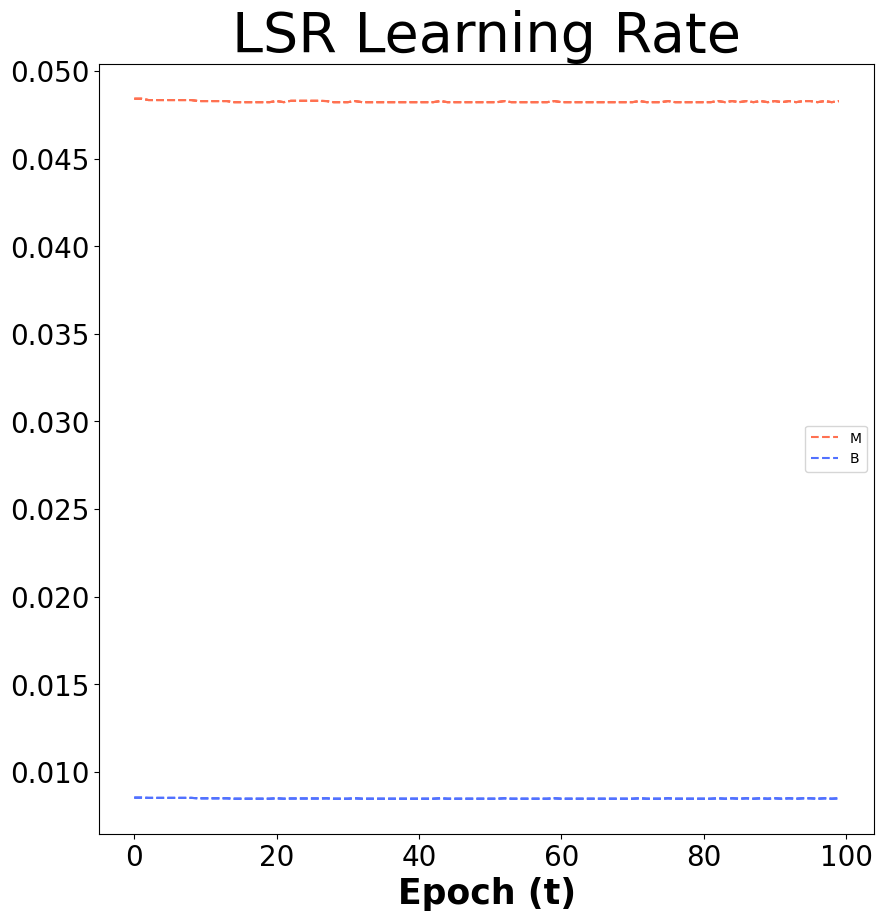

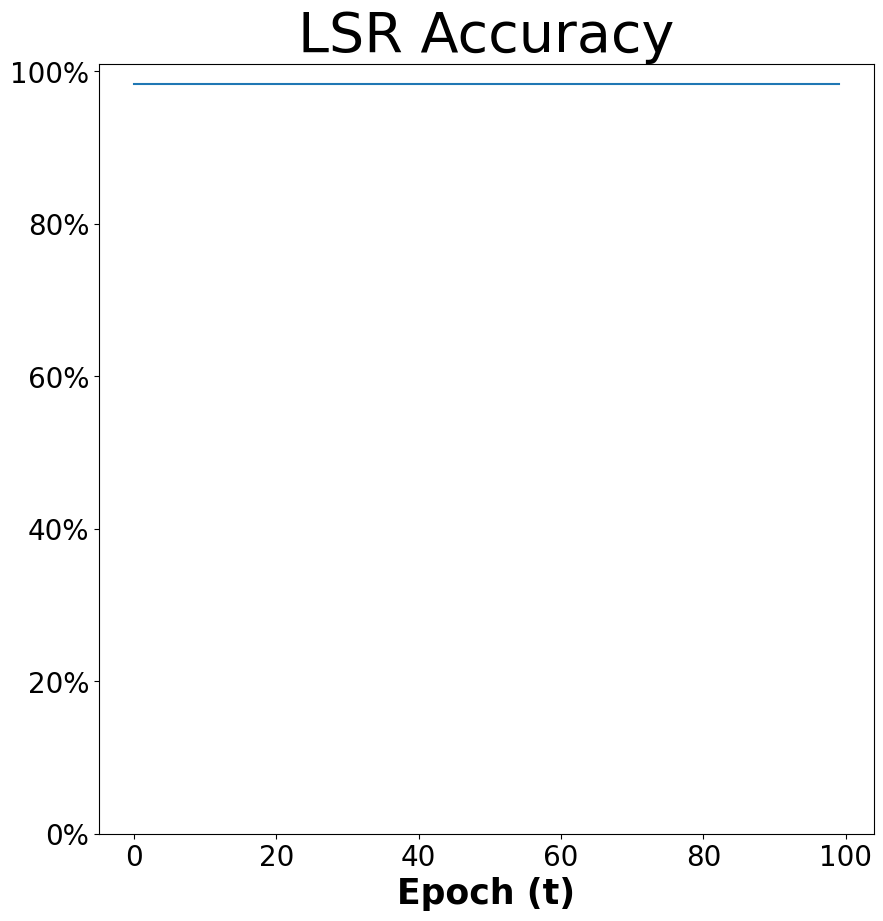

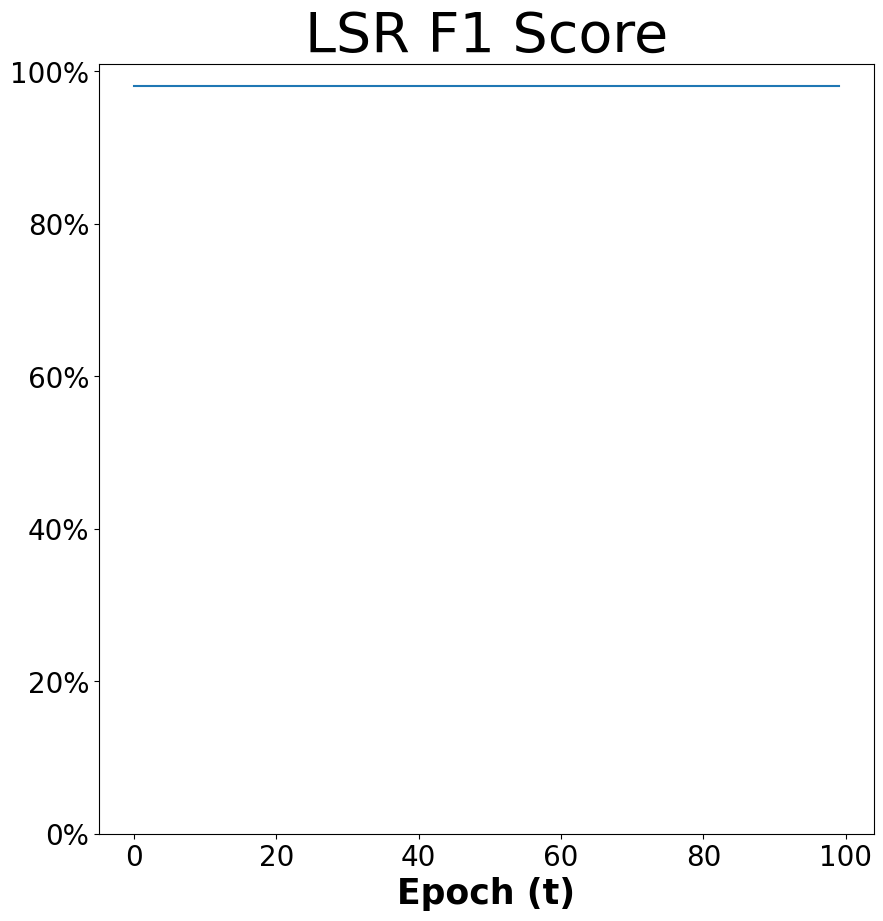

In [85]:
save_figs(lsr_glvq_fscore, experiment, "LSR", learning_rate)

##### 2-step lr = 0.03

In [86]:
learning_rate = 0.03
lsr_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = lsr_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.loose_symmetry_rarity,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3657, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 11, Loss: 0.3325, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 21, Loss: 0.3301, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 31, Loss: 0.3287, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 41, Loss: 0.3278, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 51, Loss: 0.3273, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 61, Loss: 0.3271, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 71, Loss: 0.3269, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 81, Loss: 0.3267, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 91, Loss: 0.3266, Accuracy: 98.28 %, F_1_score: 98.14 %


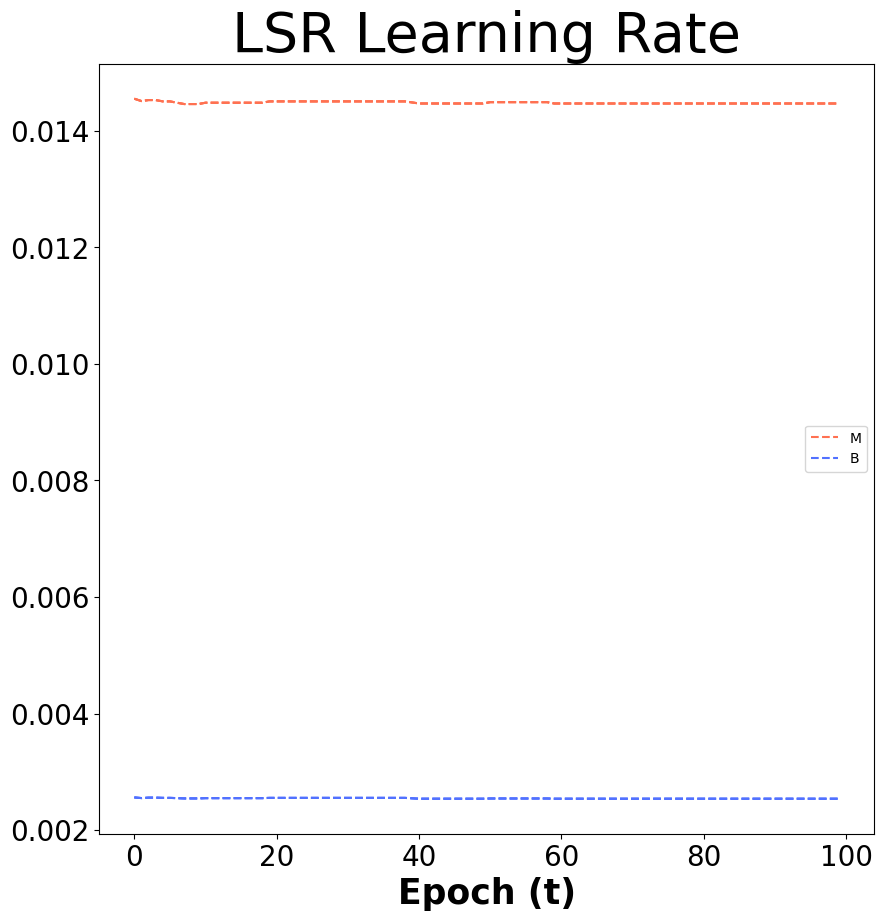

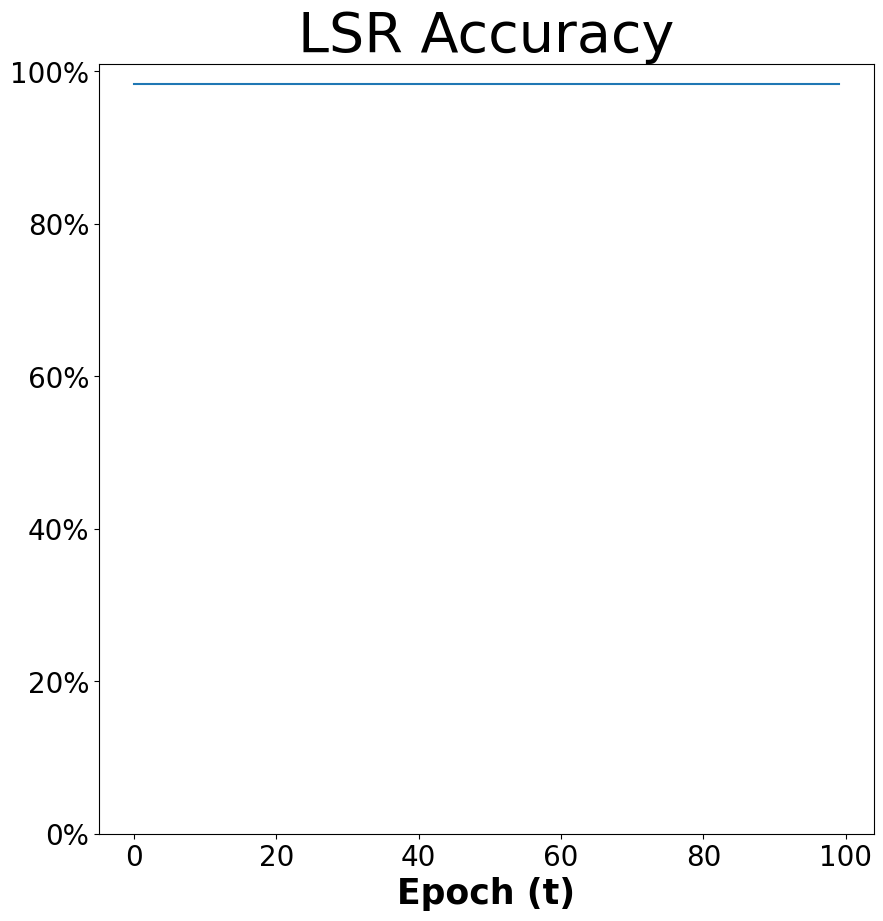

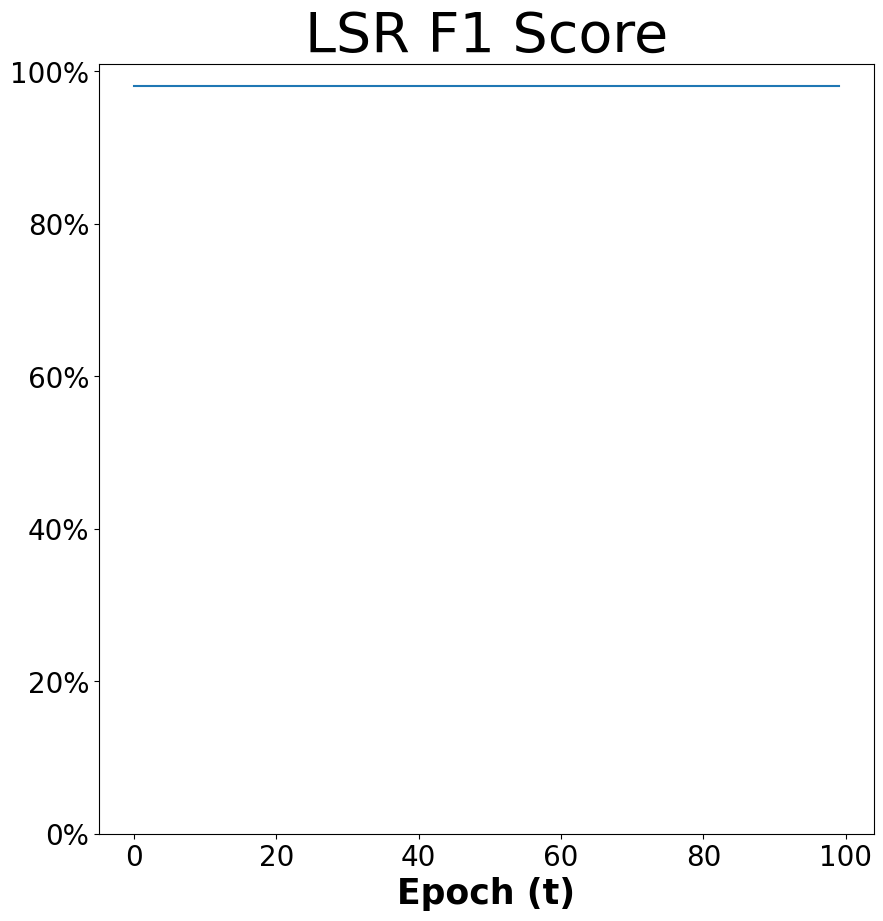

In [87]:
save_figs(lsr_glvq_fscore, experiment, "LSR", learning_rate)

##### 3-step lr = 0.01

In [88]:
learning_rate = 0.01
lsr_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = lsr_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.loose_symmetry_rarity,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3722, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 11, Loss: 0.3406, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 21, Loss: 0.3345, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 31, Loss: 0.3326, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 41, Loss: 0.3315, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 51, Loss: 0.3307, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 61, Loss: 0.3301, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 71, Loss: 0.3295, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 81, Loss: 0.3291, Accuracy: 98.28 %, F_1_score: 98.14 %
Epoch: 91, Loss: 0.3287, Accuracy: 98.28 %, F_1_score: 98.14 %


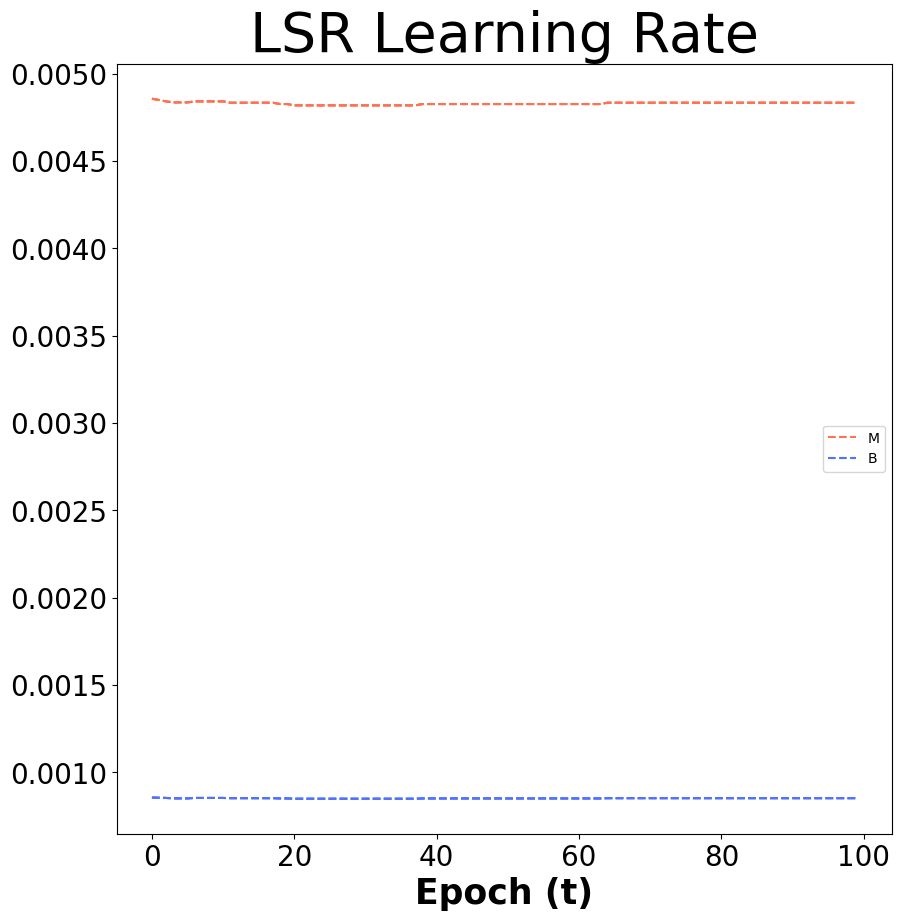

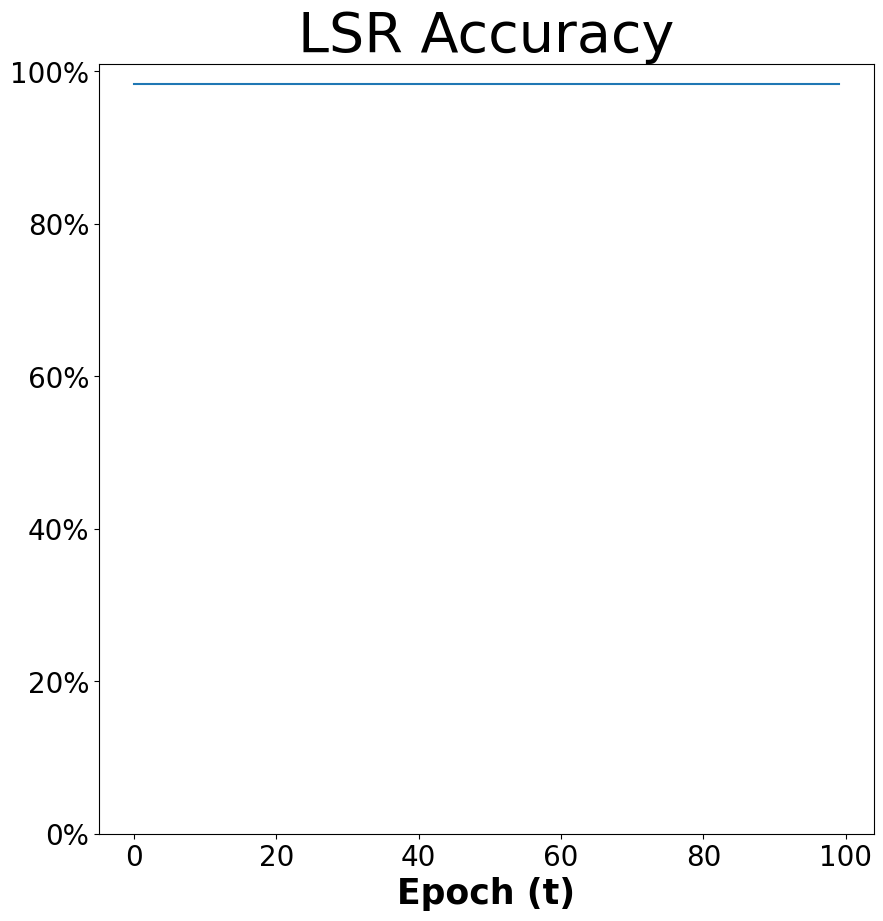

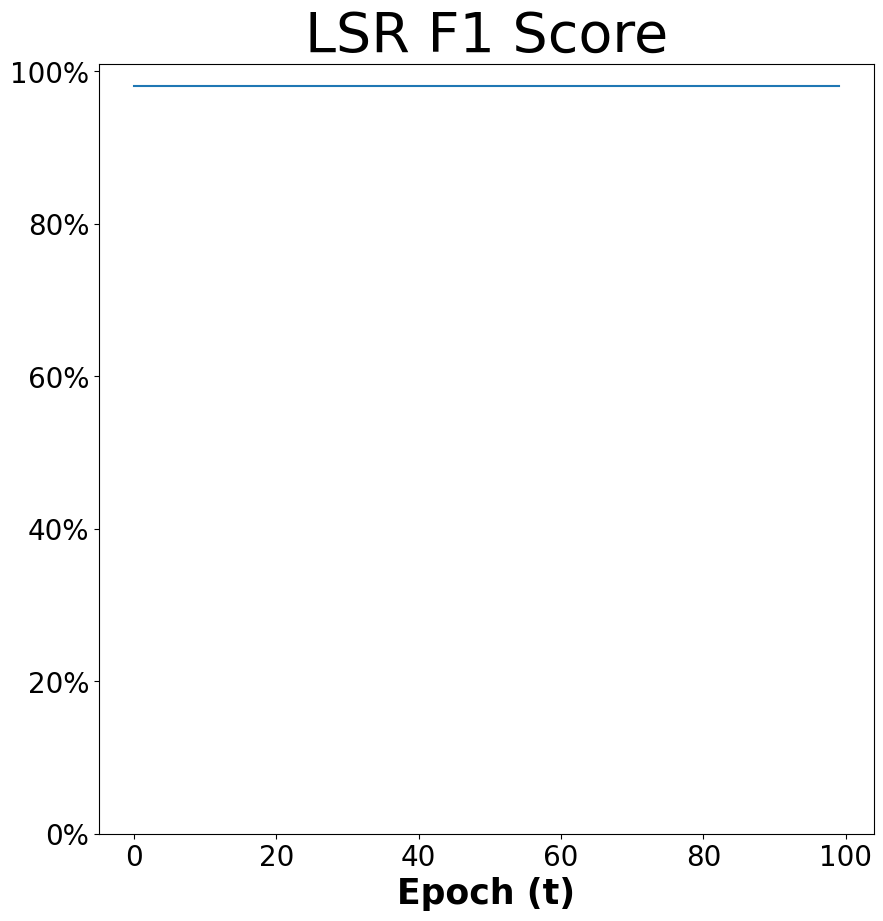

In [89]:
save_figs(lsr_glvq_fscore, experiment, "LSR", learning_rate)